# Predição de Precos de Carros Usados

Este notebook foi desenvolvido como parte do [Desafio Kaggle para Predição de Carros Usados](https://www.kaggle.com/competitions/playground-series-s4e9/overview). O objetivo deste desafio é prever o preço de um carro dado um conjunto de atributos.

Para avaliar a eficacia dos modelos de regressão, foi utilizada a função de Erro Quadrático Médio (RMSE).

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}
$$

# Índice

- [1 - Importando-Bibliotecas](#1_Importando_Bibliotecas)
- [2 - Importando Dados](#2_Importando_Dados)
- [3 - Criando_classes](#3_Criando_classes)
- [4 - Analise_Exploratoria-Dados](#4_Analise_Exploratoria-Dados)
- [5 - Tratamento dos Dados](#5_Tratamento_Dados)
- [6 - Principais caracteristicas ](#6_Principais_caracteristicas)
- [7 - Treinamento dos Modelos](#7_Treinamento_Dos_Modelos)
- [8 - Avaliando os modelos](#8_Avaliação_Dos_Modelos)

In [11]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("Está no google colab")
except:
    IN_COLAB = False
    print("Não está no google colab")

Não está no google colab


# 1_Importando_Bibliotecas

In [12]:
if IN_COLAB:
    !pip install -r /content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/requirements.txt

In [13]:
import pandas as pd
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import numpy as np
import pickle
import sys
import datetime
from pickle import UnpicklingError

# Tratamentos
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import shap
from shap import Cohorts, Explanation
from shap.utils._exceptions import DimensionError

# Treinamento
import keras
import keras_tuner
from keras import layers
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, QuantileRegressor,SGDRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


##Avaliacao
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score,root_mean_squared_error,mean_absolute_percentage_error,root_mean_squared_log_error

## Calibracao

from venn_abers import VennAbersCalibrator
from sklearn.base import BaseEstimator, RegressorMixin

In [14]:
## /workspaces/Regression-of-Used-Car-Prices/env/lib/python3.10/site-packages/lazypredict/Supervised.py:98 mudar OneHotEncoder(handle_unknown="ignore", sparse=False) para OneHotEncoder(handle_unknown="ignore", sparse_output=False)
from lazypredict.Supervised import LazyRegressor

In [15]:
import sys
sys.path.append('/home/vscode/.local/lib/python3.10/site-packages')
from feature_engine.transformation import LogCpTransformer, YeoJohnsonTransformer, BoxCoxTransformer

In [16]:
plt.style.use("ggplot")
%matplotlib inline
warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows', None)

# 2_Importando_Dados

In [17]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")

    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados'


else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")

    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")

    diretorio = 'dados'

if "train_split.csv" not in arquivos or "test_split.csv" not in arquivos:
    dados = pd.read_csv(diretorio + "/train.csv")
    train, test  = train_test_split(dados, test_size=0.2)
    train.to_csv(diretorio + "/train_split.csv", index=False)
    test.to_csv(diretorio + "/test_split.csv", index=False)
    predict = pd.read_csv(diretorio + "/test.csv")

else:
    train = pd.read_csv(diretorio + "/train_split.csv")
    test = pd.read_csv(diretorio + "/test_split.csv")
    predict = pd.read_csv(diretorio + "/test.csv")

# 3_Criando_classes

In [18]:
class Tratamento:
    """
    Esta classe contém métodos para tratamento e transformação de dados em um DataFrame.
    Inclui funções para remoção de colunas, extração de características como cilindros, marchas, potência (HP), 
    e manipulação de dados categóricos e numéricos.
    """
    def retirando_ids(self, dados):
        """
        Remove a coluna `id` de um DataFrame.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame que contém a coluna `id`.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame sem a coluna `id`.
        - `id_dados` (pd.Series): Série contendo os IDs removidos.
        """
        dados_sem_id = dados.copy()
        id_dados = dados_sem_id["id"]
        dados_sem_id.drop("id", axis=1, inplace=True)
        return dados_sem_id, id_dados

    def extrair_cilindros(self, dados):
        """
        Extrai o número de cilindros de uma coluna de motores e limpa os dados.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame contendo a coluna 'engine' com descrições de motores.

        - **Retorna:**
          - `dados_cilindros` (pd.DataFrame): DataFrame com uma nova coluna 'cilindros', contendo o número de cilindros.
        """
        dados_cilindros = dados.copy()
        lista_engine = []
        for t in dados_cilindros['engine'].str.split(' '):
            if 'HP' in t[0]:
                if any(x in t[2] for x in ['Straight', 'Flat', 'Cylinder']):
                    lista_engine.append(t[3])
                elif 'Electric' in t[0] or 'Electric' in t[1]:
                    lista_engine.append('0')
                else:
                    lista_engine.append(t[2])
            elif 'L' in t[0]:
                try:
                    if any(x in t[1] for x in ['Straight', 'Flat', 'Cylinder']):
                        lista_engine.append(t[2])
                    else:
                        lista_engine.append(t[1])
                except IndexError:
                    lista_engine.append('None')
            elif len(t) > 1:
                if 'Liter' in t[1]:
                    lista_engine.append('None')
                else:
                    lista_engine.append(t)
            elif 'Electric' == t[0]:
                lista_engine.append('0')
            elif 'Intercooled' == t[0]:
                lista_engine.append(t[3])
            elif 'Dual' == t[0]:
                lista_engine.append('None')
            else:
                lista_engine.append('None')

        dados_cilindros['cilindros'] = lista_engine
        # Limpeza de valores na coluna de cilindros
        dados_cilindros['cilindros'] = pd.to_numeric(dados_cilindros['cilindros'].str.replace(r'[VIHW]', '', regex=True)
                                        .str.replace('Electric', '0')
                                        .str.replace('Rotary', 'None'), errors='coerce')
        # Preencher valores nulos com 0 para veículos elétricos
        dados_cilindros.loc[(dados_cilindros['cilindros'].isna()) & (dados_cilindros['fuel_type'] == 'electric'), 'cilindros'] = 0

        return dados_cilindros
    
    def extrair_hp(self, dados):
        """
        Extrai a potência do motor (HP) a partir da coluna 'engine'.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame contendo a coluna 'engine'.

        - **Retorna:**
          - `dados_hp` (pd.DataFrame): DataFrame com uma nova coluna 'hp', contendo a potência do motor.
        """
        dados_hp = dados.copy()
        # potencia do motor
        dados_hp['hp'] = pd.to_numeric([float(i[0].split('HP')[0]) if 'HP' in i[0] else None for i in dados_hp['engine'].
                                     str.split(' ')],errors='coerce')
        return dados_hp
    
    def extrair_marchas(self,dados):
        """
        Extrai o número de marchas a partir da coluna 'transmission'.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame contendo a coluna 'transmission'.

        - **Retorna:**
          - `dados_marchas` (pd.DataFrame): DataFrame com uma nova coluna 'marchas', contendo o número de marchas.
        """
        dados_marchas = dados.copy()
        dados_marchas['marchas'] = pd.to_numeric([i[0] if len(i) > 1 else None for i in dados_marchas['transmission'].str.split('-')],errors='coerce')
        return dados_marchas
    
    def extrair_idade_carros(self,dados):
        """
        Calcula a idade dos carros com base no ano do modelo.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame contendo a coluna 'model_year'.

        - **Retorna:**
          - `dados_idade` (pd.DataFrame): DataFrame com uma nova coluna 'idade_carro', contendo a idade dos carros.
        """
        dados_idade = dados.copy()
        # Idade do carro em anos
        dados_idade['idade_carro'] = datetime.datetime.now().year - dados_idade.model_year
        return dados_idade
    
   
    def extrair_cambio(self,dados):
    
        """
        Classifica o tipo de câmbio (automático, dual, manual) a partir da coluna 'transmission'.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame contendo a coluna 'transmission'.

        - **Retorna:**
          - `dados_cambio` (pd.DataFrame): DataFrame com uma nova coluna 'cambio', contendo a classificação do câmbio.
        """
        
        dados_cambio = dados.copy()
        
        automatic_patterns = [
            'Automatic', 'Auto-Shift', 'DCT Automatic', 'CVT', 'A/T'
        ]

        # Cria a nova coluna 'automatico' com base nos padrões
        dados_cambio['cambio'] = np.where(
            dados_cambio['transmission'].str.contains('|'.join(automatic_patterns), case=False, na=False),
            'automatico',
            np.where(dados_cambio['transmission'].str.contains('Dual'),'dual','manual') )
        return dados_cambio
    
    def drop_columns(self,dados,columns_drop):
        """
        Remove colunas específicas de um DataFrame.

        - **Parâmetros:**
        - `dados` (pd.DataFrame): DataFrame do qual as colunas serão removidas.
        - `columns_drop` (list): Lista de colunas a serem removidas.

        - **Retorna:**
        - `dados` (pd.DataFrame): DataFrame sem as colunas especificadas.
        """
        dados_drop = dados.copy()
        
        dados_drop.drop(columns_drop, axis=1, inplace=True)
        return dados_drop

    def imputar_dados_faltantes_modelo(
        self, dados, classe_predictor, categorical_features, numerical_features, modelo_imputer=None,
    ):
        """
        Imputa dados faltantes utilizando um modelo de aprendizado.

        - **Parâmetros:**
          - `dados` (pd.DataFrame): DataFrame com dados faltantes.
          - `classe_predictor` (str): Coluna alvo a ser imputada.
          - `categorical_features` (list): Lista de colunas categóricas.
          - `numerical_features` (list): Lista de colunas numéricas.
          - `modelo_imputer` (opcional): Modelo já treinado para imputação.

        - **Retorna:**
          - `dados_inputar` (pd.DataFrame): DataFrame com os valores imputados.
          - `pipe` (Pipeline): Modelo utilizado para a imputação, se criado.
        """
        if modelo_imputer is None:
            dados_inputar = dados.copy()
            ## substituindo os valores faltantes de marchas
            train_marchas = dados_inputar[dados_inputar[classe_predictor].notnull()]
            x_train_marchas = train_marchas[categorical_features + numerical_features]
            y_train_marchas = train_marchas[classe_predictor]

            pip_cat = Pipeline(steps=[
                ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist'))
            ])

            pip_num = Pipeline(steps=[
                ('inputar', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ])

            # Criação do ColumnTransformer
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', pip_num, numerical_features),
                    ('cat', pip_cat, categorical_features)
                ]
            )
            # Criação do pipeline final
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', RandomForestRegressor())
            ])
                        

            pipe.fit(x_train_marchas, y_train_marchas)

            x_predict_marchas= dados_inputar.loc[dados_inputar[classe_predictor].isnull(),categorical_features + numerical_features]

            dados_inputar.loc[x_predict_marchas.index,classe_predictor] = pipe.predict(x_predict_marchas).round()
            
            return dados_inputar, pipe
        else:
            dados_predict = dados.copy()
            
            x_predict_marchas= dados_predict.loc[dados_predict[classe_predictor].isnull(),categorical_features + numerical_features]
            
            dados_predict.loc[x_predict_marchas.index,classe_predictor] = modelo_imputer.predict(x_predict_marchas).round()
            
            return dados_predict
        
    def custom_combiner(self, feature, category):
        """
        Combina o nome da feature e da categoria em uma string.

        - **Parâmetros:**
        - `feature` (str): Nome da feature.
        - `category` (str): Nome da categoria.

        - **Retorna:**
        - `str`: String combinada da feature e categoria.
        """
        return str(feature) + "_"  + str(category)
    
    def criando_onehot(self,dados, col_categorical, model_onehot=None, list_frequenci = None):
            """
            Aplica OneHotEncoder às colunas categóricas especificadas.

            - **Parâmetros:**
            - `dados` (pd.DataFrame): DataFrame com as colunas categóricas.
            - `col_categorical` (list): Lista de colunas categóricas a serem transformadas.
            - `model_onehot` (dict, opcional): Dicionário de modelos OneHotEncoder a serem utilizados.
            - `list_frequenci` (list, opcional): Frequência mínima para OneHotEncoding.

            - **Retorna:**
            - `dados` (pd.DataFrame): DataFrame transformado com as colunas OneHot adicionadas.
            - `modelos_onehots` (dict, opcional): Dicionário de modelos OneHotEncoder utilizados.
            """

            modelos_onehots = {}
            
            if list_frequenci == None: 
                list_frequenci=len(col_categorical) * [0.05]

            if model_onehot is None:
                for frequenci, col in zip(list_frequenci,col_categorical):
                    model_onehot = OneHotEncoder(feature_name_combiner=self.custom_combiner,
                                                handle_unknown='infrequent_if_exist',
                                                min_frequency=frequenci)
                    model_onehot.fit(dados[[col]])
                    dados_onehot = model_onehot.transform(dados[[col]])
                    dados_onehot_df = pd.DataFrame(dados_onehot.toarray(),
                                                columns=model_onehot.get_feature_names_out(),
                                                index=dados.index)
                    dados = dados.join(dados_onehot_df)
                    modelos_onehots[col] = model_onehot
                    dados.drop(col, axis=1, inplace=True)

                return dados, modelos_onehots

            else:
                for col in col_categorical:
                    dados_onehot = model_onehot[col].transform(dados[[col]])
                    dados_onehot_df = pd.DataFrame(dados_onehot.toarray(),
                                                columns=model_onehot[col].get_feature_names_out(),
                                                index=dados.index)
                    dados = dados.join(dados_onehot_df)
                    dados.drop(col, axis=1, inplace=True)

                return dados
            
    def tipos_variaveis_numericas(self, dados, tipo=None):
        """
        Aplica transformação numérica aos dados.

        Parâmetros:
        - dados (array-like): Dados a serem transformados.
        - tipo (str, opicional): Tipo de transformação a ser aplicada. Pode ser 'StandardScaler', 'MinMaxScaler', 'BoxCoxTransformer', 'LogCpTransformer' ou 'YeoJohnsonTransformer'. Se não for fornecido, será utilizado 'StandardScaler' como padrão.

        Retorno:
        - dados_transformados (array-like): Dados transformados.
        - transformador (objeto): Instância do transformador utilizado.
        """

        # Define os transformadores disponíveis
        transformadores = {
            'StandardScaler': StandardScaler,
            'MinMaxScaler': MinMaxScaler,
            'BoxCoxTransformer': BoxCoxTransformer,
            'LogCpTransformer': LogCpTransformer,
            'YeoJohnsonTransformer': YeoJohnsonTransformer
        }

        # Verifica se o tipo de transformação é válido
        if tipo is None:
            tipo = 'StandardScaler'
        elif tipo not in transformadores:
            raise ValueError("Tipo de transformação inválido")

        # Instancia o transformador
        transformador = transformadores[tipo]()

        # Aplica a transformação
        dados_transformados = transformador.fit_transform(dados)

        return dados_transformados, transformador

    def transformacao_variaveis_numericas(self, dados, col_transformada, tipo=None, modelo_imputer=None):
        """
        Aplica transformação numérica a colunas específicas de DataFrames .

        - **Parâmetros:**
        - `dados` (pd.DataFrame): Conjunto de dados.
        - `col_numeric` (list): Lista de colunas numéricas a serem transformadas.
        - `tipo` (str, opcional): Tipo de transformação a ser aplicada (padrão: 'StandardScaler').
        - `modelo_imputer` (dict, opcional): Dicionário de modelos de imputação para o conjunto de teste.

        - **Retorna:**
        - `train_x` ou `test_x` (pd.DataFrame): DataFrame transformado.
        - `dic_transform` (dict): Dicionário de transformadores utilizados.
        """
        dados_trans_numerical = dados.copy()
        
        if modelo_imputer is None:
            dic_transform = {}
            for col in col_transformada:

                dados_trans_numerical[col], transformador_num = self.tipos_variaveis_numericas(dados_trans_numerical[col].values.reshape(-1, 1), tipo=tipo)

                dic_transform[col] = transformador_num

            return dados_trans_numerical, dic_transform
        else:
            dados_trans_numerical = dados.copy()
            for col in col_transformada:
                dados_trans_numerical[col] = modelo_imputer[col].transform(dados_trans_numerical[col].values.reshape(-1, 1))
            return dados_trans_numerical

# 4_Analise_Exploratoria-Dados

Retirando o `id` dados de test e train

In [7]:
id_train = train["id"]
id_test = test["id"]
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)
print(train.head())
test.head()

  brand             model  model_year  milage fuel_type  \
0   BMW      X1 sDrive28i        2021   13900  Gasoline   
1   BMW  650 Gran Coupe i        2013   98658  Gasoline   
2   Kia     Sorento LX V6        2019   42479  Gasoline   
3  Land  Rover Defender X        2023    4283  Gasoline   
4  Ford         F-150 XLT        2019   35580  Gasoline   

                                          engine  \
0   228.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
1   445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel   
2                           3.3L V6 24V GDI DOHC   
3              5.0L V8 32V GDI DOHC Supercharged   
4  325.0HP 2.7L V6 Cylinder Engine Gasoline Fuel   

                     transmission      ext_col      int_col  \
0  Transmission w/Dual Shift Mode         Gray        Brown   
1  Transmission w/Dual Shift Mode        White        Black   
2               6-Speed Automatic        Black  Satin Black   
3               8-Speed Automatic  Firenze Red        Black   
4                

brand                                 model  model_year  milage fuel_type  \
0   Land                   Rover Discovery LSE        2004  123921  Gasoline   
1  Lexus                           GX 460 Base        2012  212500  Gasoline   
2   Ford                            Mustang GT        1996  130000  Gasoline   
3   Land  Rover Range Rover Sport Supercharged        2007  118500  Gasoline   
4   Ford                             F-150 XLT        2019   69800  Gasoline   

                                          engine transmission ext_col int_col  \
0   217.0HP 4.6L 8 Cylinder Engine Gasoline Fuel          A/T   Green   Beige   
1   301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel          A/T   Black   Beige   
2   300.0HP 5.4L 8 Cylinder Engine Gasoline Fuel  4-Speed A/T     Red    Gray   
3   300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel  6-Speed A/T   Beige   Beige   
4  375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel          A/T    Gray   Black   

                                 accident clean_title  price  
0                           None reported         Yes   6399  
1  At least 1 accident or damage reported         NaN  17599  
2  At least 1 accident or damage reported         Yes  10500  
3                           None reported         Yes   9950  
4                           None reported         Yes  28500

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150826 entries, 0 to 150825
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         150826 non-null  object
 1   model         150826 non-null  object
 2   model_year    150826 non-null  int64 
 3   milage        150826 non-null  int64 
 4   fuel_type     146781 non-null  object
 5   engine        150826 non-null  object
 6   transmission  150826 non-null  object
 7   ext_col       150826 non-null  object
 8   int_col       150826 non-null  object
 9   accident      148843 non-null  object
 10  clean_title   133728 non-null  object
 11  price         150826 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 13.8+ MB


In [9]:
train.describe()

model_year         milage         price
count  150826.000000  150826.000000  1.508260e+05
mean     2015.818473   65779.113422  4.363719e+04
std         5.665087   49769.913223  7.586056e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24213.000000  1.700000e+04
50%      2017.000000   57800.000000  3.075000e+04
75%      2020.000000   95500.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06

In [10]:
train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

**Primeiro, verificamos a quantidade de valores faltantes por coluna.**

Identificamos que três colunas possuem valores faltantes:

- A coluna `clean_title` possui 11% de valores faltantes.
- A coluna `fuel_type` possui 3% de valores faltantes.
- A coluna `accident` possui 1% de valores faltantes.
"""

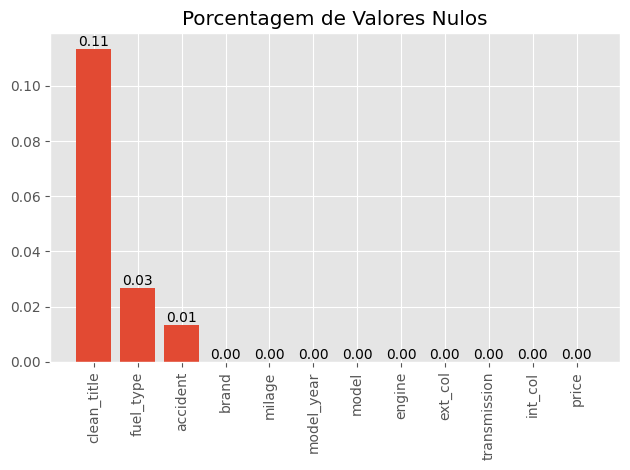

In [11]:
# Calcula a porcentagem de valores nulos
valor_nul = (train.isnull().sum() / train.shape[0]).sort_values(ascending=False)

# Cria os subplots
# Subplot para 'train'
plt.bar(valor_nul.index, valor_nul.values)
plt.title("Porcentagem de Valores Nulos")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(valor_nul.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

**Agora, verificamos as colunas numericas**

- A coluna `model_year` contém os anos de fabricação dos carros. Ao analisá-la, observa-se uma grande concentração de veículos fabricados entre os anos de 2010 e 2023, sendo o ano de 2021 o mais frequente. O ano mais antigo registrado é 1974.

- A coluna `milage`, que representa a quilometragem dos veículos, apresenta uma distribuição assimétrica, com maior concentração de valores à esquerda. No boxplot, a maioria dos valores está entre 24 mil e 95,5 mil quilômetros, com o terceiro quartil indicando o valor mais elevado. Aproximadamente 0,92% dos dados são considerados outliers. A diferença entre a média e a mediana é de 12,13%

- A coluna `price`, que é o alvo da predição, possui a maioria dos valores entre 17 mil e 49 mil. A porcentagem de outliers é de 5,72%. A diferença entre a média e a mediana é de 29,53%.


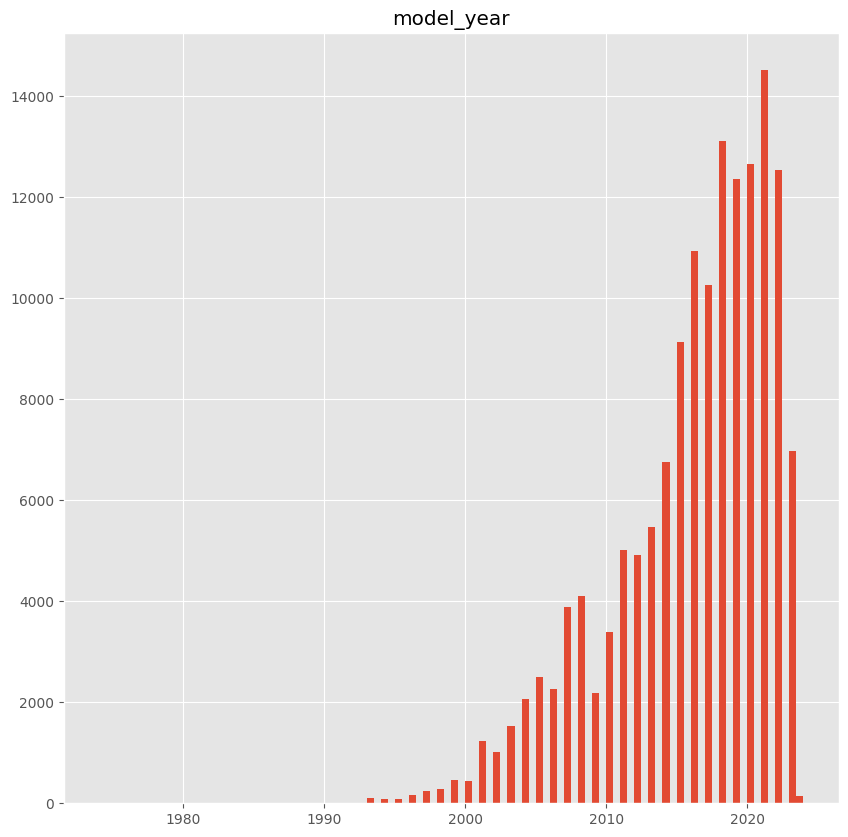

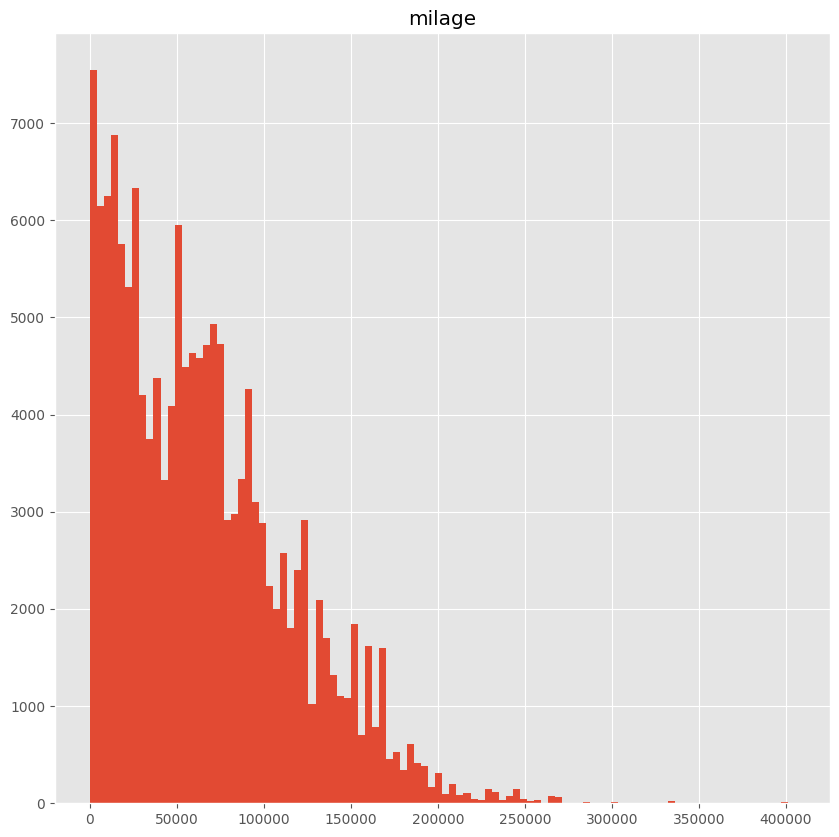

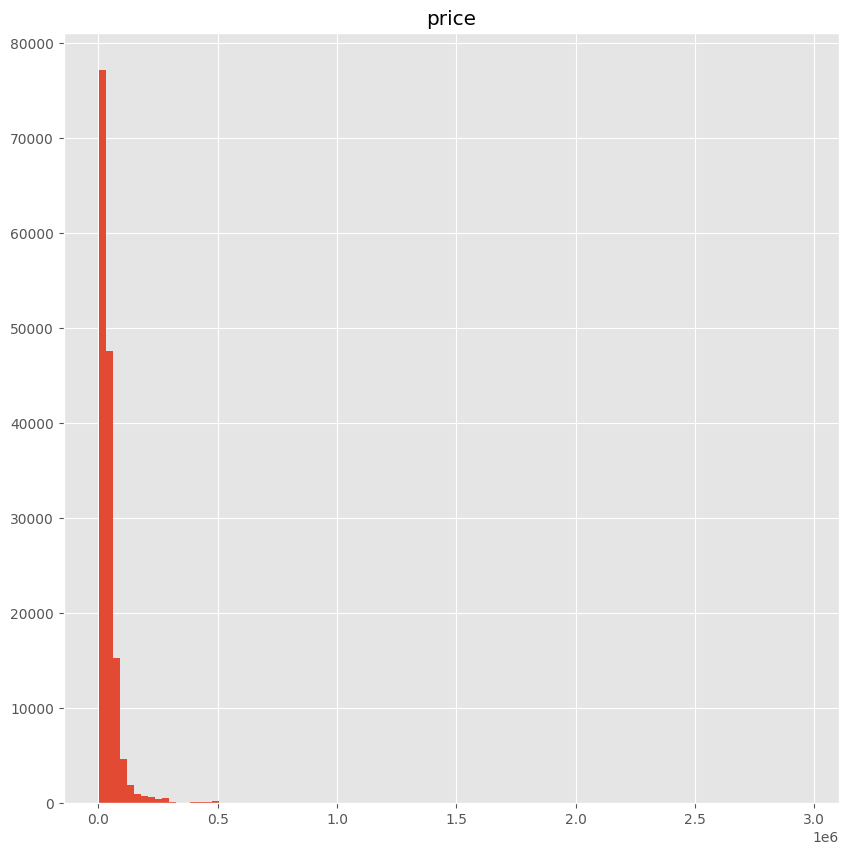

In [12]:
## plot histograma dos valores numericos
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        plt.figure(figsize=(10, 10))
        train[col].hist(bins=100)
        plt.title(col)
        plt.show()
        plt.close()

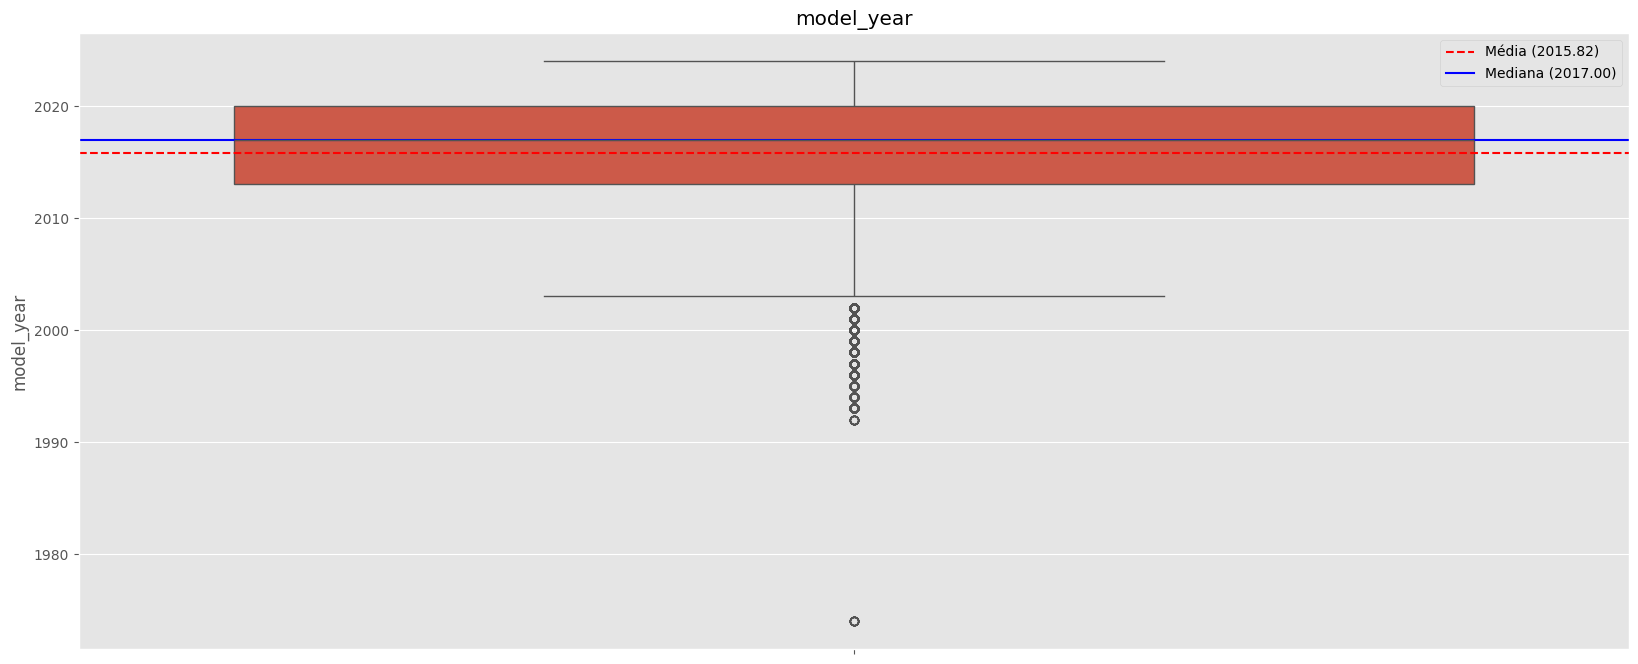

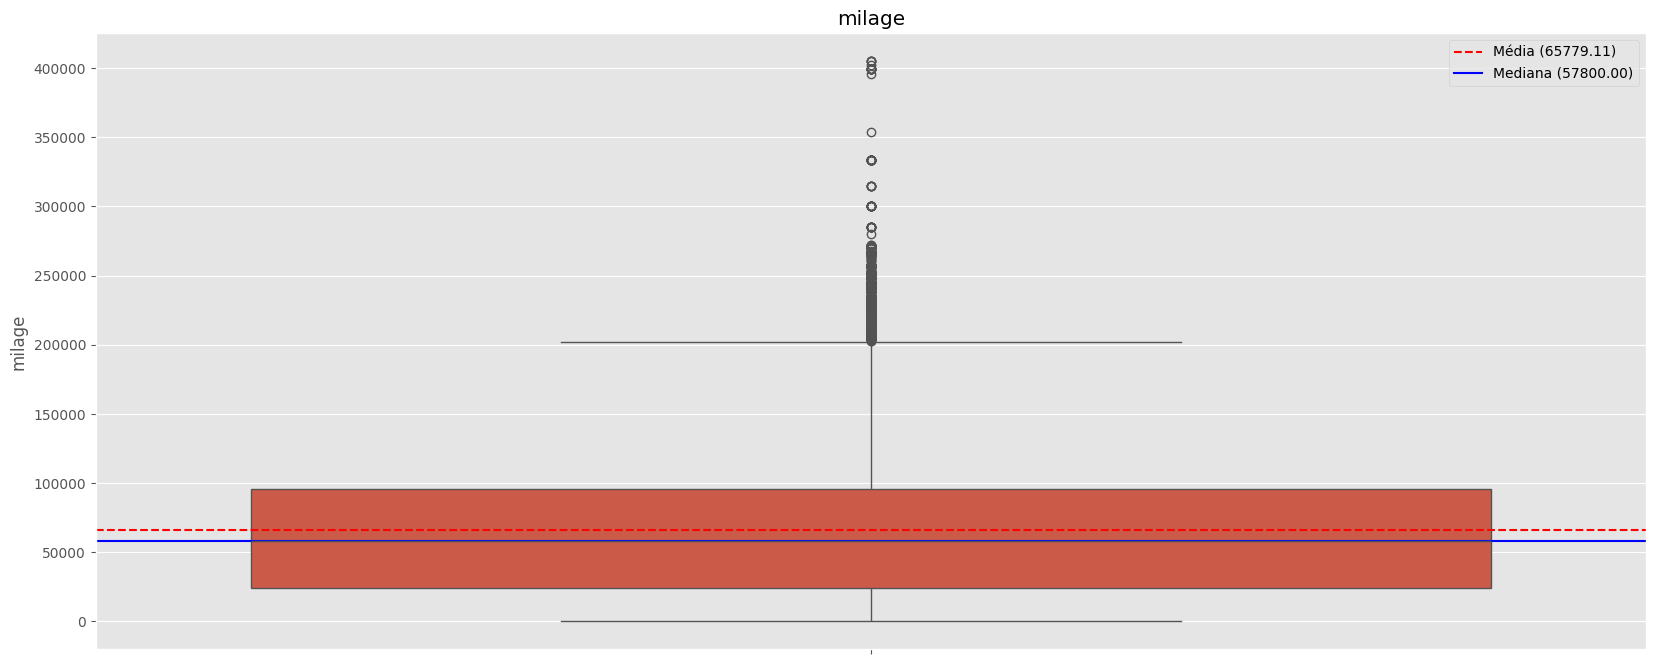

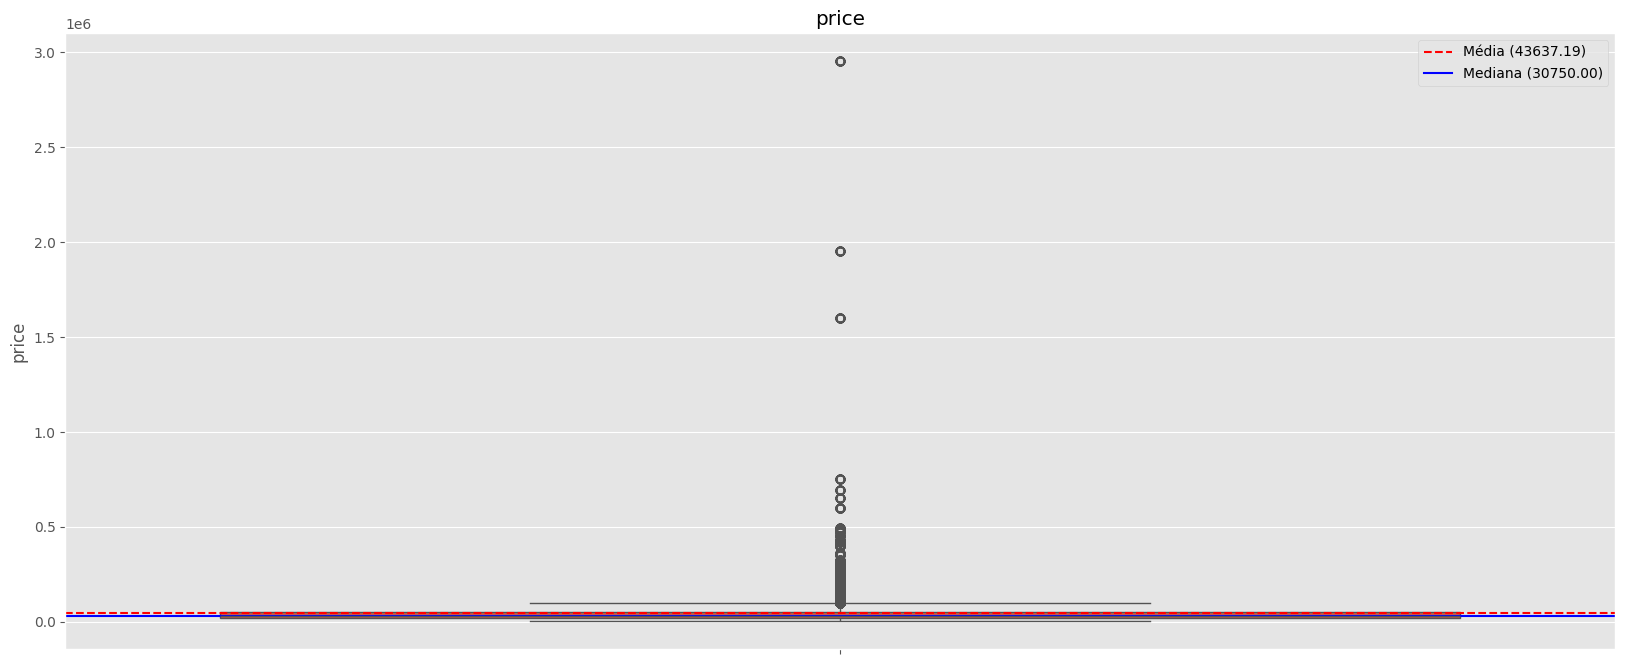

In [13]:
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        plt.figure(figsize=(20, 8))
        sns.boxplot(train[col],showfliers=True)
        plt.title(f"{col}")
        plt.axhline(
            y=mean_value, color="red", linestyle="--", label=f"Média ({mean_value:.2f})"
        )
        plt.axhline(
            y=median_value,
            color="blue",
            linestyle="-",
            label=f"Mediana ({median_value:.2f})",
        )
        plt.legend()
        plt.show()

In [14]:
# difernca percentual entre a media e a mediana
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        mean_value = train[col].mean()
        median_value = train[col].median()
        diff_mean_median = (mean_value - median_value) / mean_value * 100
        print(
            f"{col}: Diferença entre media e mediana dados train: {diff_mean_median:.2f} %"
        )

model_year: Diferença entre media e mediana dados train: -0.06 %
milage: Diferença entre media e mediana dados train: 12.13 %
price: Diferença entre media e mediana dados train: 29.53 %


In [15]:
# Porcentagem de outliers
for col in train.columns:
    if train[col].dtype == "float64" or train[col].dtype == "int64":
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        upper_bound, lower_bound
        out_train = train[
            (train[col] < lower_bound) | (train[col] > upper_bound)
        ].shape[0]


        print(f"Explorando a porcentagem de outliers na coluna {col}")
        print(f"{col}: {out_train/train.shape[0]:.2%}")
        print("-------------------------------------------------------------")

Explorando a porcentagem de outliers na coluna model_year
model_year: 2.74%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna milage
milage: 0.92%
-------------------------------------------------------------
Explorando a porcentagem de outliers na coluna price
price: 5.72%
-------------------------------------------------------------


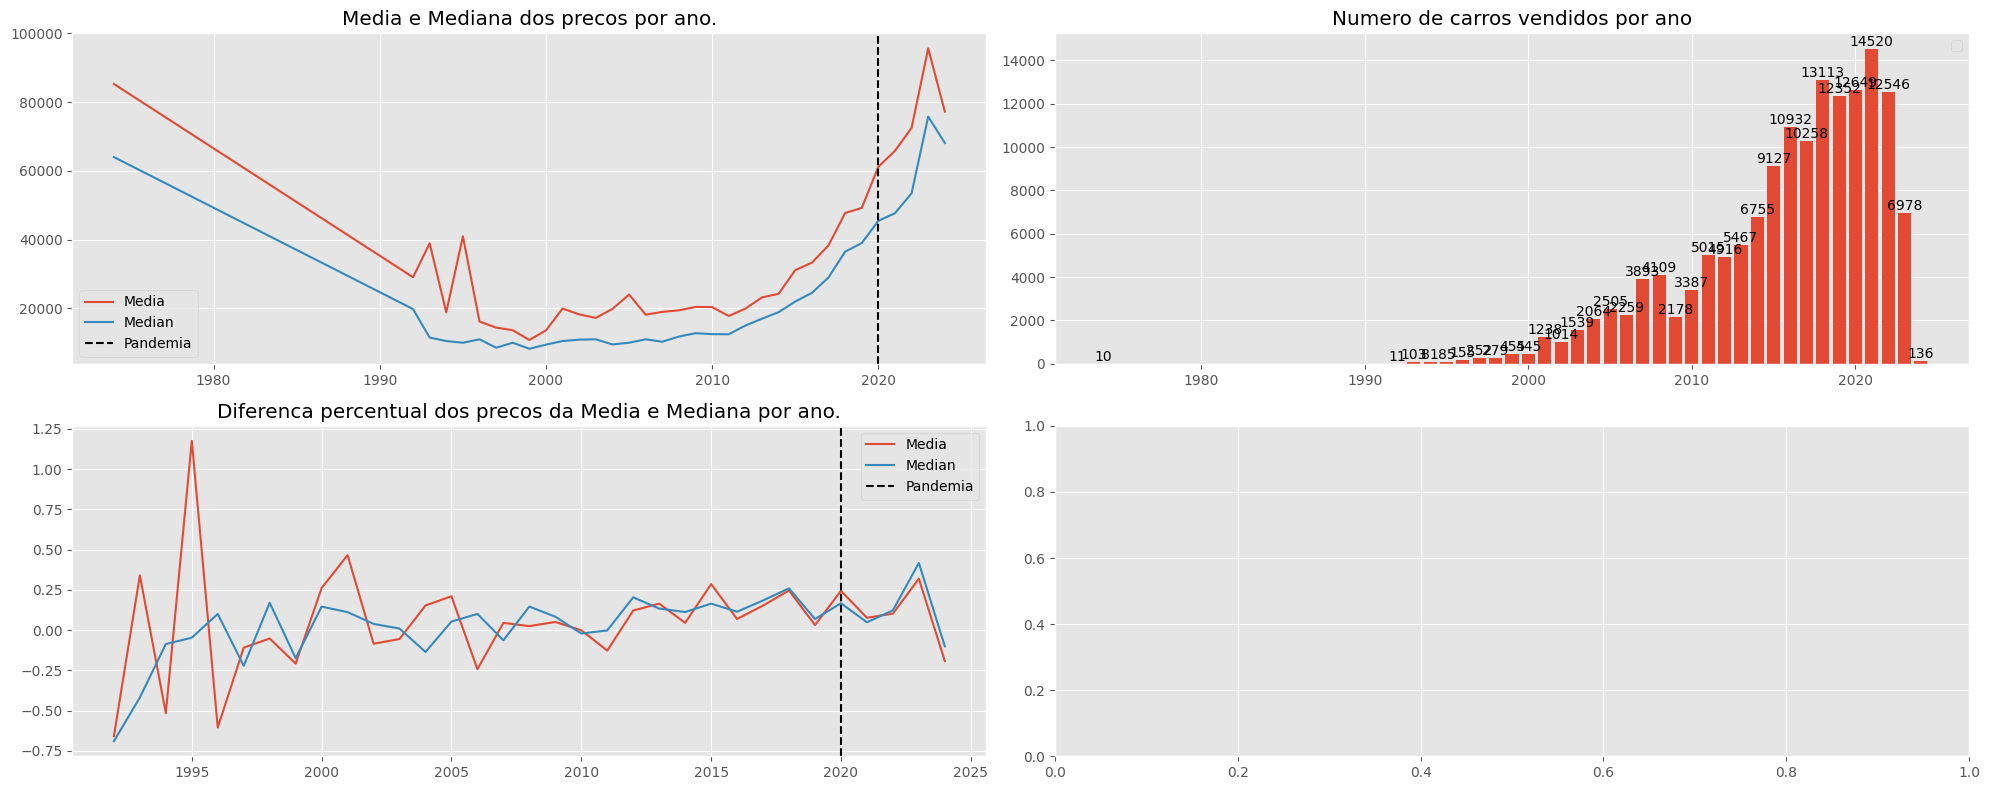

In [16]:
result = train.groupby("model_year")['price'].agg(["mean", "median"])
result_2 = train.groupby("model_year")['price'].count()
diferenca_percentual = result.pct_change()

fig, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0][0].plot(result.index, result['mean'], label="Media")
axes[0][0].plot(result.index, result['median'], label="Median")
axes[0][0].legend()
axes[0][0].set_title('Media e Mediana dos precos por ano.')
axes[0][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[0][0].legend()

axes[0][1].bar(result_2.index, result_2.values)
axes[0][1].legend()
axes[0][1].set_title('Numero de carros vendidos por ano')
for index, value in zip(result_2.index, result_2):
    axes[0][1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    

axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['mean'], label="Media")
axes[1][0].plot(diferenca_percentual.index, diferenca_percentual['median'], label="Median")
axes[1][0].legend()
axes[1][0].axvline(
            x= 2020,
            color="black",
            linestyle="--",
            label="Pandemia",
        )
axes[1][0].set_title('Diferenca percentual dos precos da Media e Mediana por ano.')
axes[1][0].legend()
plt.tight_layout()
plt.show()

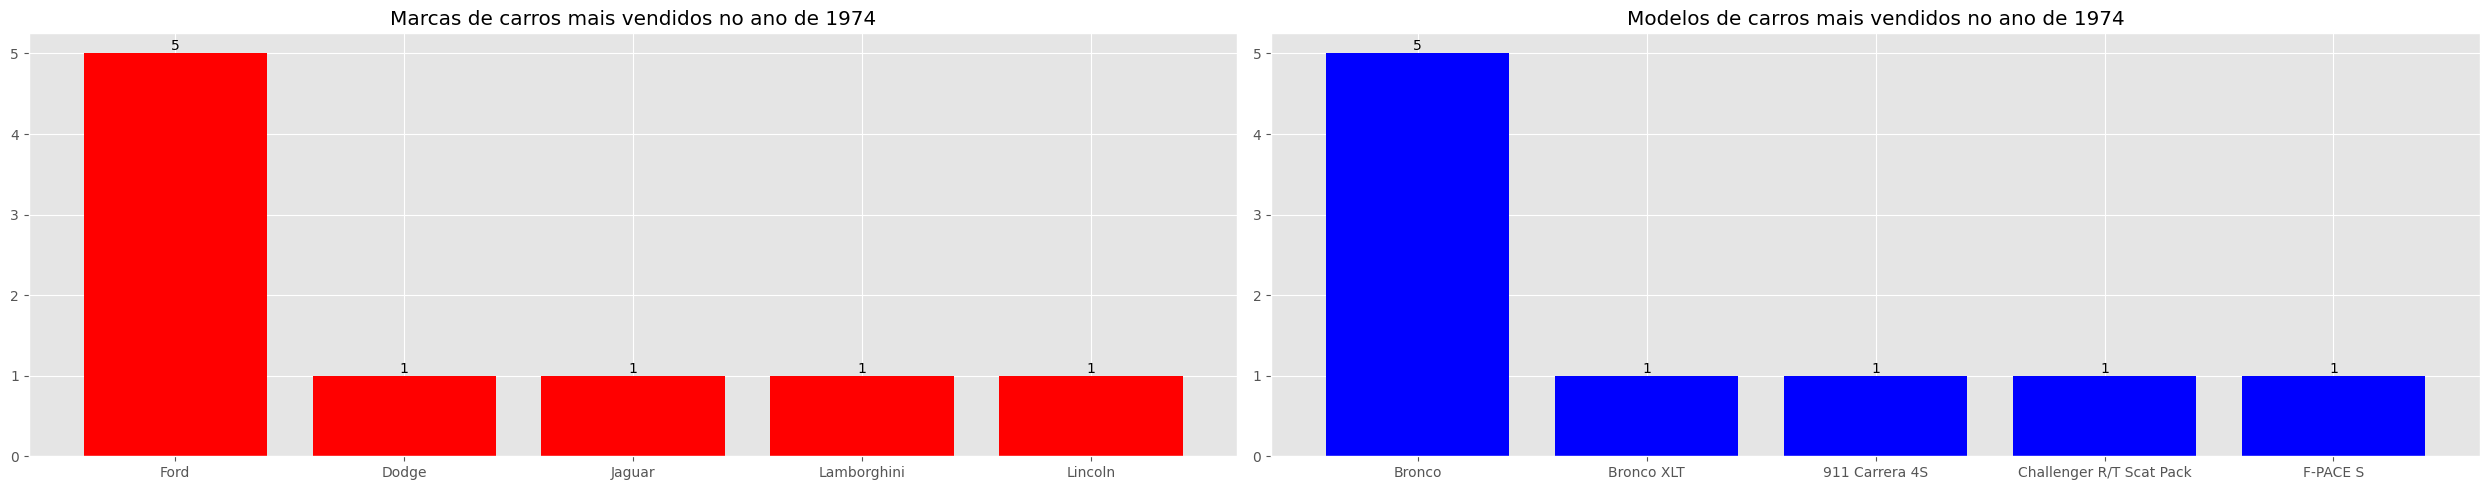

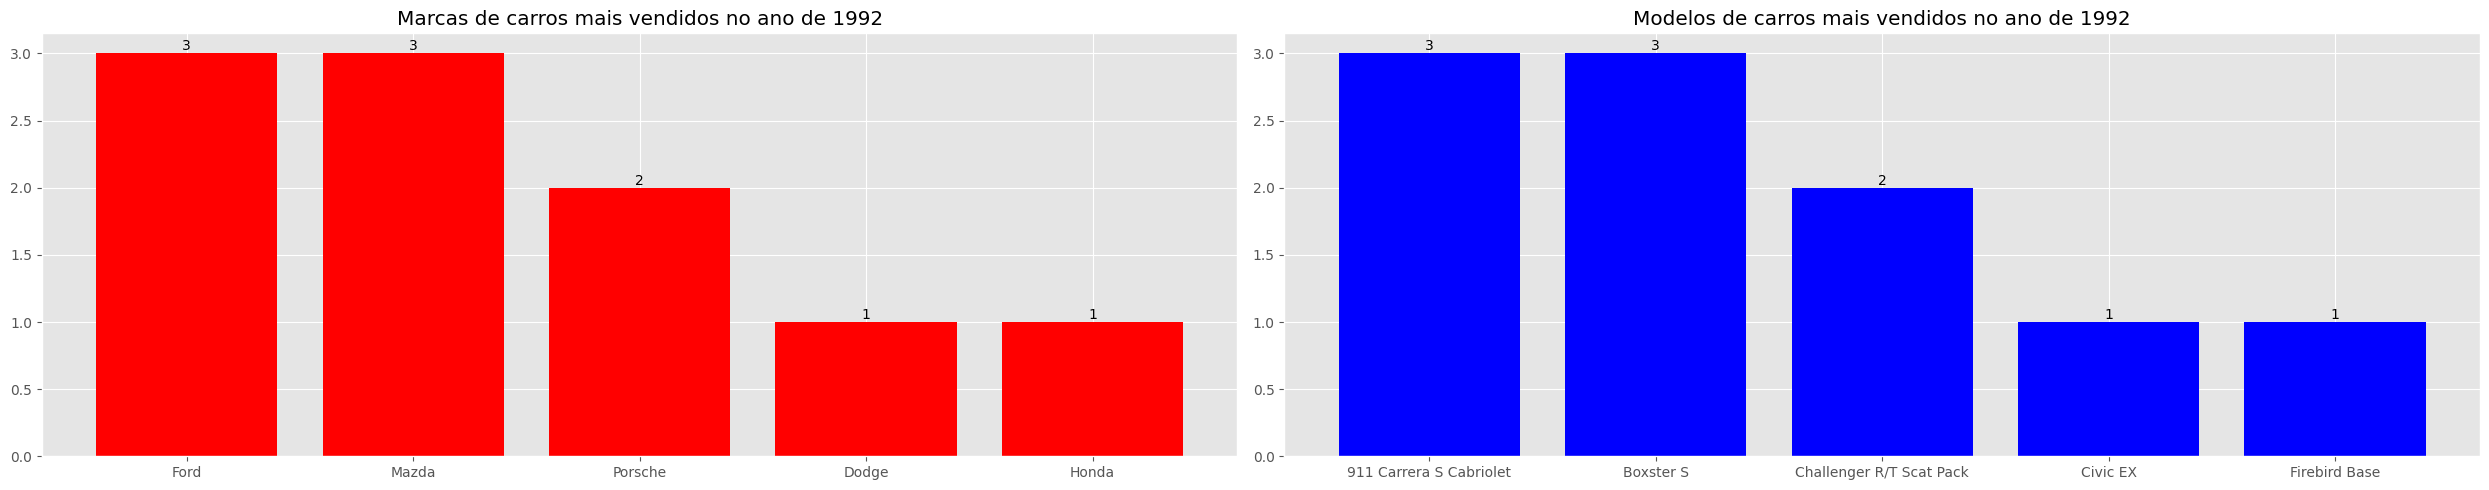

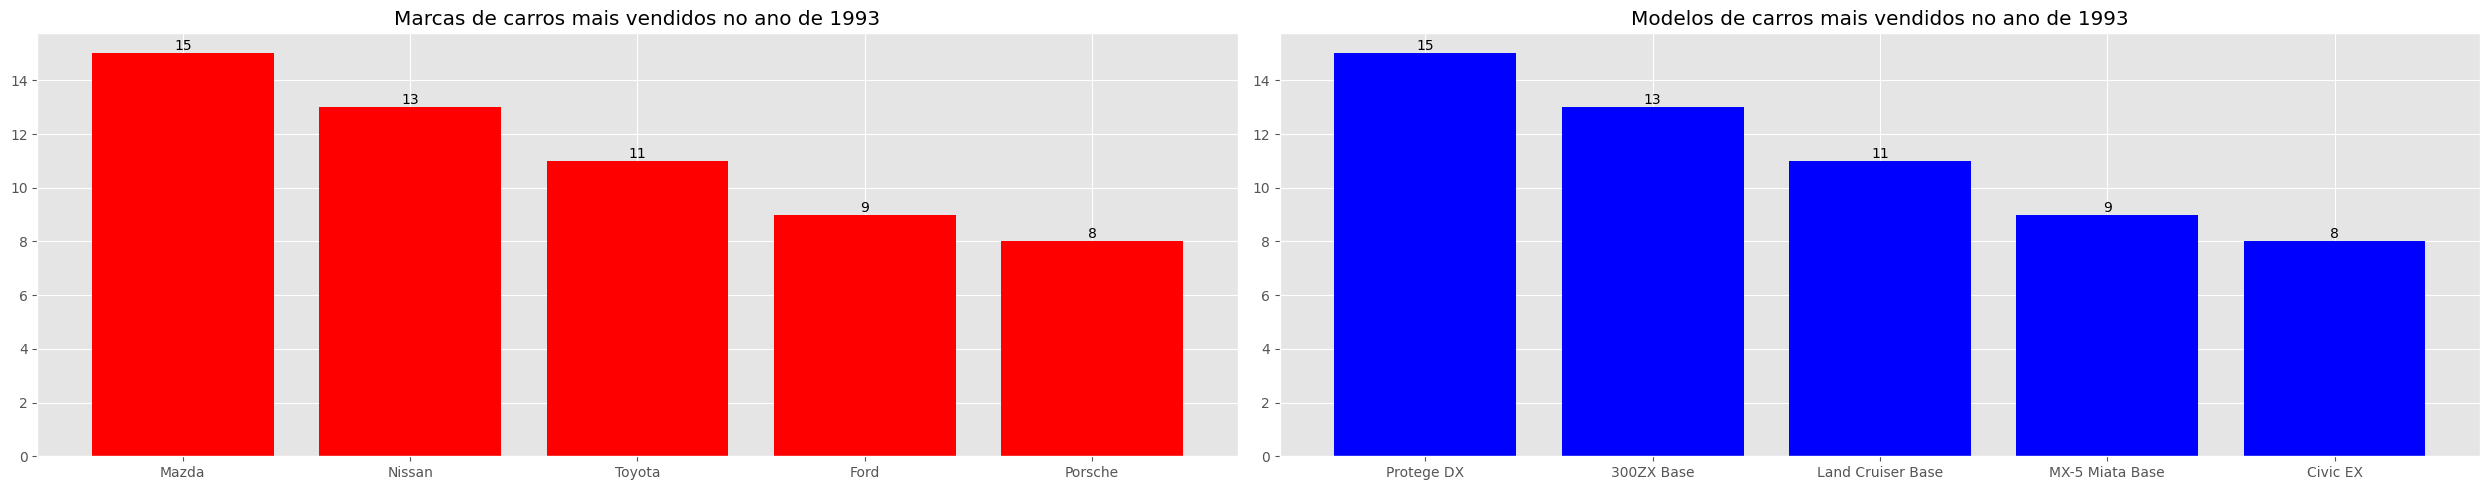

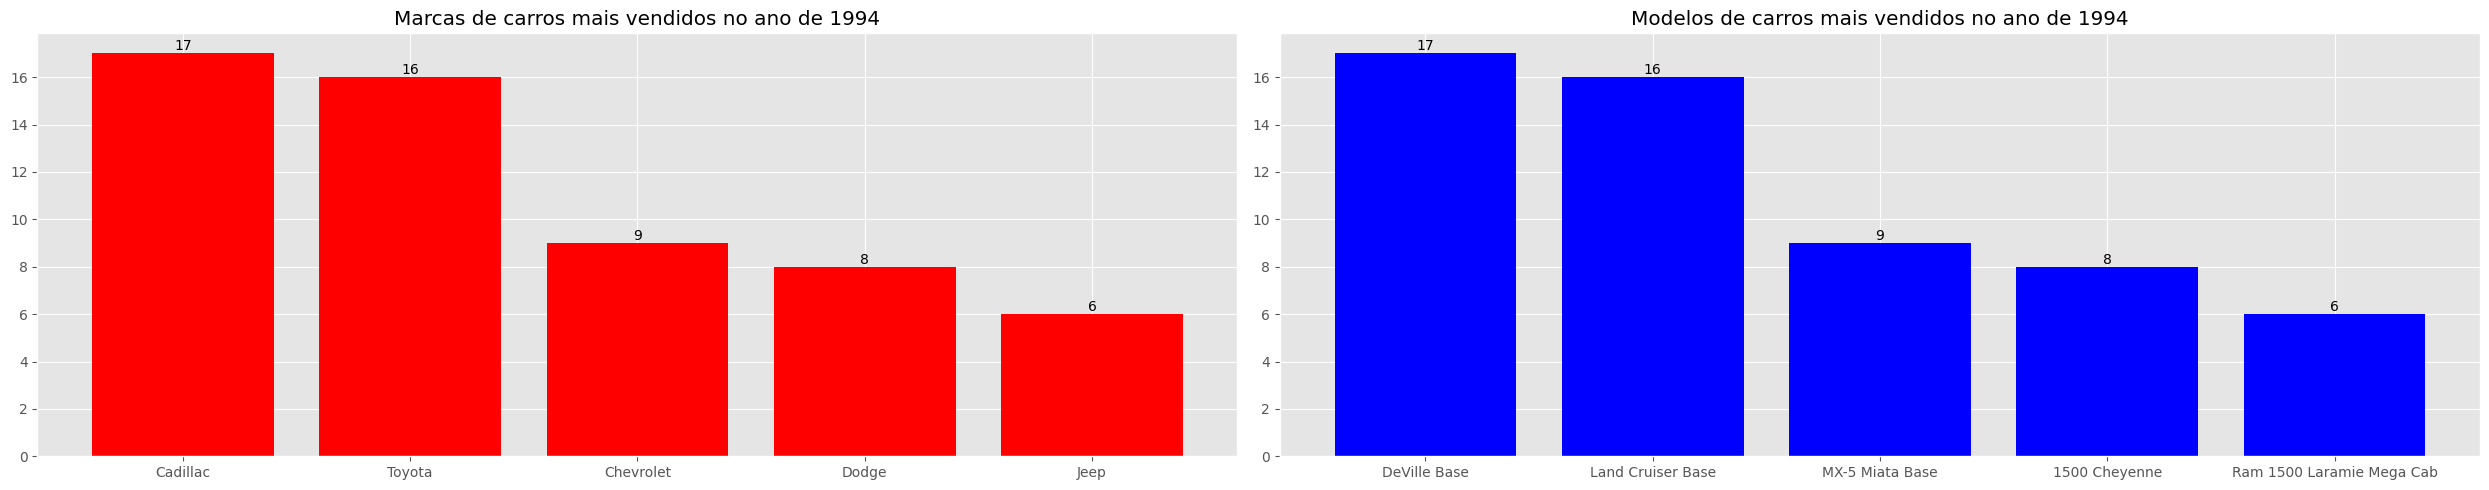

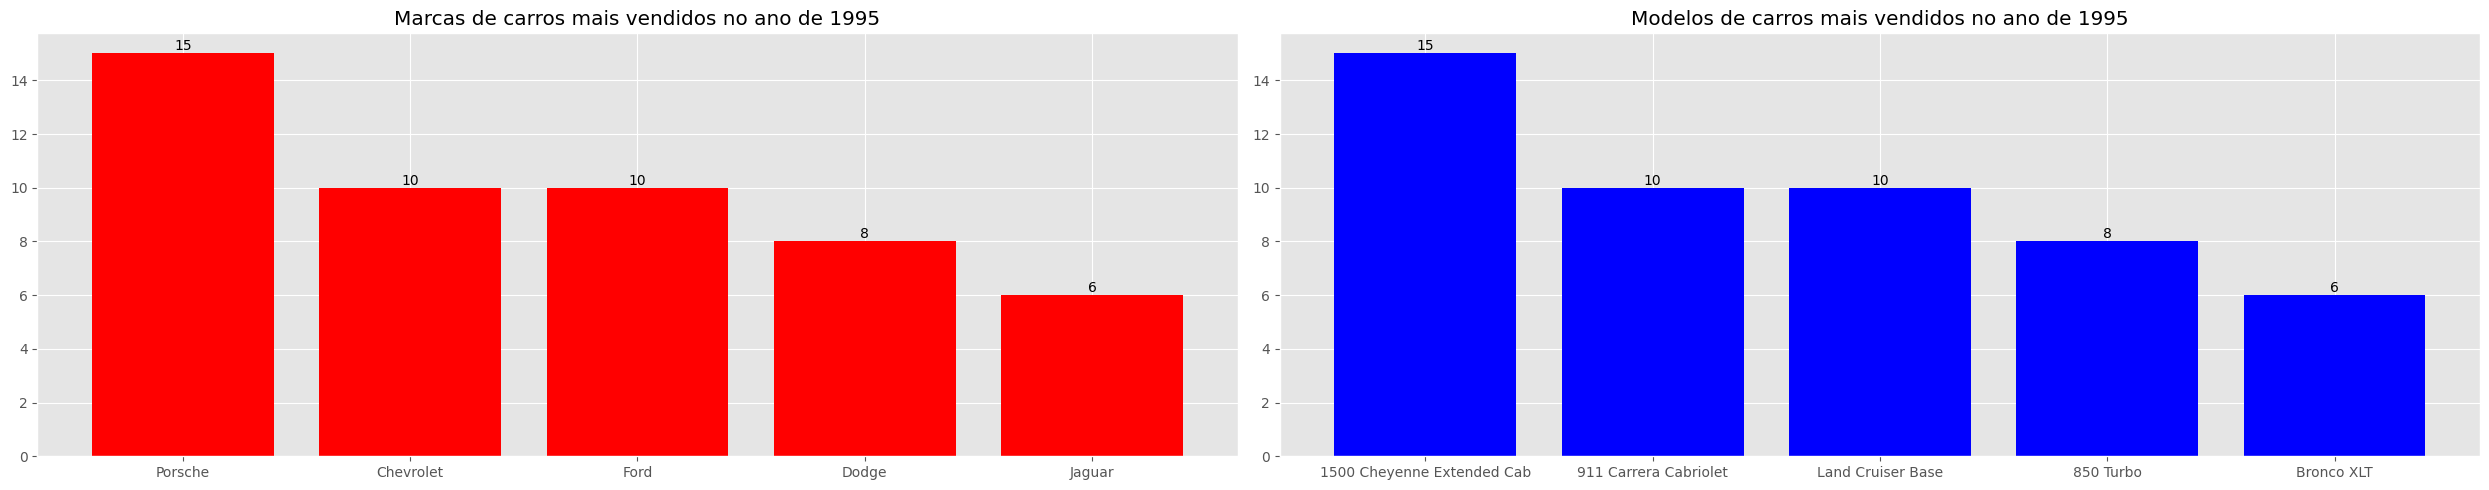

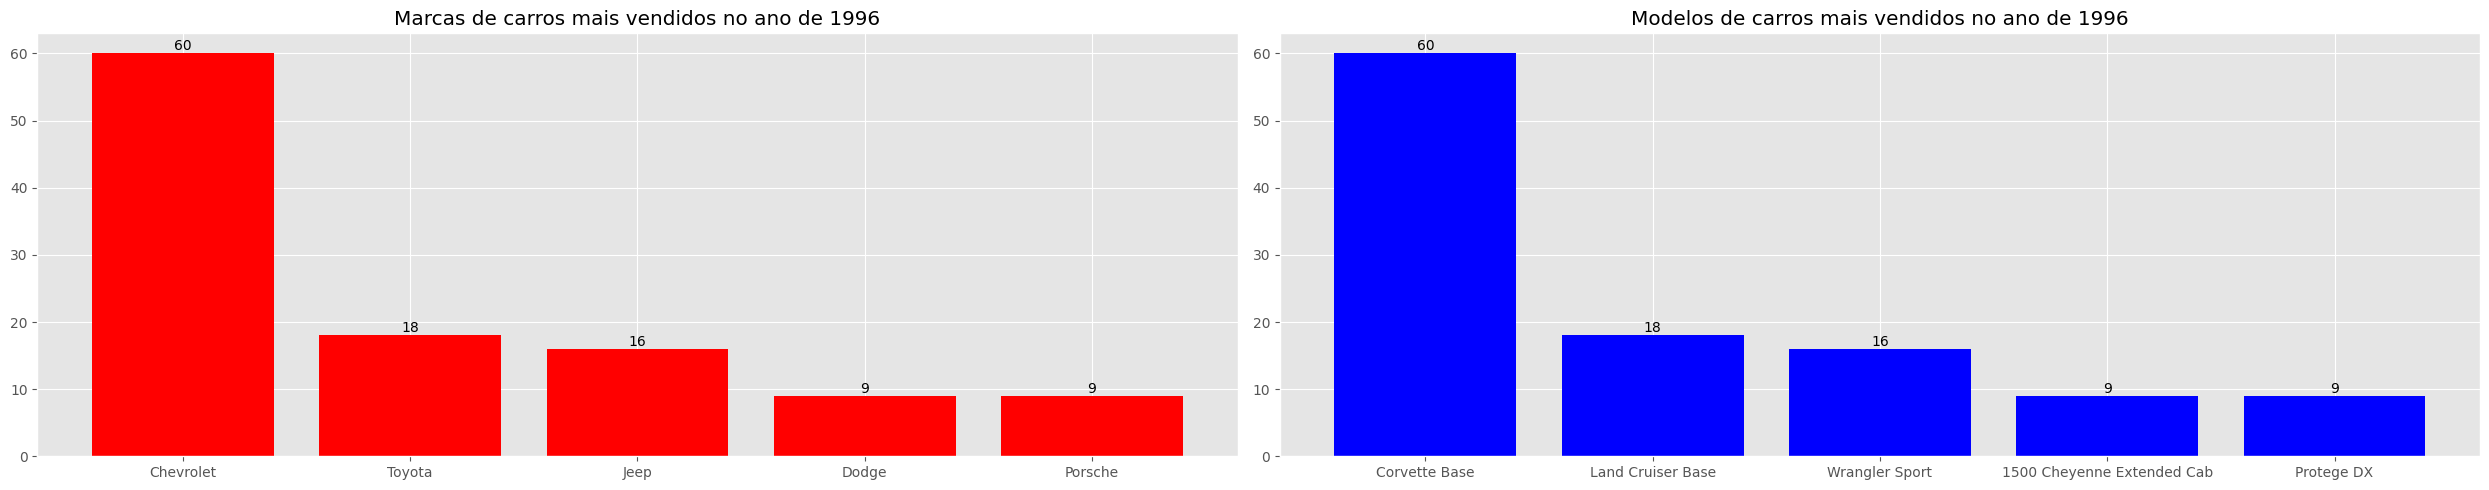

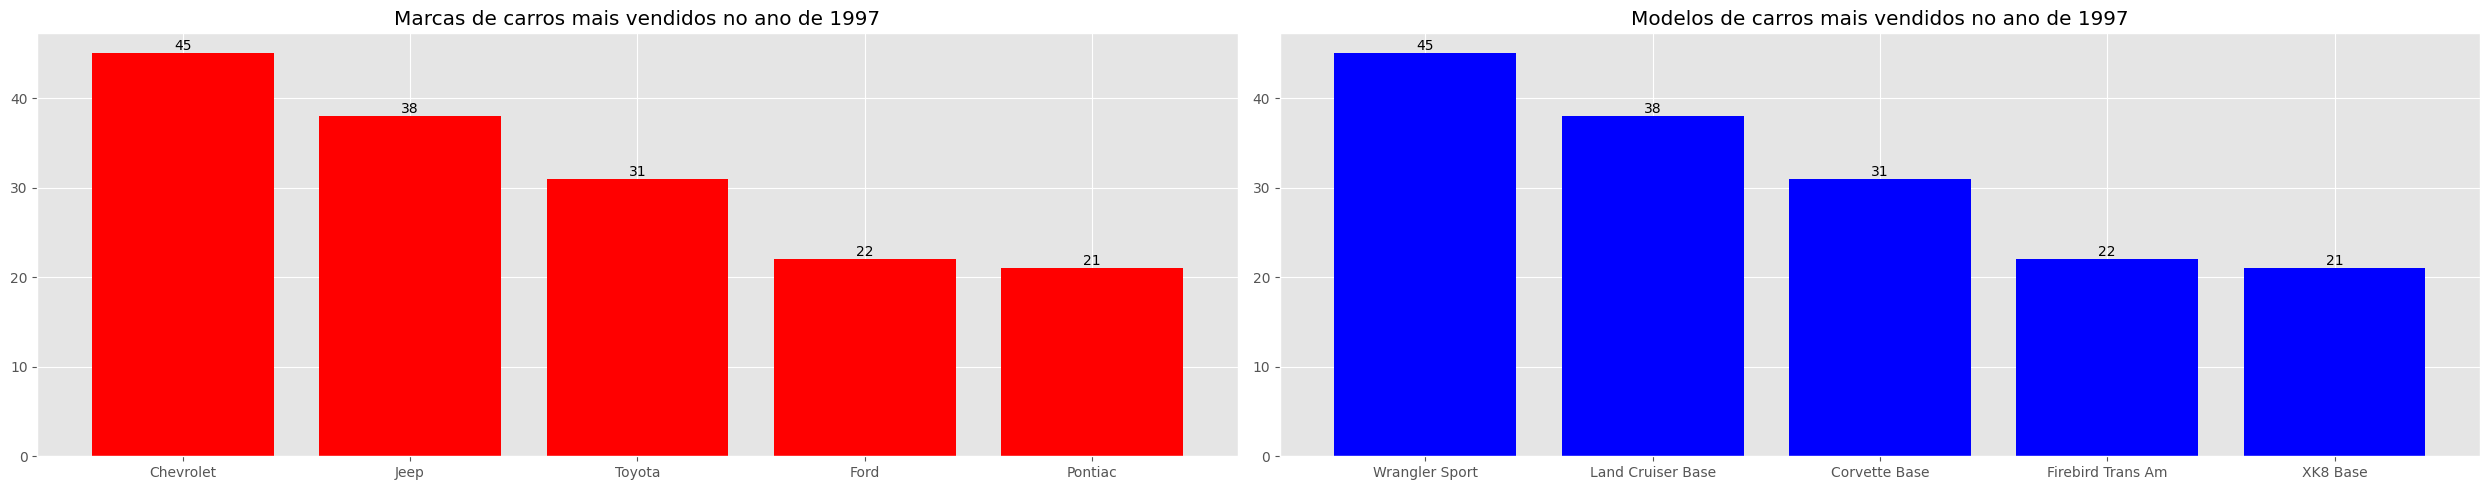

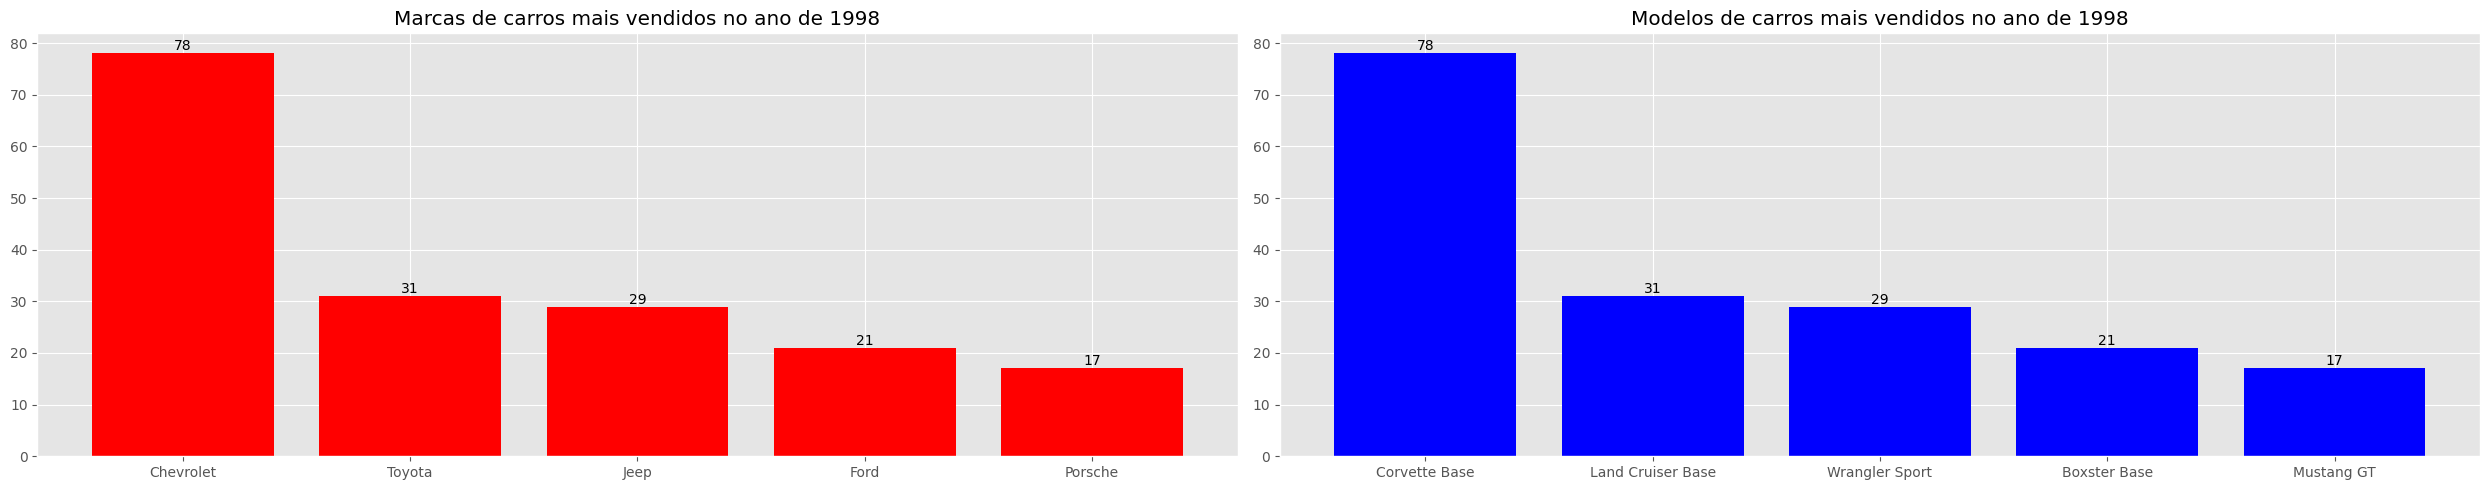

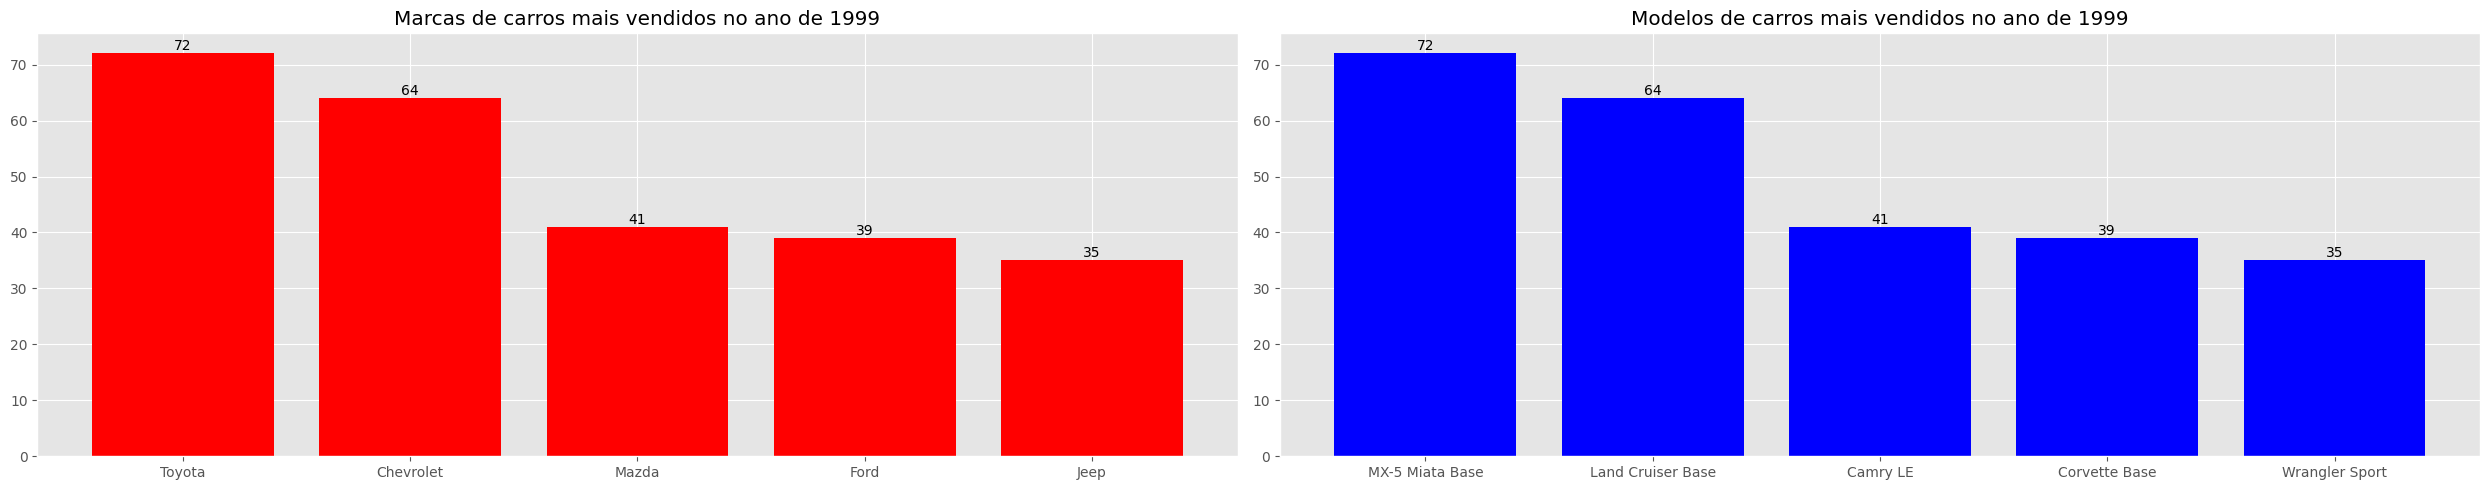

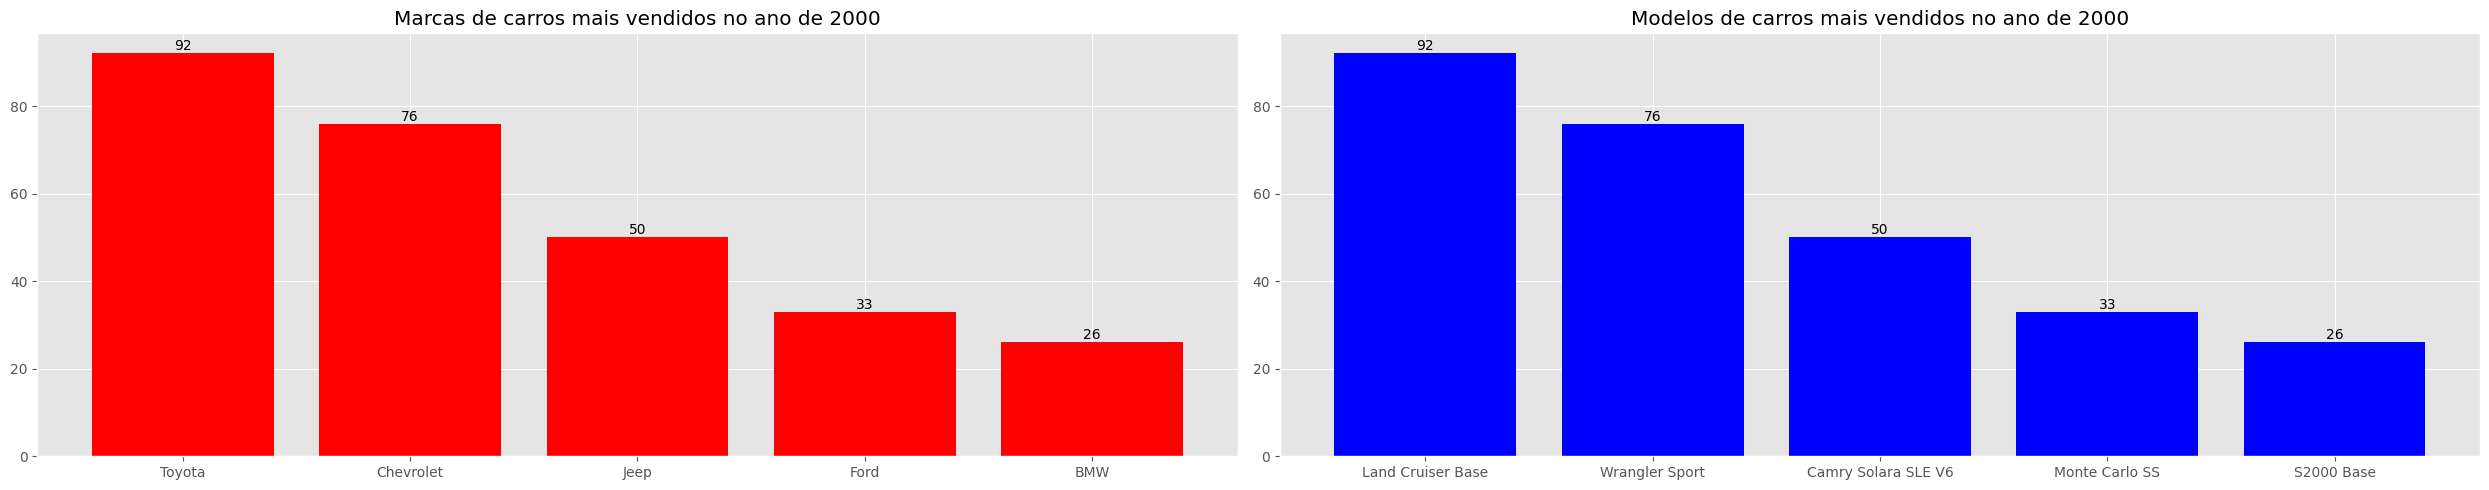

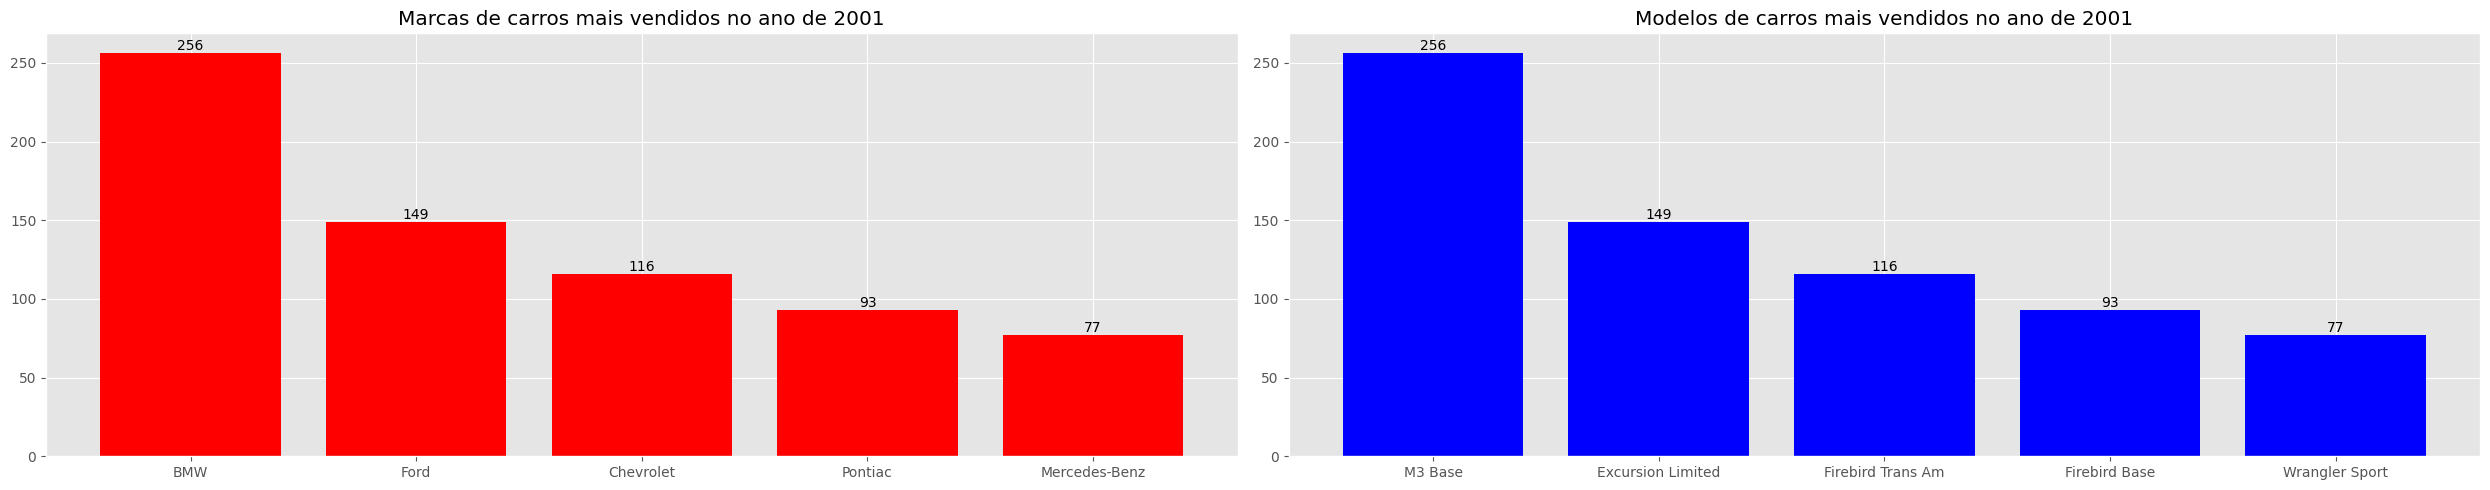

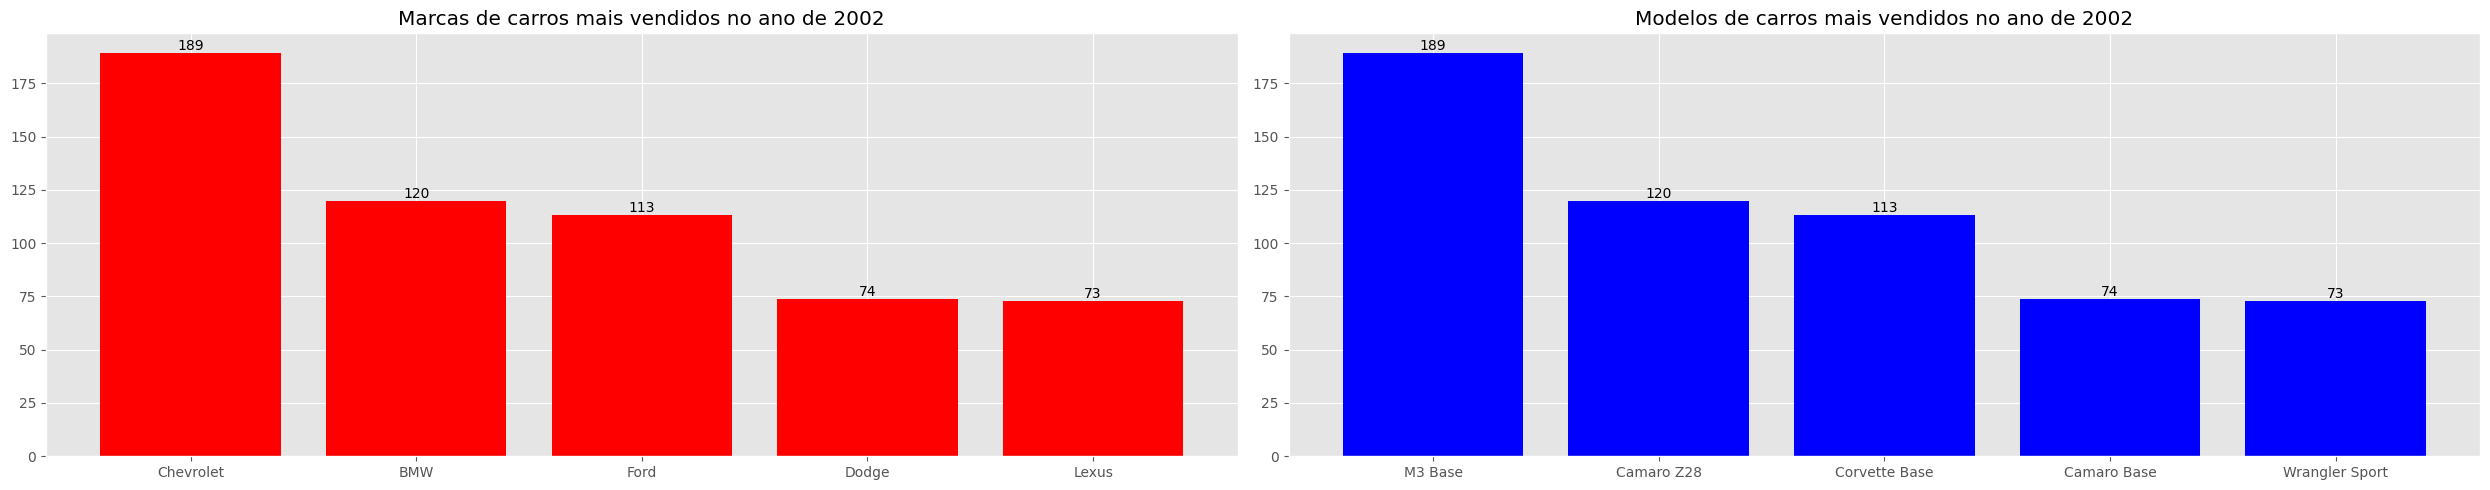

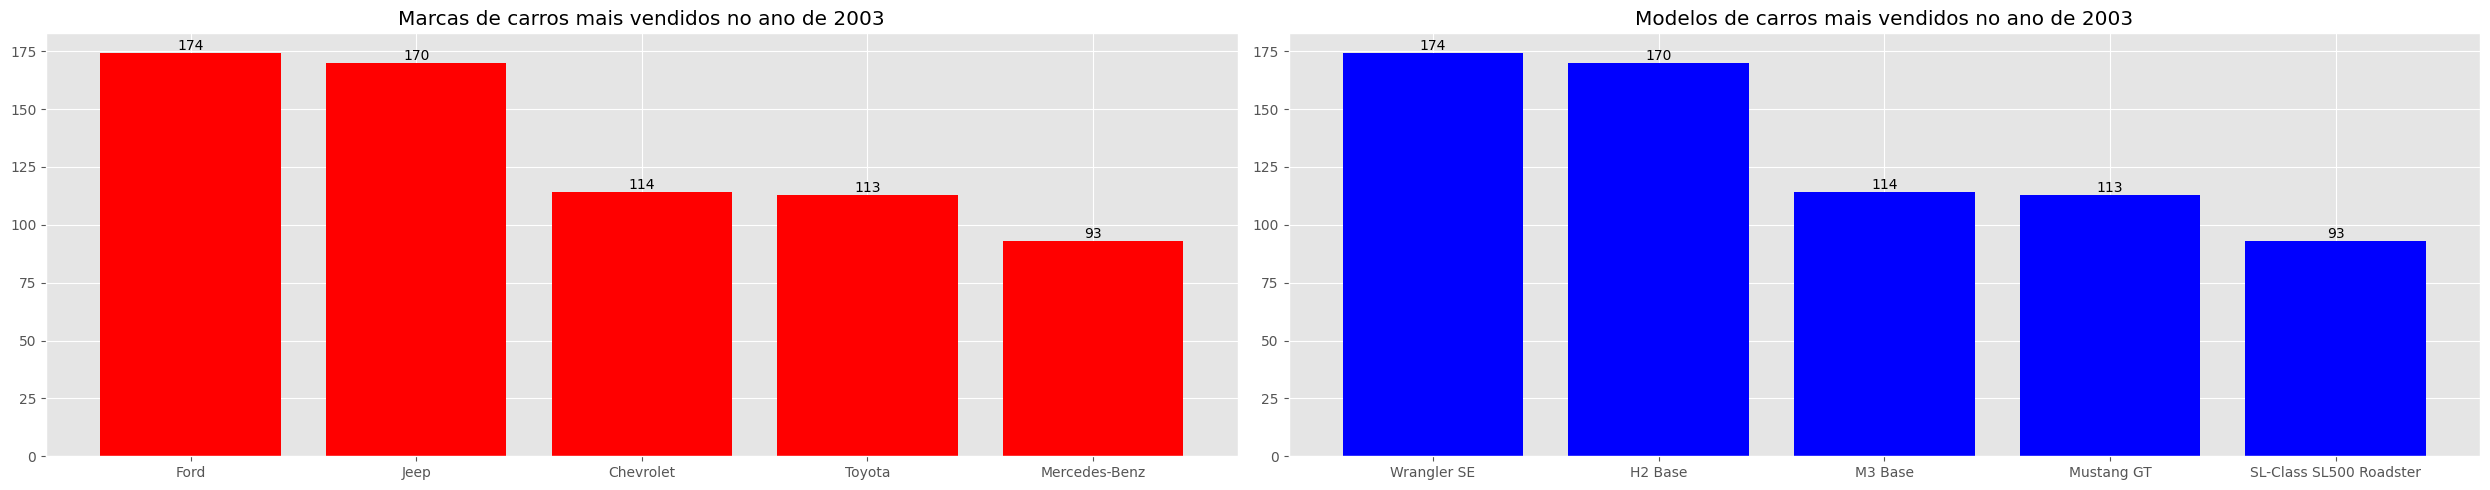

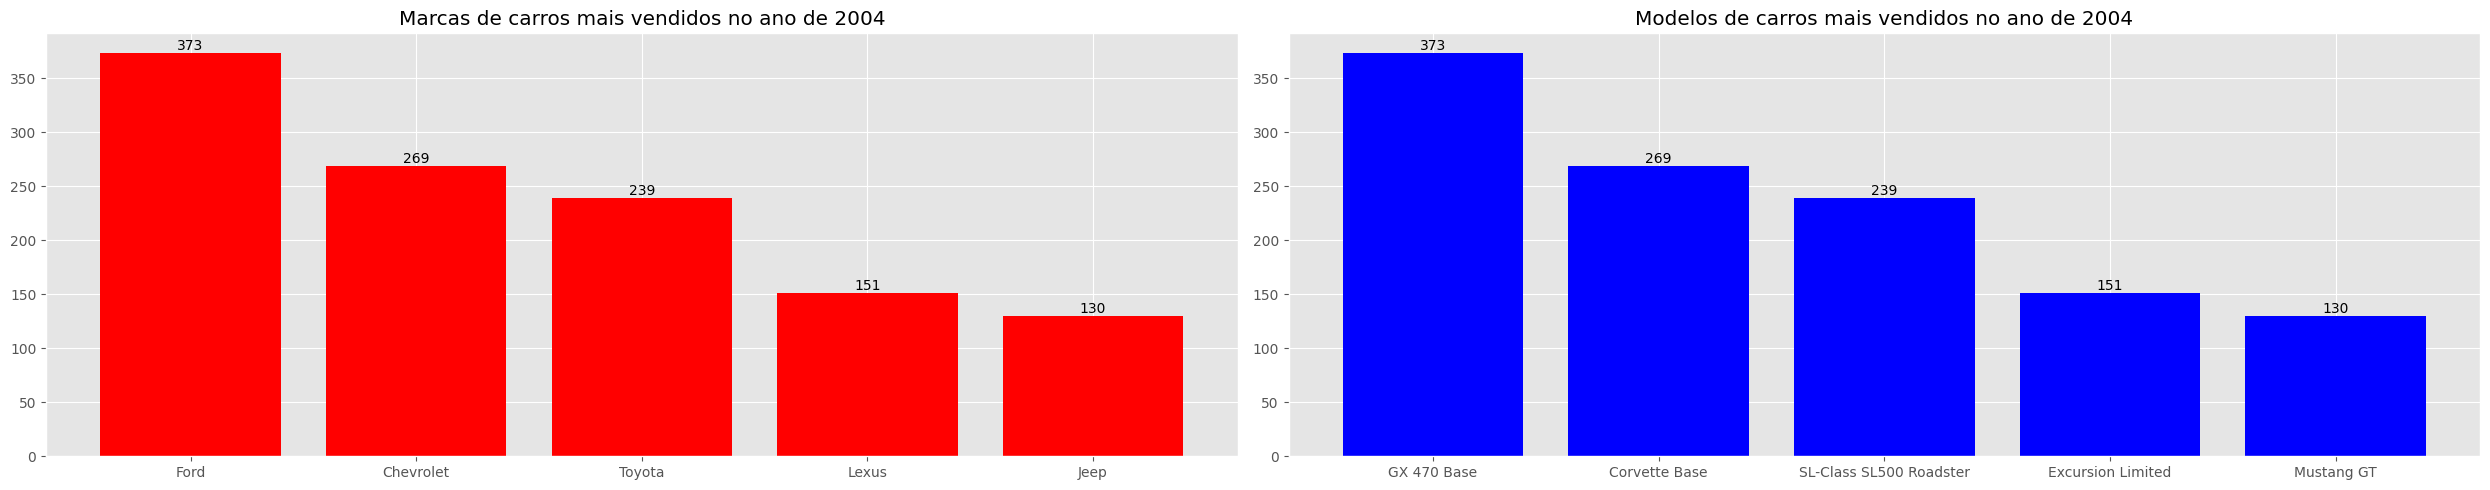

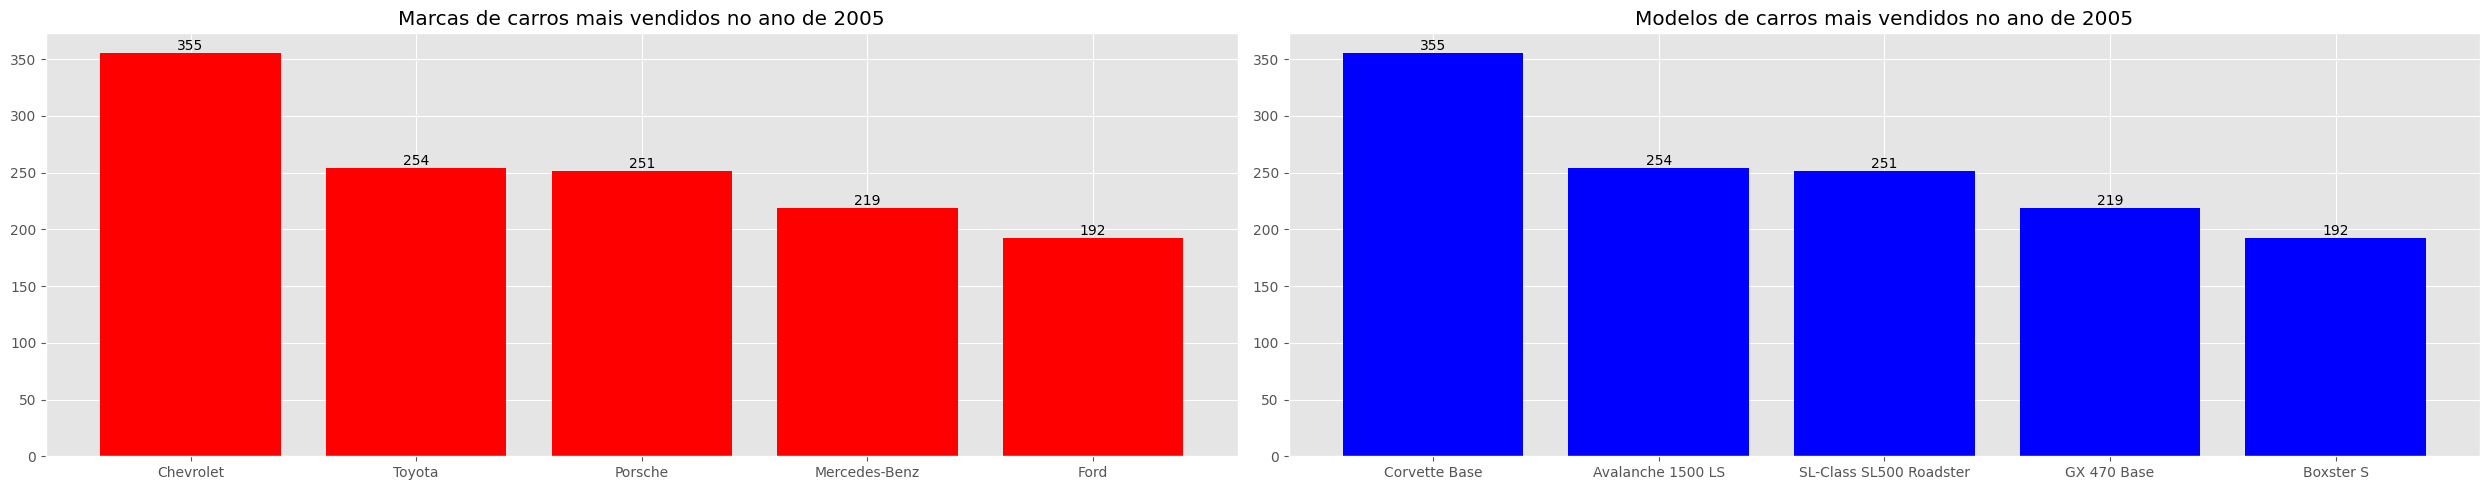

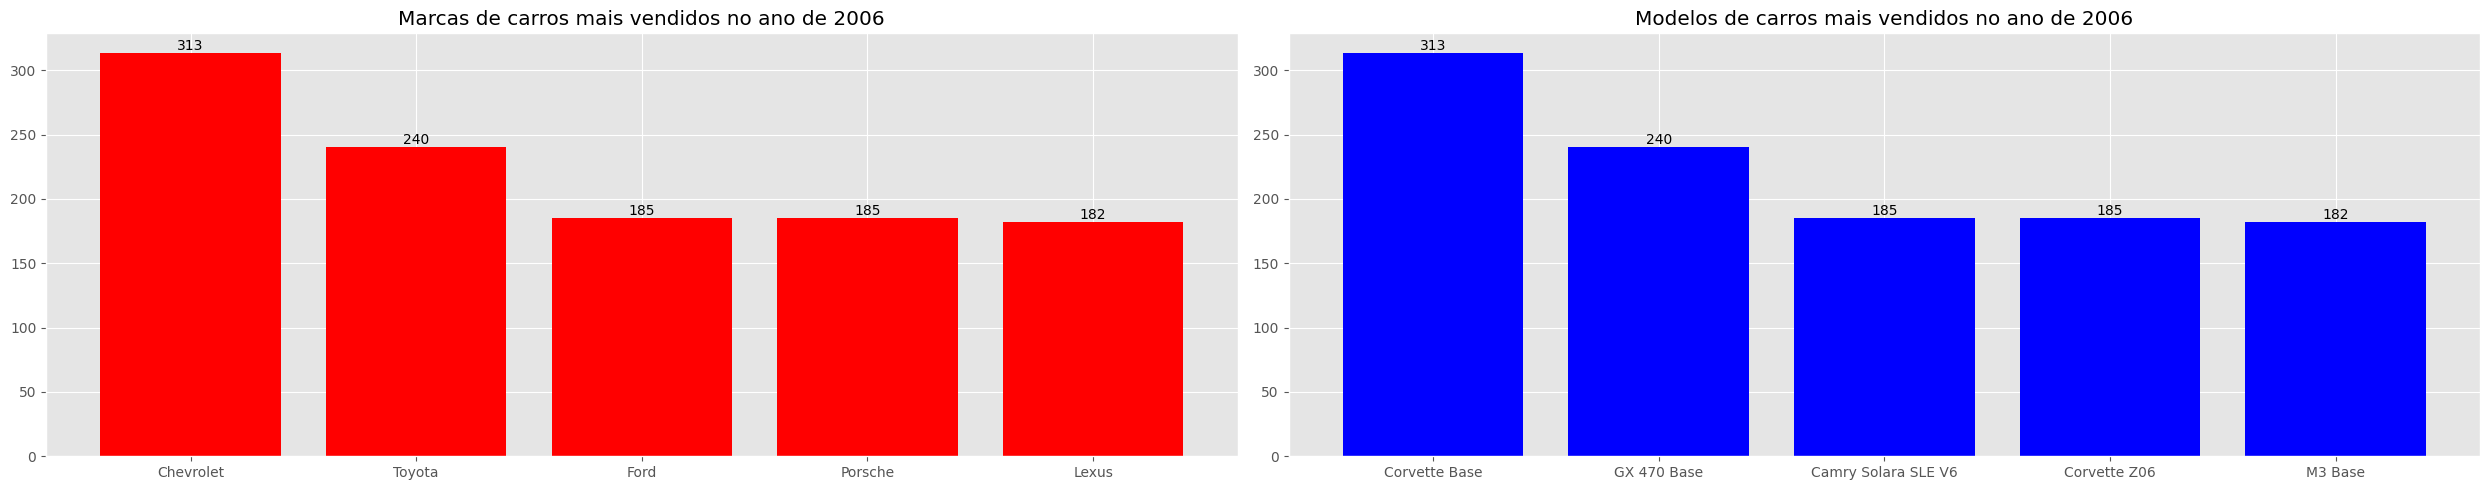

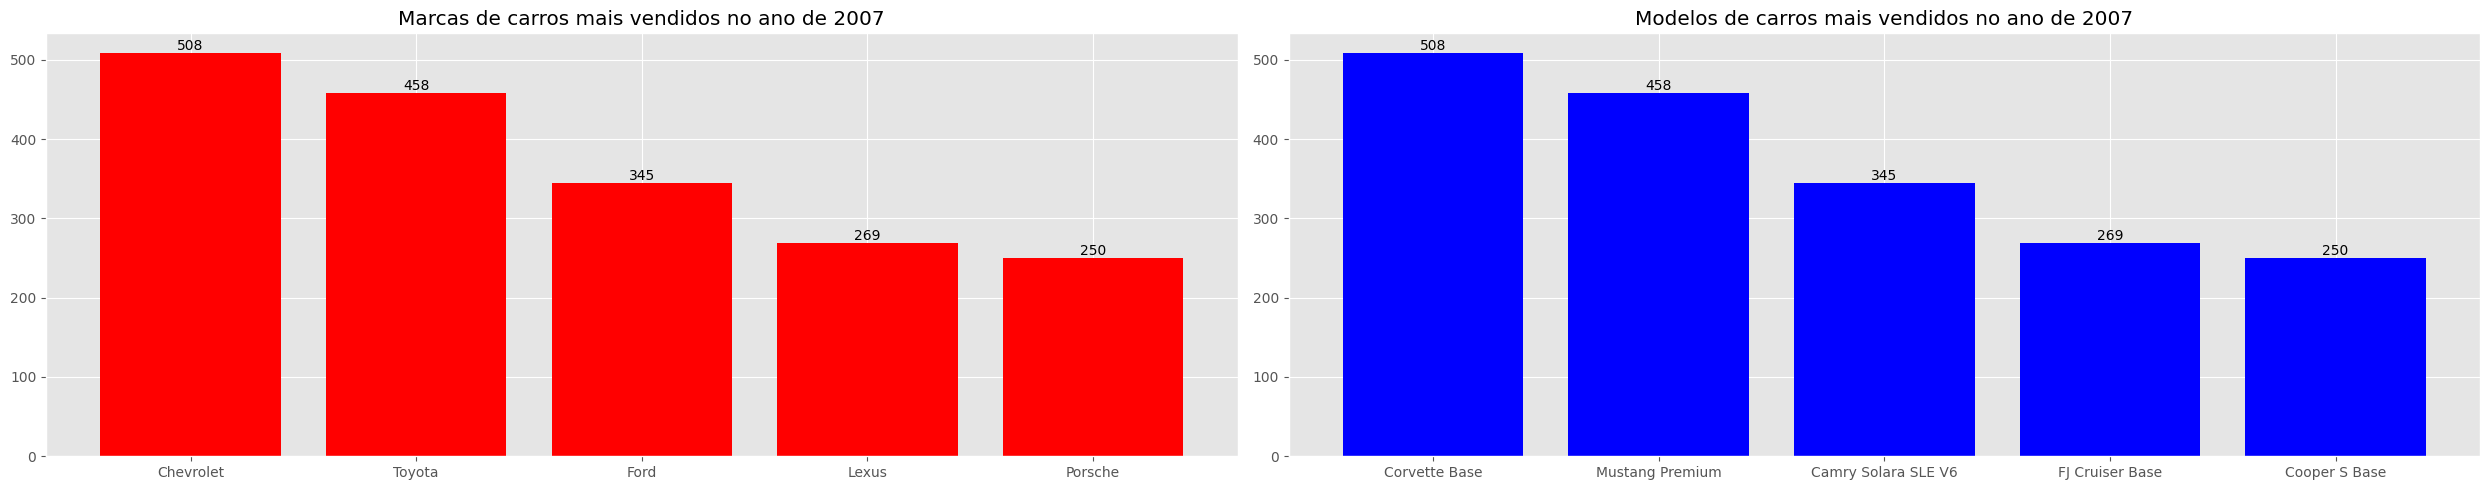

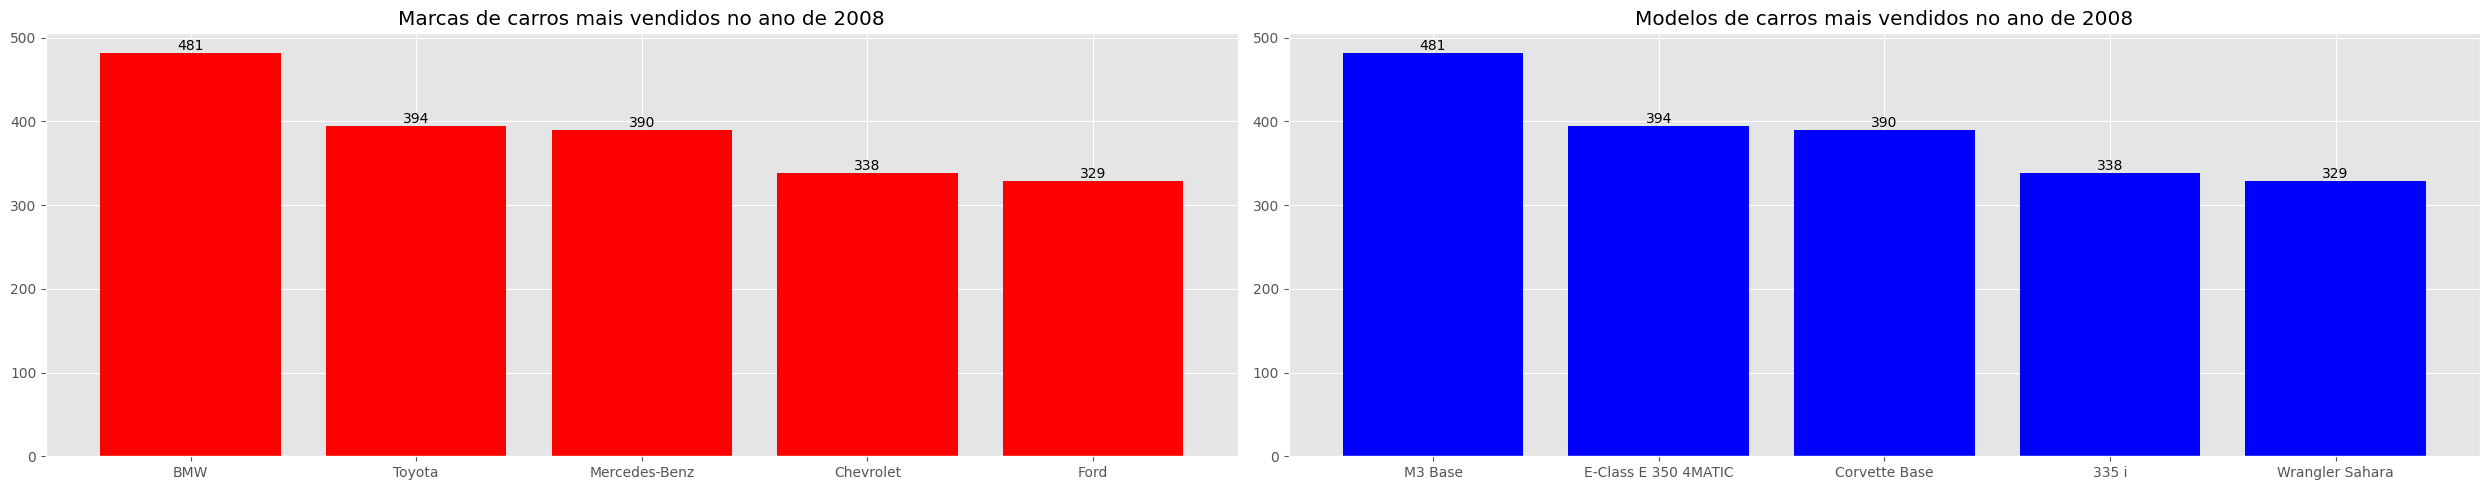

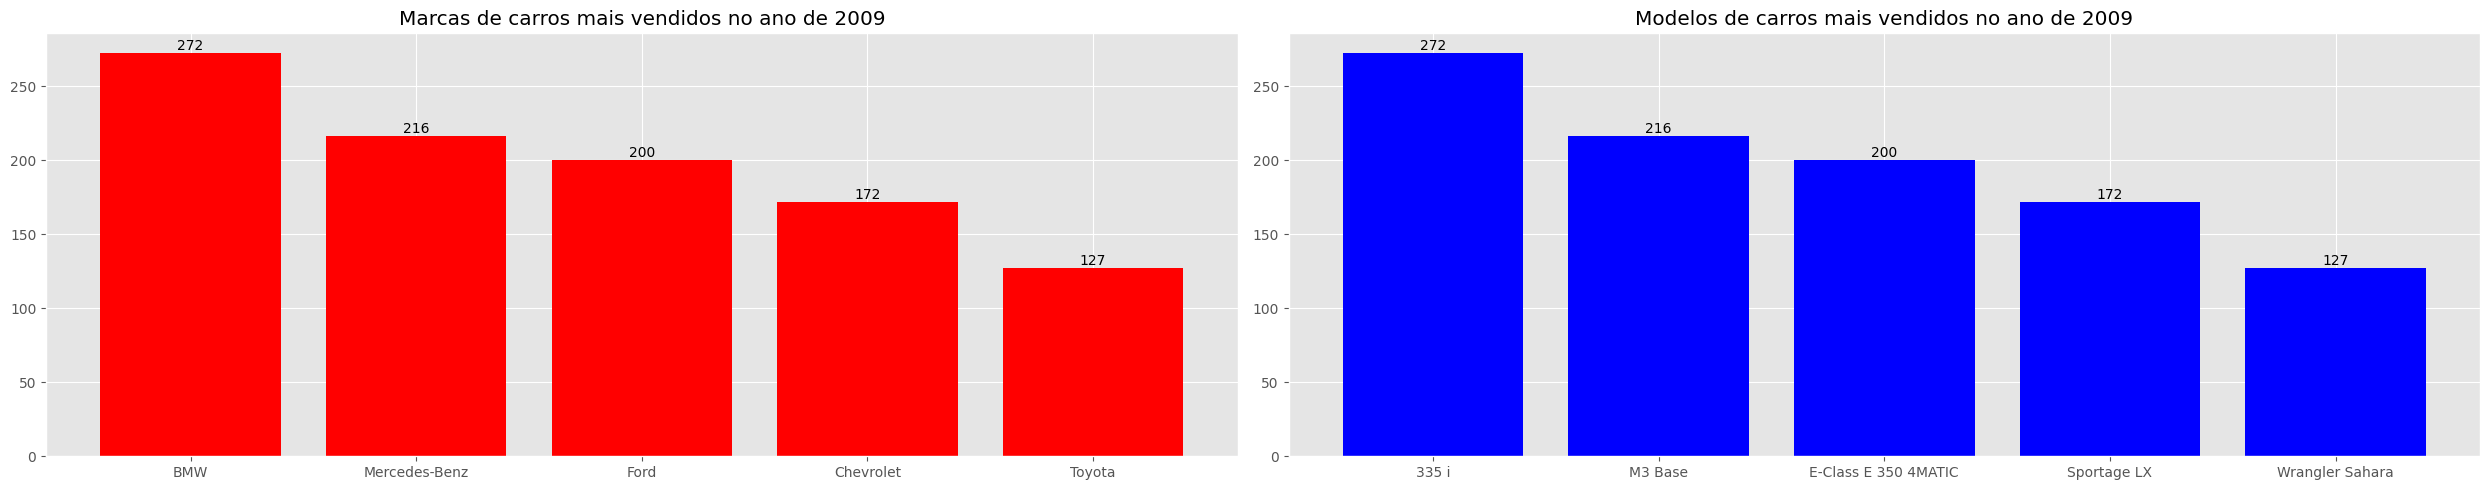

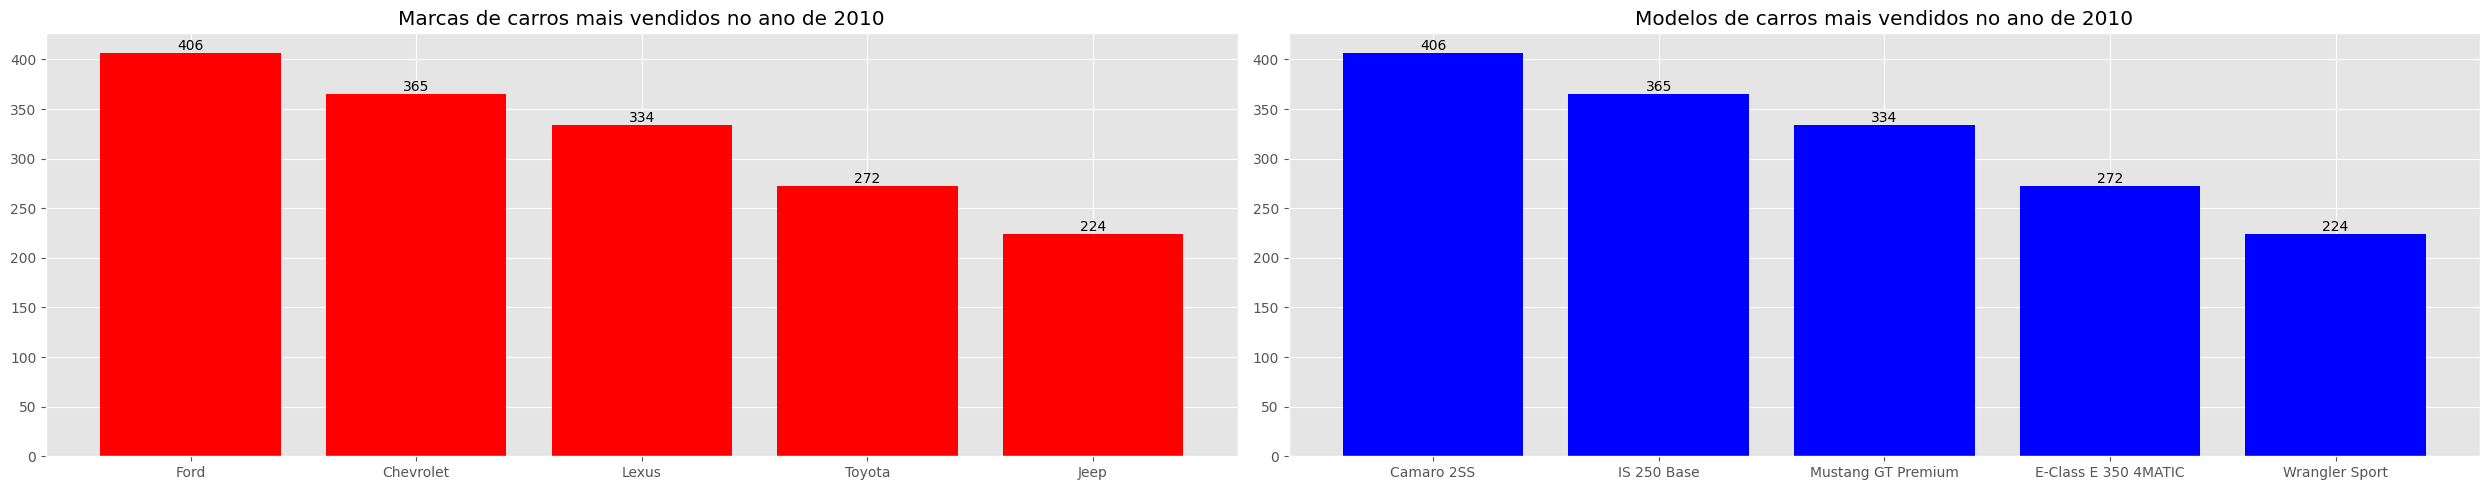

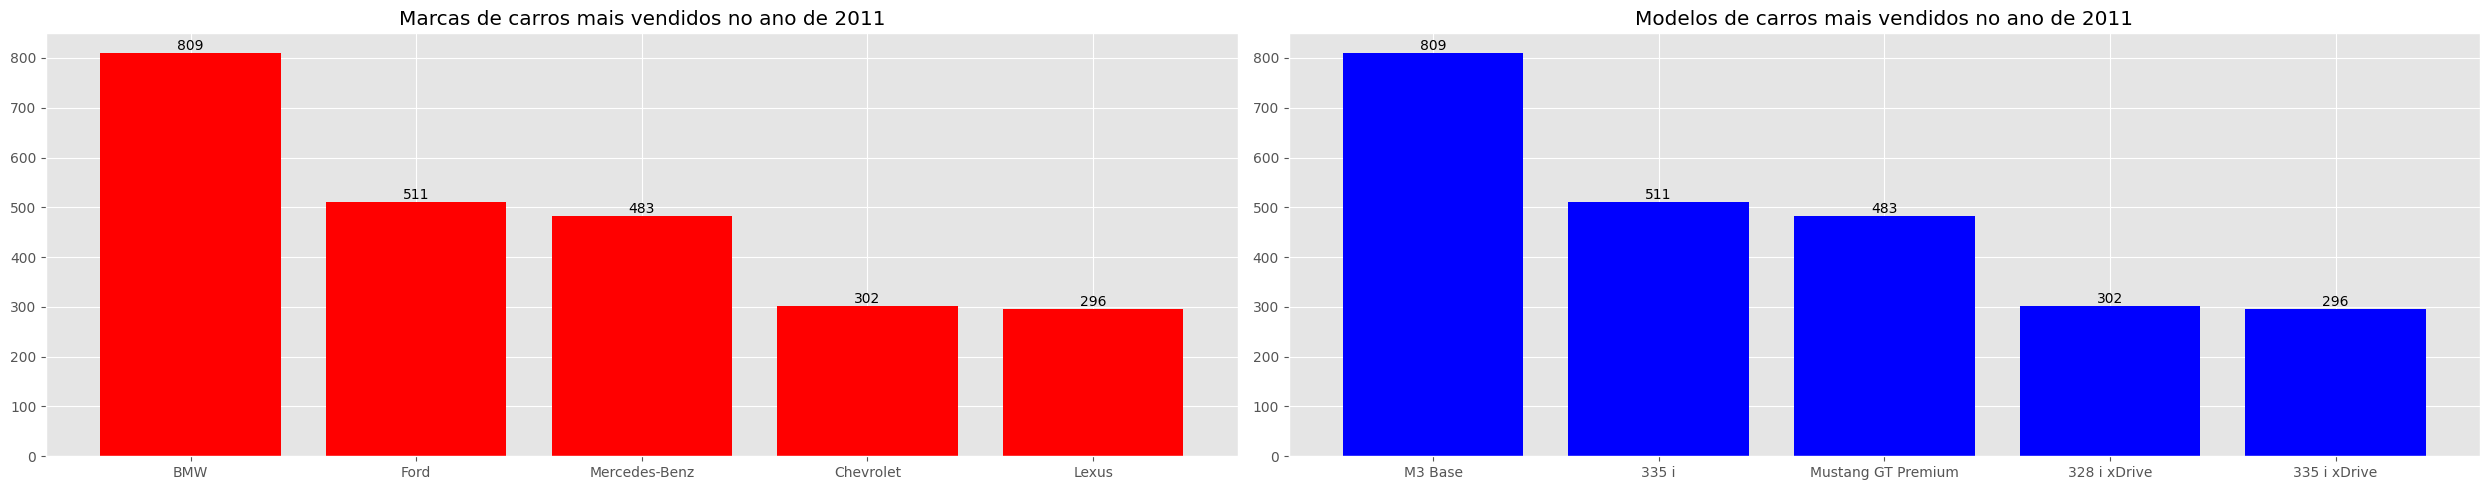

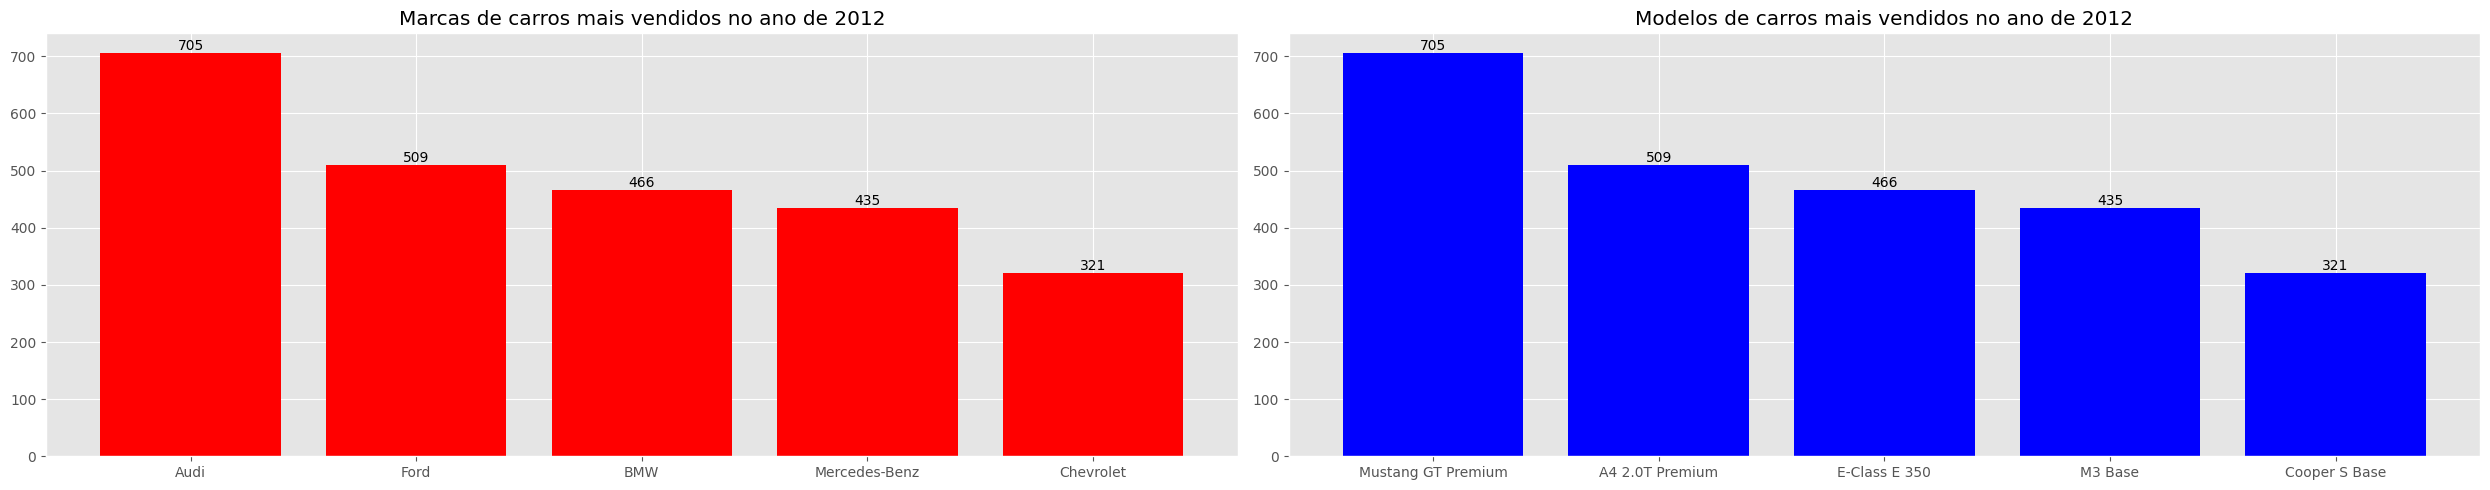

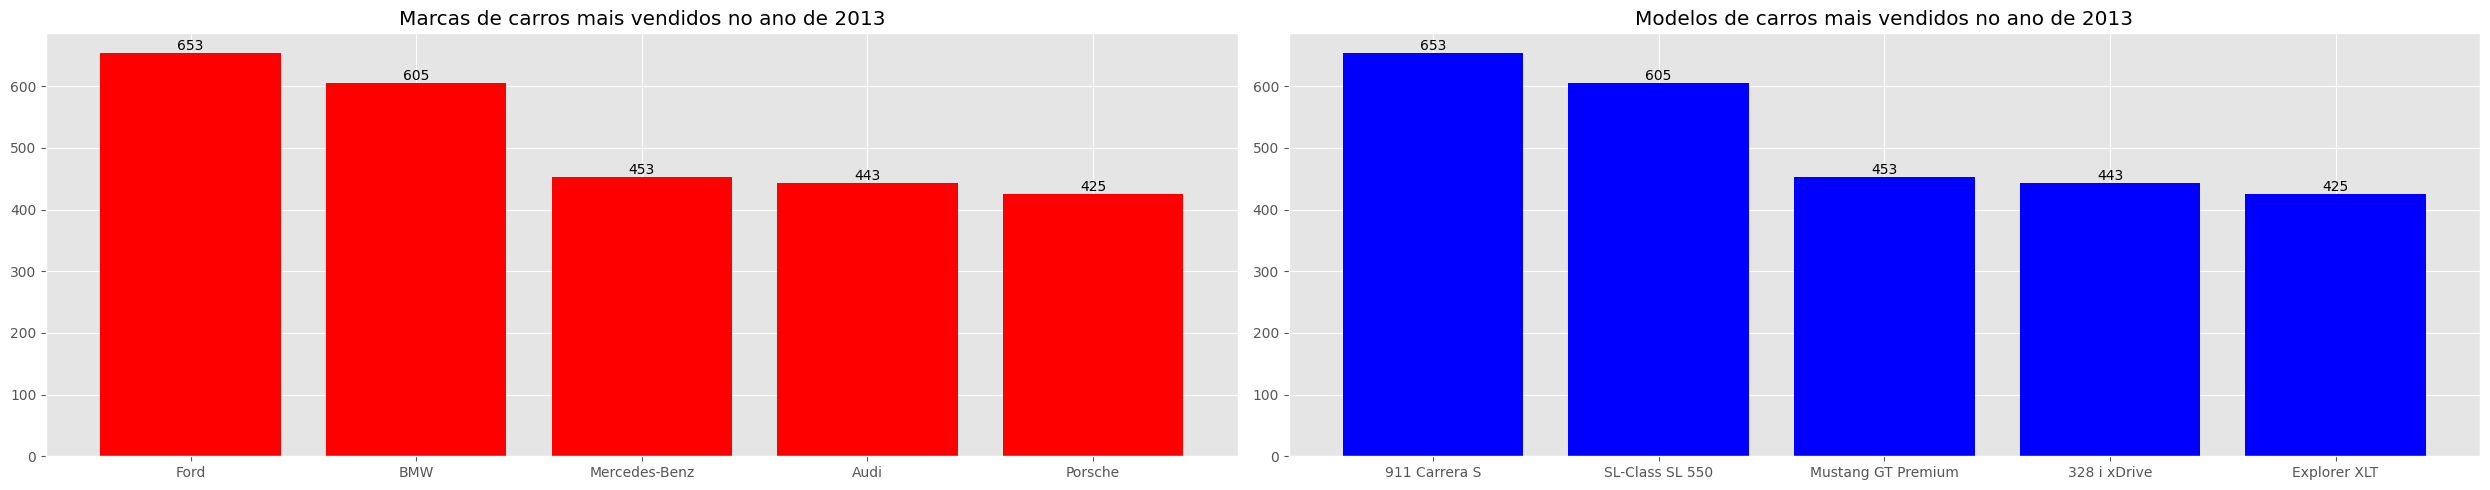

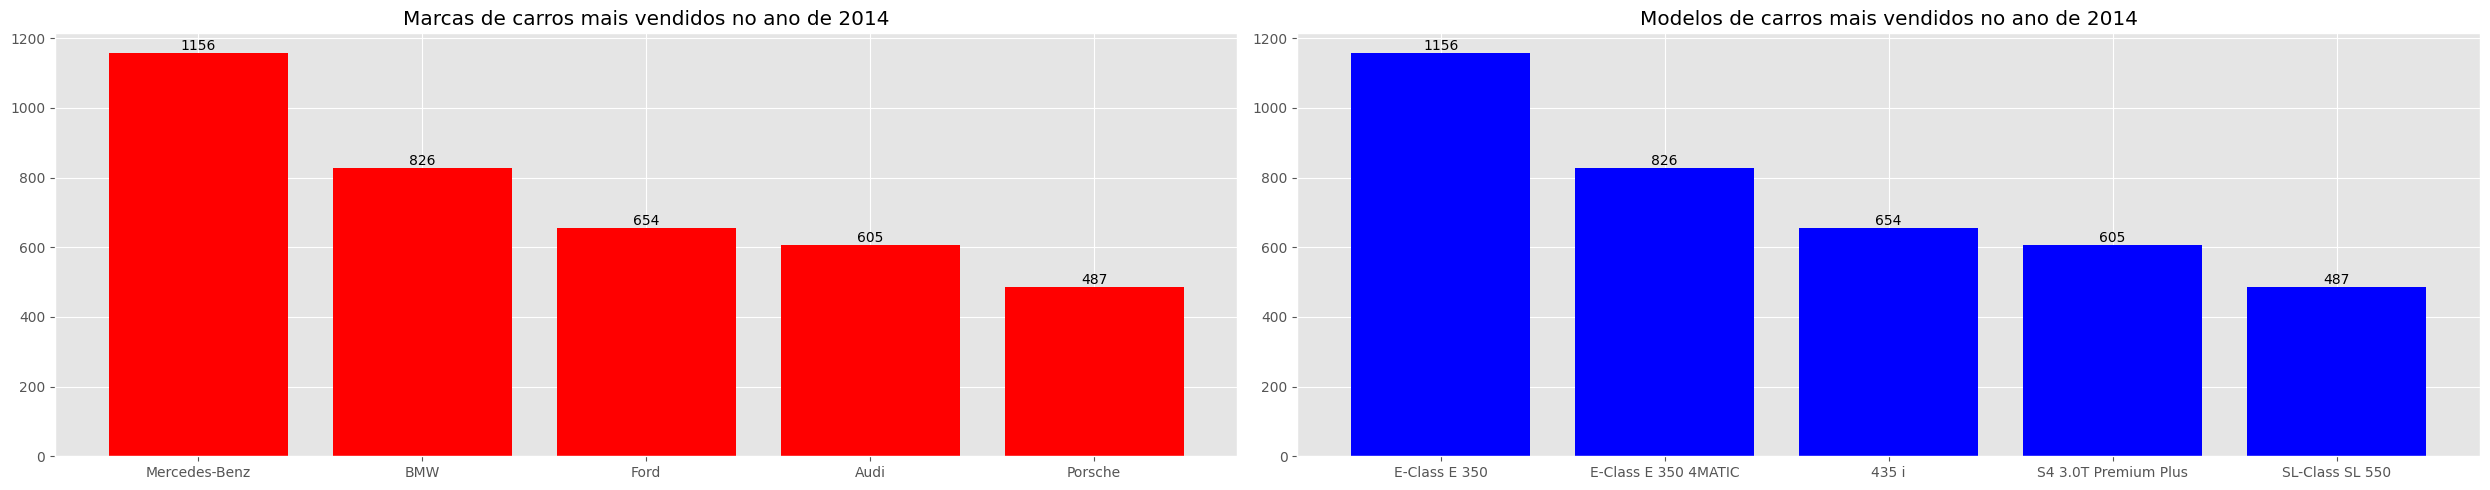

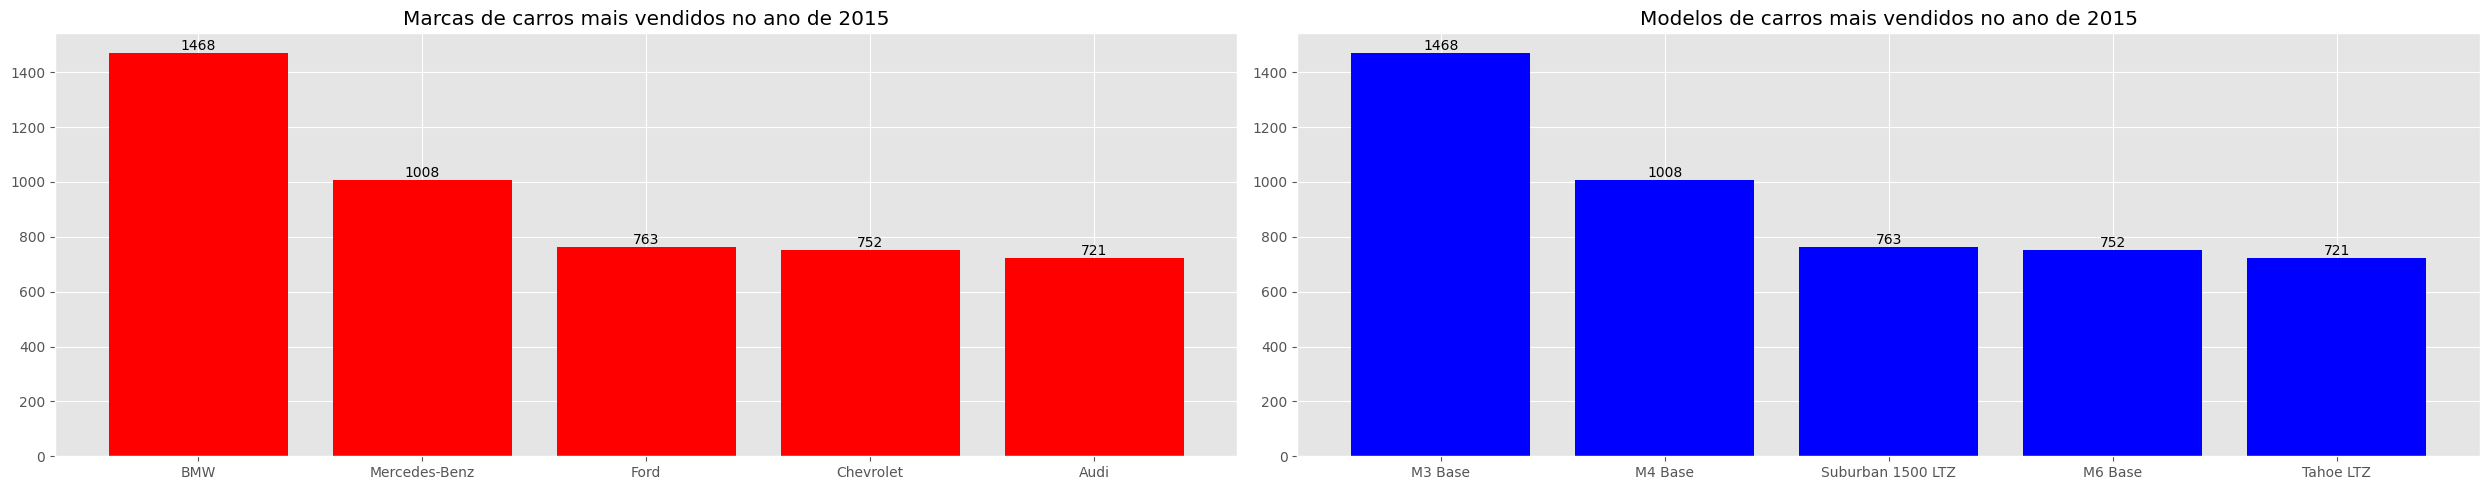

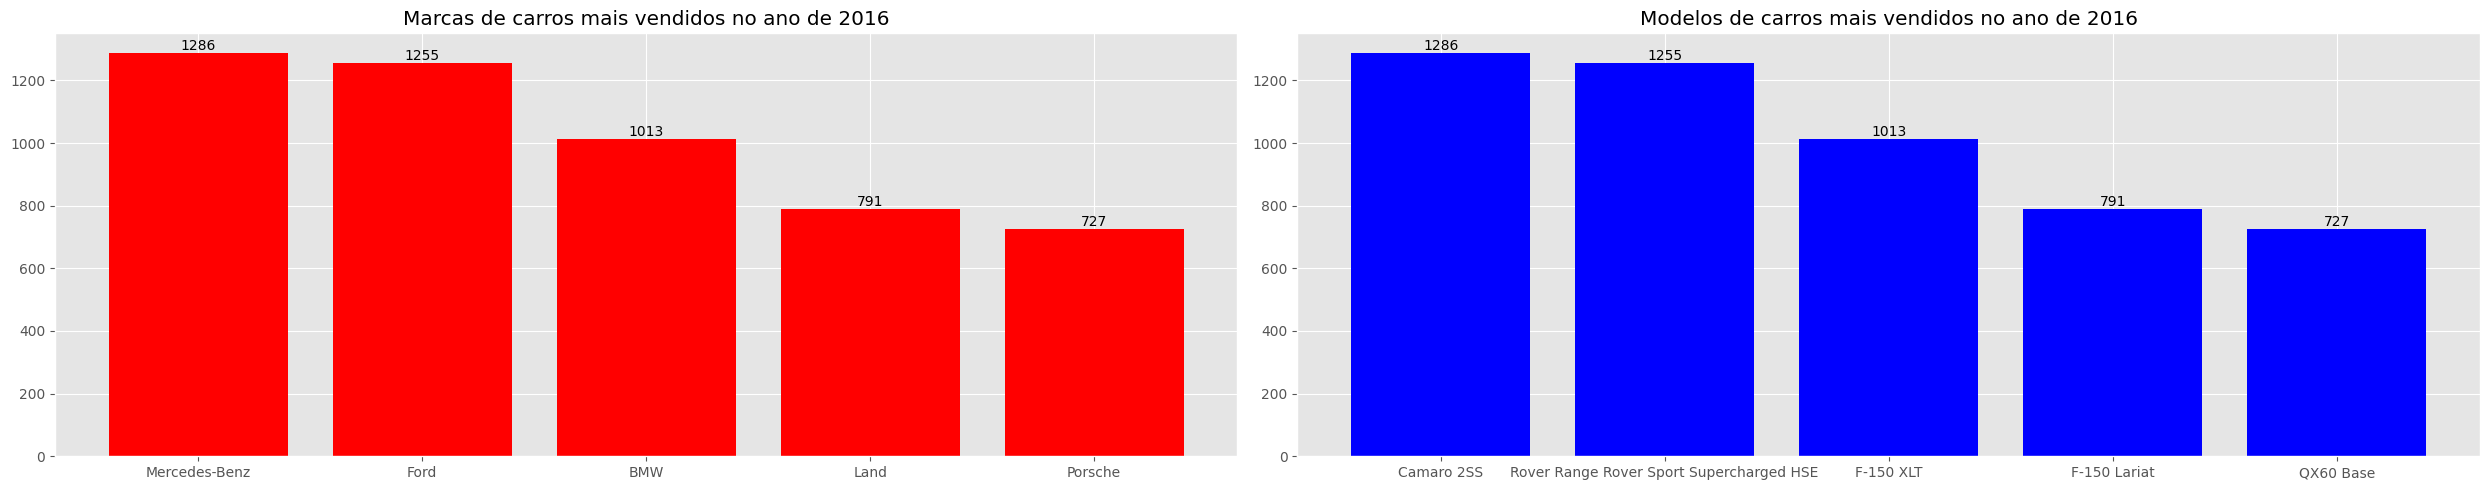

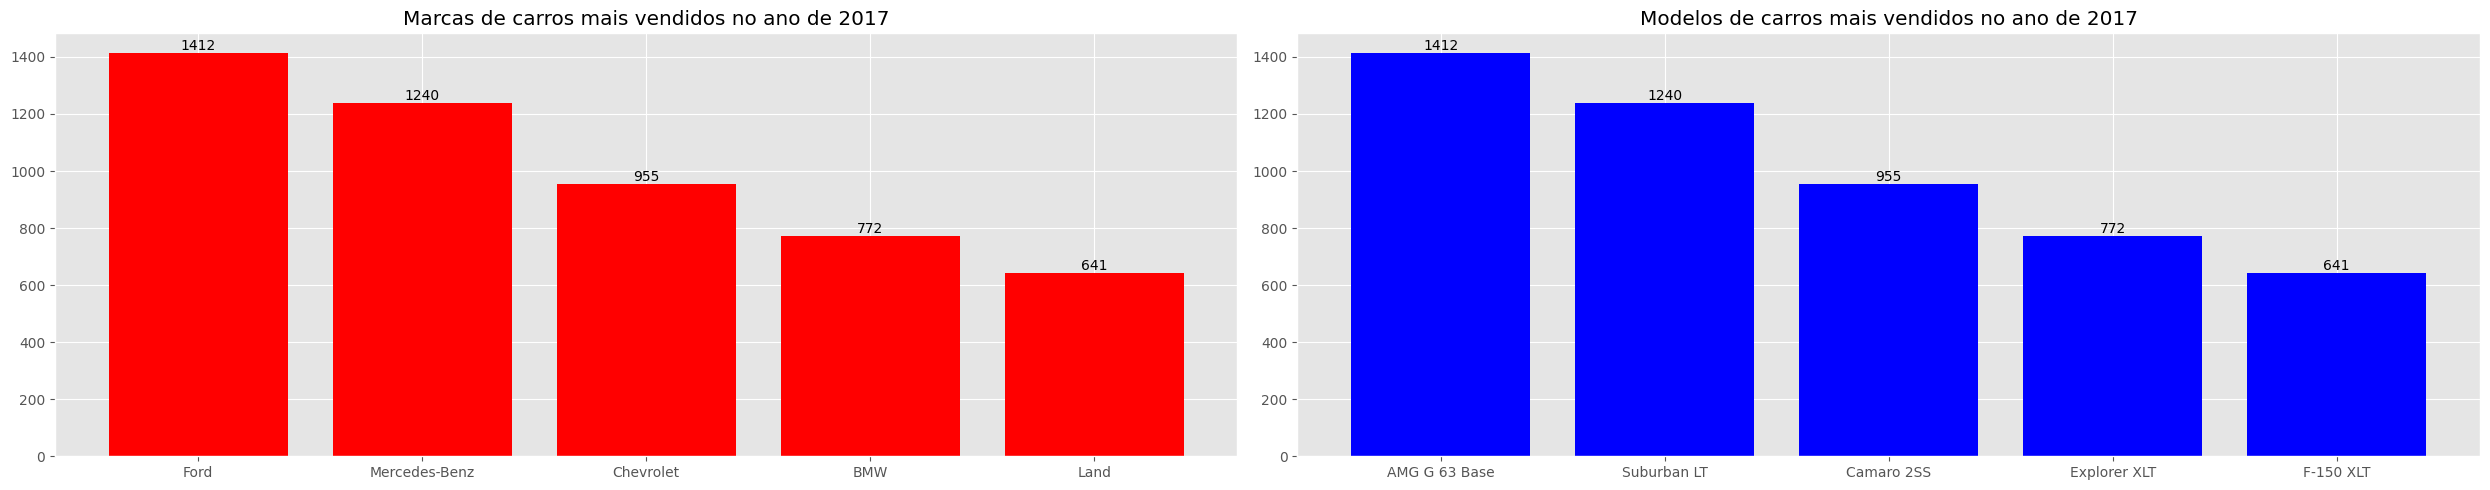

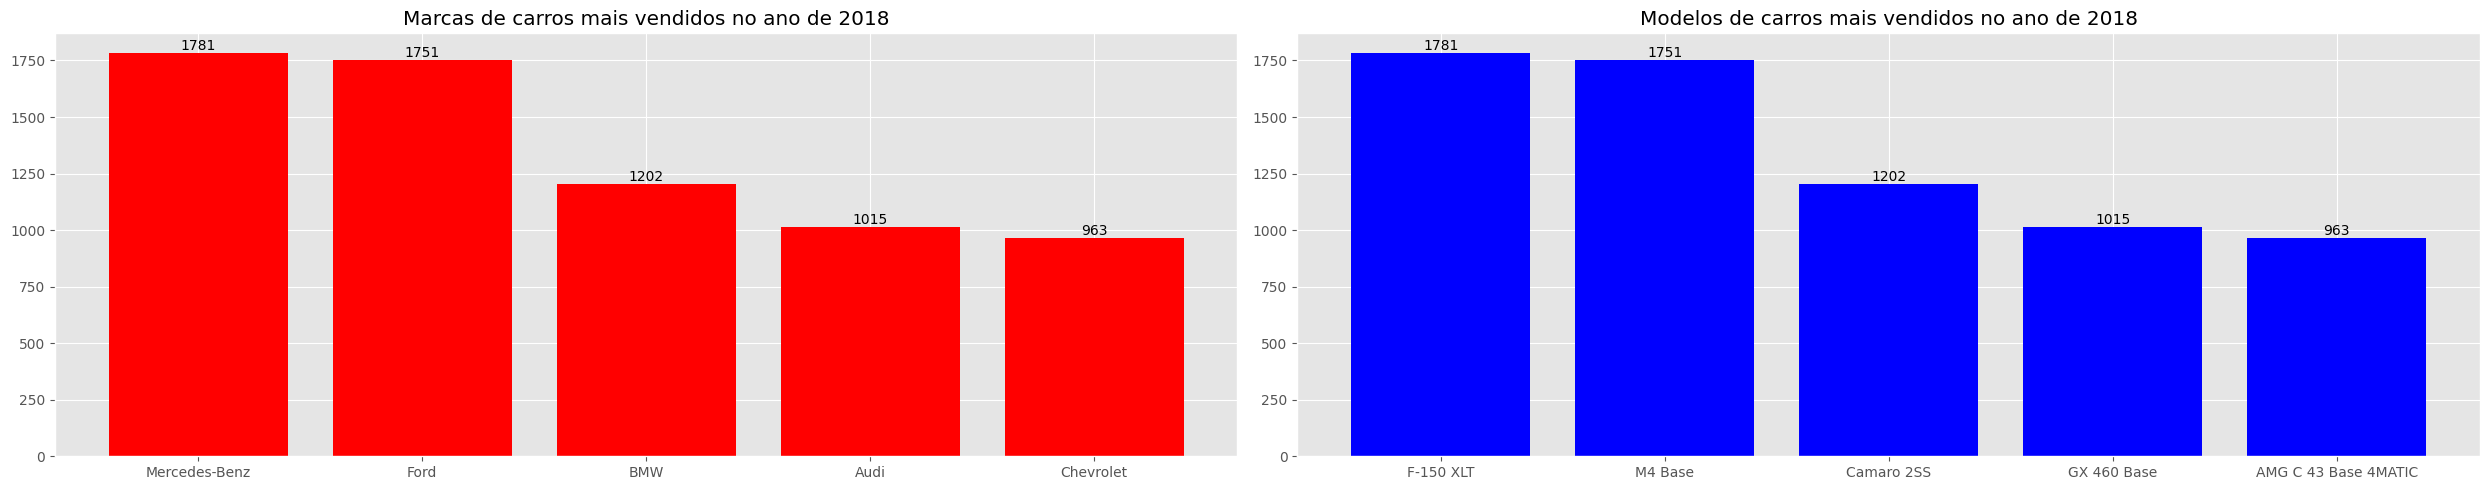

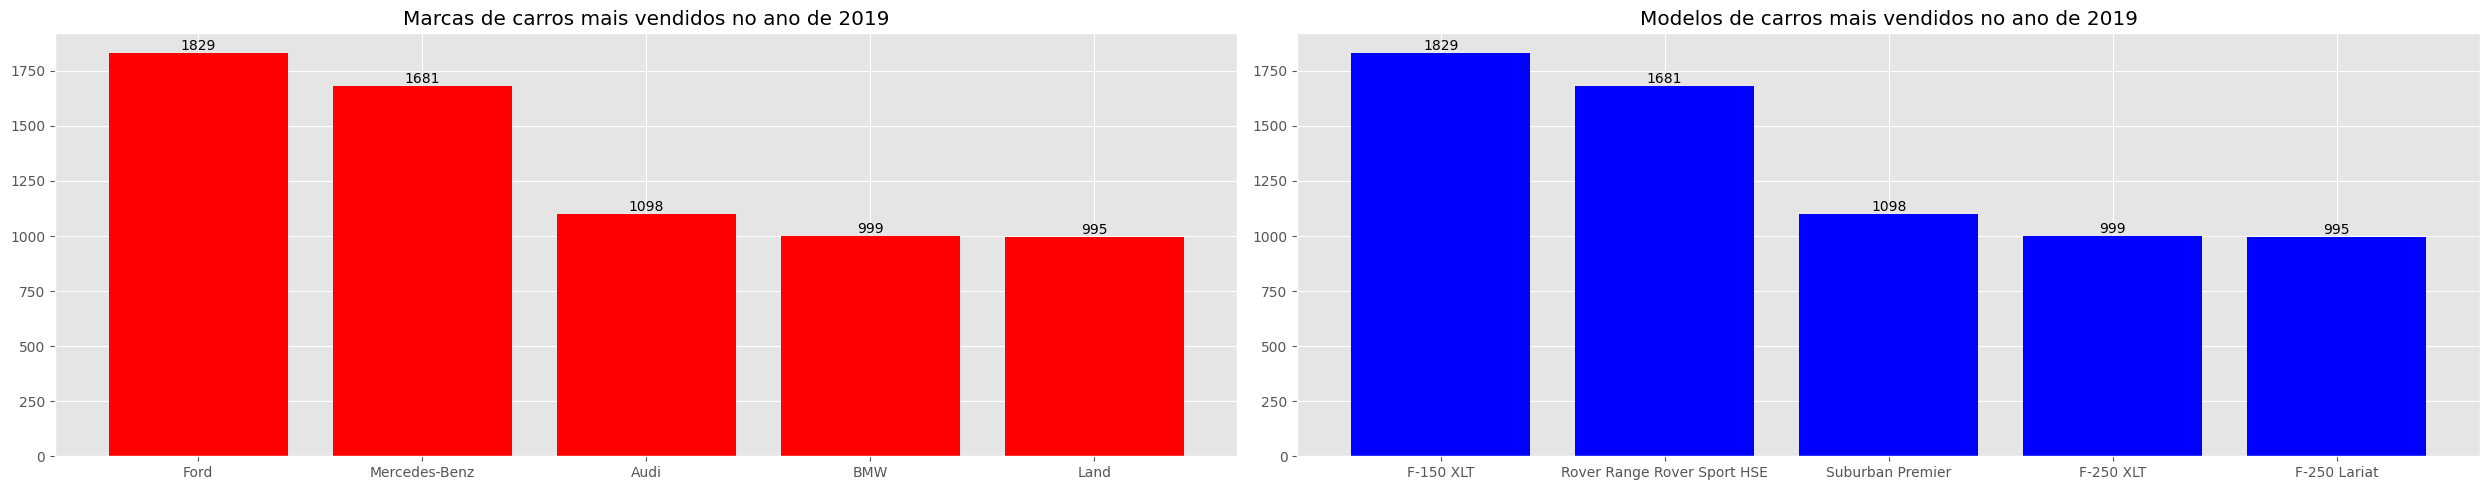

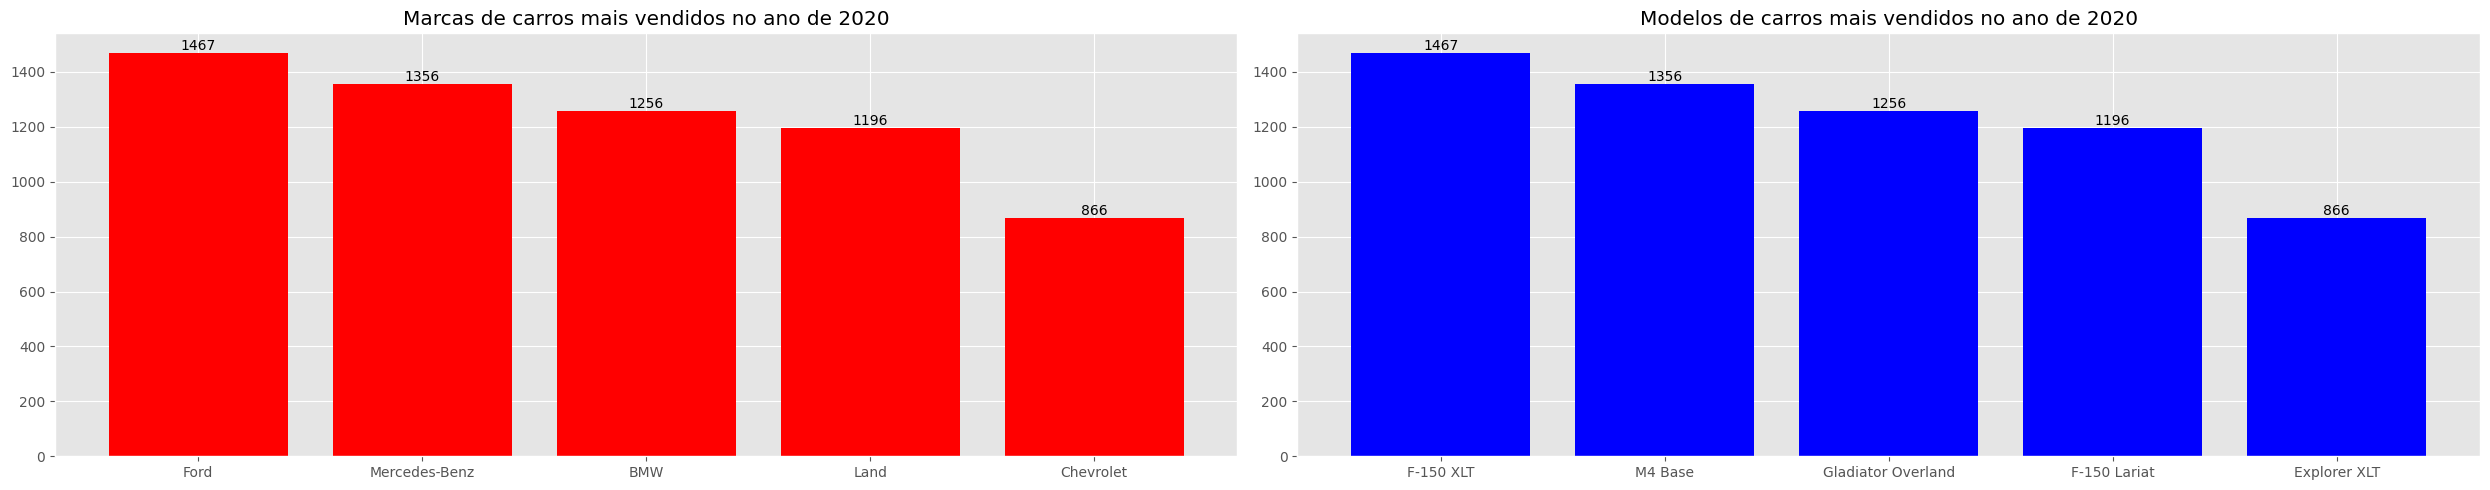

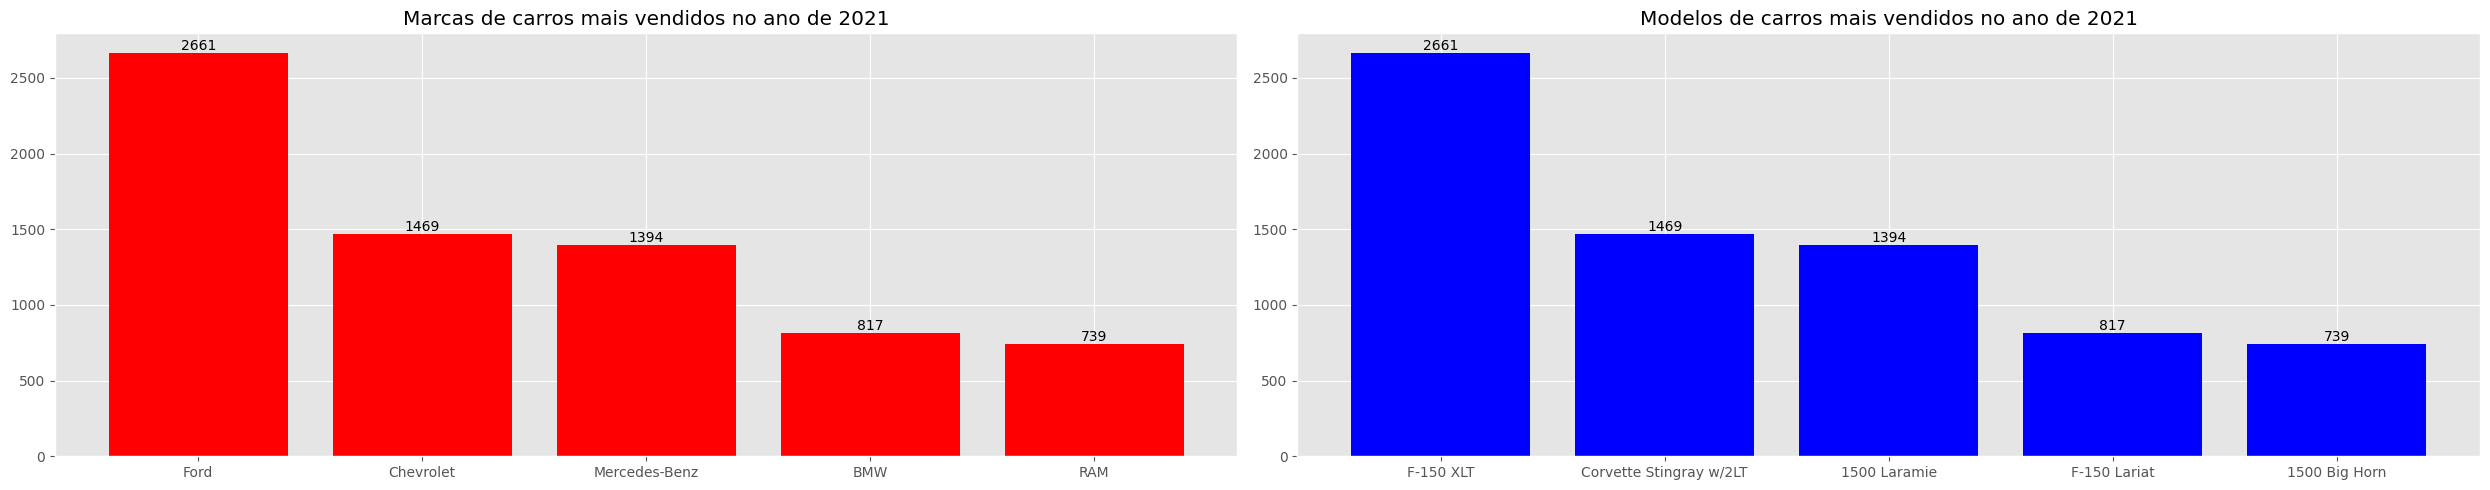

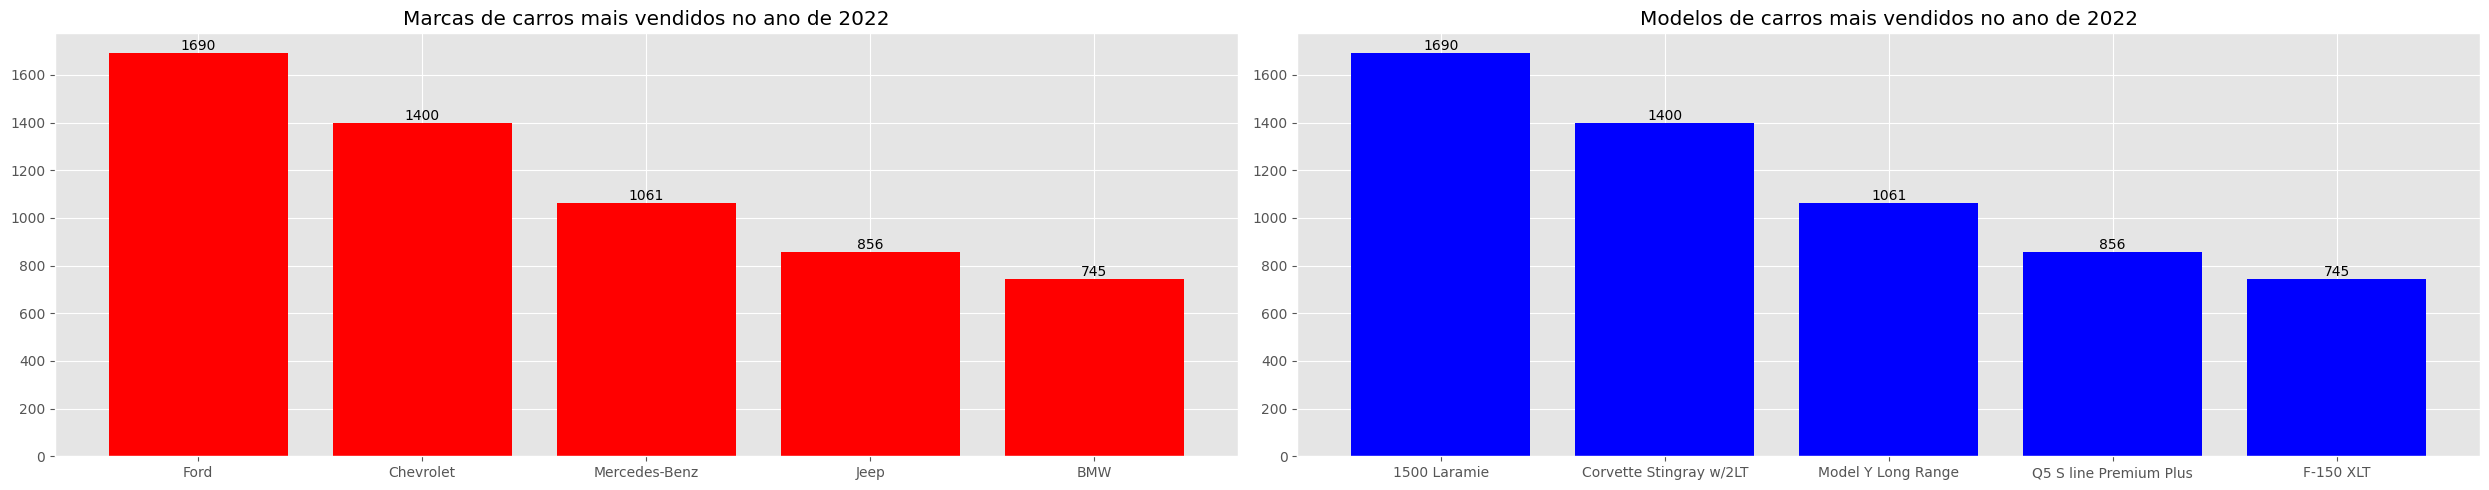

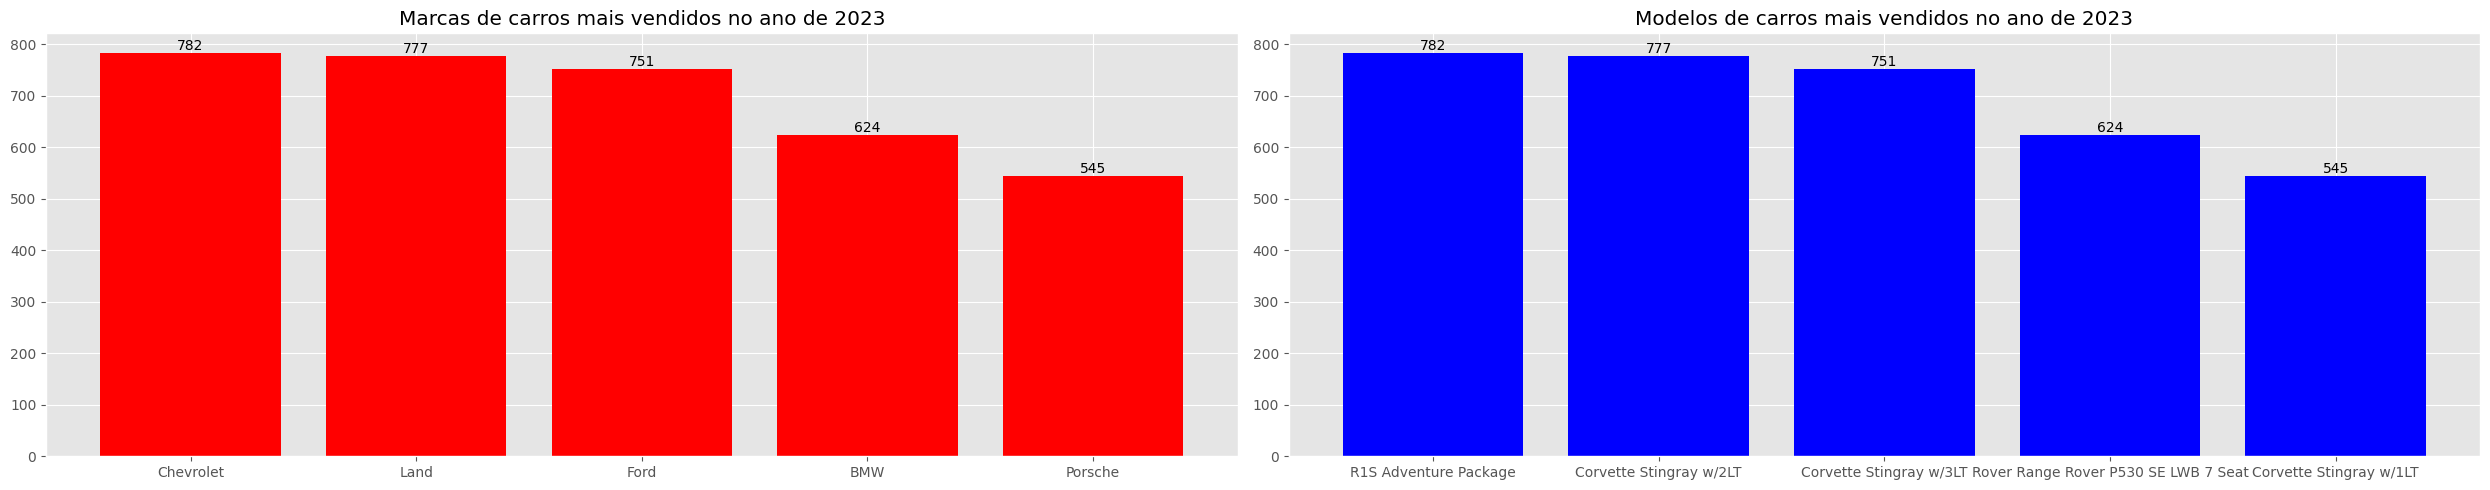

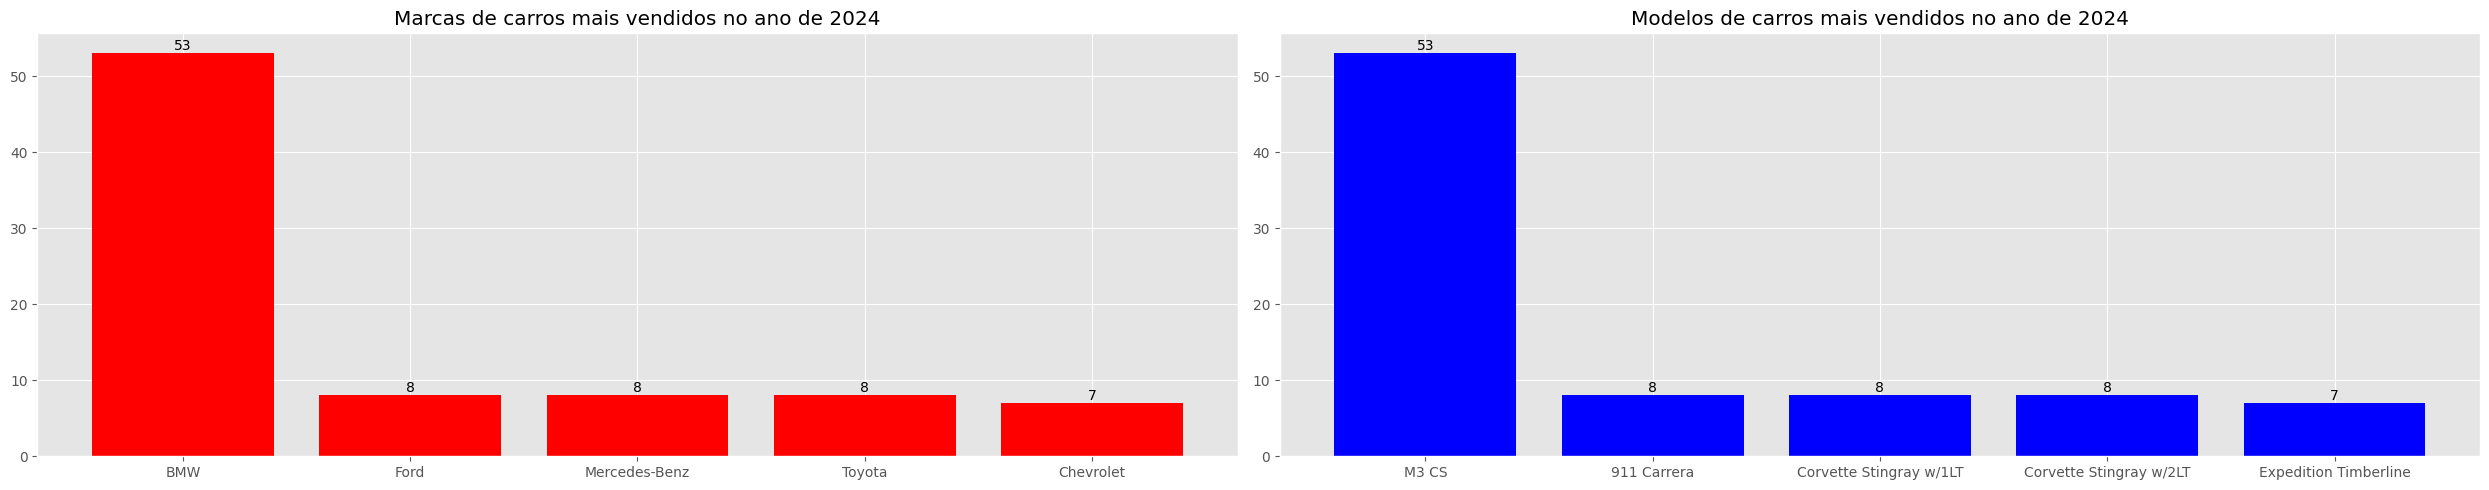

In [17]:
## os cincos modelos mais vendidos por ano
for ano  in sorted(train['model_year'].unique()):
    
    fig, axes = plt.subplots(1, 2, figsize=(25, 5))
    result_modelos = (
        train[train['model_year'] == int(ano)]
        .groupby("model_year")['model']
        .value_counts(ascending=False)
        .head(5)  # Pega as 5 primeiras ocorrências
        .reset_index(name='valor')  # Renomeia a coluna de contagem
    )
    
    result_marcas = (
            train[train['model_year'] == int(ano)]
            .groupby("model_year")['brand']
            .value_counts(ascending=False)
            .head(5)
            .reset_index(name='valor') 
        )

    axes[0].bar(result_marcas['brand'], result_marcas['valor'], color='red')
    axes[0].set_title(f'Marcas de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_marcas['brand'], result_marcas['valor']):
        axes[0].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    axes[1].bar(result_modelos['model'], result_marcas['valor'],color='blue')
    axes[1].set_title(f'Modelos de carros mais vendidos no ano de {ano}')
    for index, value in zip(result_modelos['model'], result_marcas['valor']):
        axes[1].text(index, value, f"{value:.0f}", ha="center", va="bottom")
    
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'As 20 marcas com a mediana de precos por ano mais caras.')

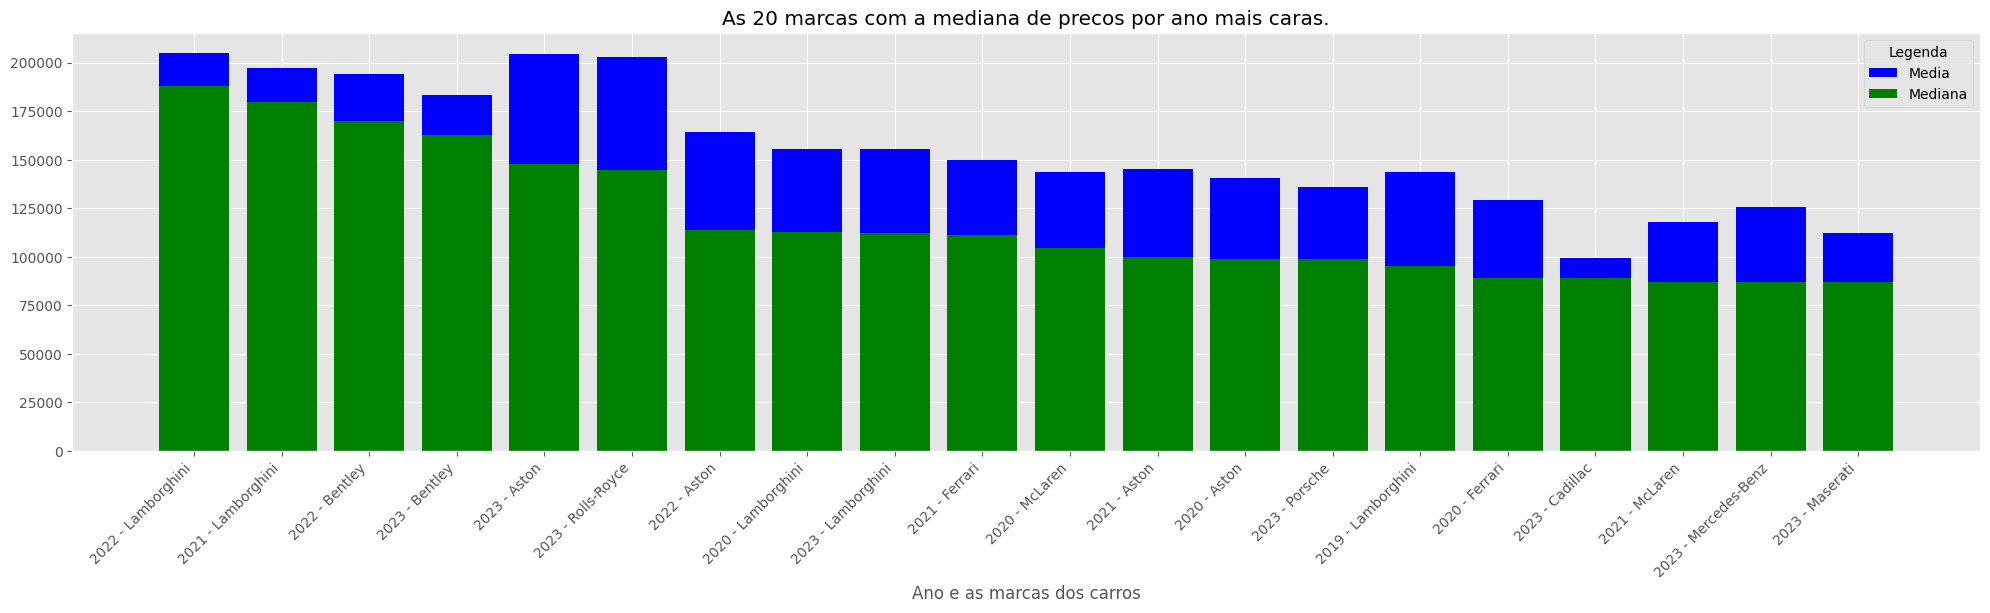

In [18]:

result = (
    train.groupby(["model_year", "brand"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['brand'])], result['median'],color='green', label='Mediana')
plt.xlabel('Ano e as marcas dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('As 20 marcas com a mediana de precos por ano mais caras.')

Text(0.5, 1.0, 'Os 20 modelos com a mediana de precos por ano mais caras.')

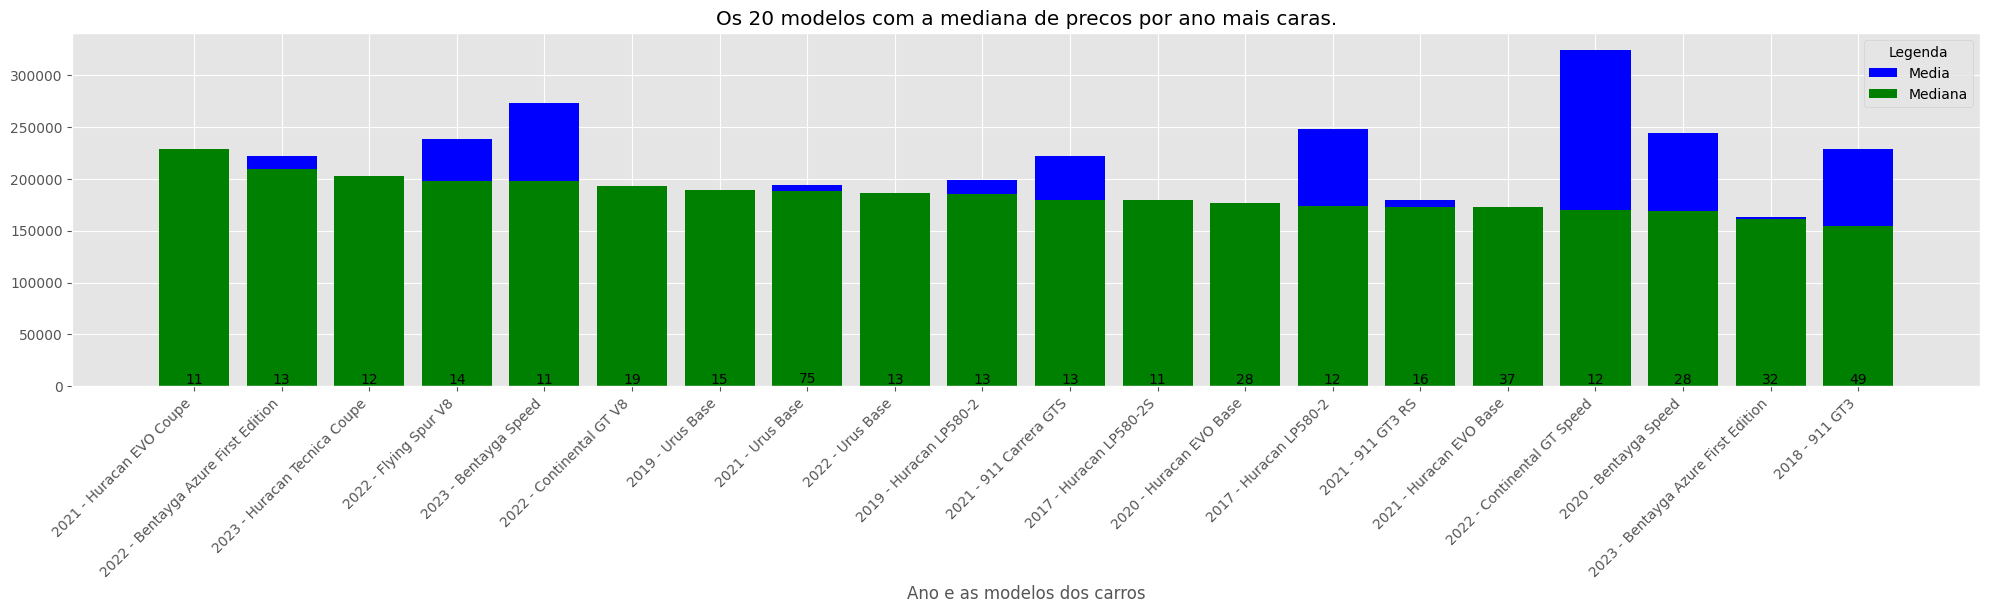

In [19]:
result = (
    train.groupby(["model_year", "model"])['price']
    .agg(["mean", "median", "count"])
    .reset_index()
    .query('count > 10')
    .sort_values("median", ascending=False)
    .head(20)
    
)
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
plt.figure(figsize=(20, 6))
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['mean'],color='blue', label='Media')
plt.bar([(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])], result['median'],color='green', label='Mediana')
eixo_x = [(str(ano)+' - '+ modelo) for ano, modelo in zip(result['model_year'], result['model'])]
for index, value in zip(eixo_x, result['count']):
    plt.text(index, value, f"{value:.0f}", ha="center", va="bottom")
plt.xlabel('Ano e as modelos dos carros')
plt.xticks(rotation=45, ha='right')
plt.legend(['Media', 'Mediana'],loc='upper right', title="Legenda", fontsize=10)
plt.tight_layout()
plt.title('Os 20 modelos com a mediana de precos por ano mais caras.')

In [20]:
## O carros mais carros
train.sort_values('price', ascending=False).head(10)

brand                                       model  model_year  \
96438   Mercedes-Benz           AMG GLE AMG GLE 63 S-Model 4MATIC        2017   
114658          Lexus                                 SC 430 Base        2004   
67277         Pontiac                           Firebird Trans Am        2001   
8611            Honda                                 Pilot Elite        2021   
89415            Ford                                   F-150 XLT        2021   
83768            Audi                                     S4 Base        2004   
107021       Cadillac            Escalade Premium Luxury Platinum        2021   
7065              GMC               Sierra 1500 SLE1 Extended Cab        2020   
80924        Cadillac                                  XT5 Luxury        2021   
86204            Land  Rover Range Rover 3.0L V6 Supercharged HSE        2021   

        milage fuel_type                                         engine  \
96438     4590  Gasoline   577.0HP 5.5L 8 Cylinder Engine Gasoline Fuel   
114658   89500  Gasoline   300.0HP 4.3L 8 Cylinder Engine Gasoline Fuel   
67277    64776  Gasoline  200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel   
8611     42653  Gasoline                           3.5L V6 24V GDI SOHC   
89415    26315  Gasoline                3.5L V6 24V PDI DOHC Twin Turbo   
83768    73500  Gasoline   340.0HP 4.2L 8 Cylinder Engine Gasoline Fuel   
107021   61830  Gasoline                            6.2L V8 16V GDI OHV   
7065      2750  Gasoline                            5.3L V8 16V GDI OHV   
80924    16156  Gasoline                          3.6L V6 24V MPFI DOHC   
86204    29850  Gasoline  380.0HP 3.0L V6 Cylinder Engine Gasoline Fuel   

                          transmission               ext_col      int_col  \
96438   Transmission w/Dual Shift Mode                  Gray        Black   
114658                             A/T                Silver        Black   
67277                      4-Speed A/T                 White        Beige   
8611                 9-Speed Automatic                  Gray        Black   
89415               10-Speed Automatic  Agate Black Metallic        Black   
83768                      6-Speed M/T                  Blue        Beige   
107021              10-Speed Automatic    Sandstone Metallic  Dark Auburn   
7065                 6-Speed Automatic                   Red        Black   
80924                8-Speed Automatic          Shadow Black  Shara Beige   
86204   Transmission w/Dual Shift Mode                 White        Black   

             accident clean_title    price  
96438   None reported         Yes  2954083  
114658  None reported         Yes  2954083  
67277   None reported         Yes  2954083  
8611              NaN         NaN  2954083  
89415   None reported         Yes  2954083  
83768   None reported         Yes  2954083  
107021  None reported         Yes  2954083  
7065    None reported         Yes  2954083  
80924   None reported         Yes  2954083  
86204   None reported         Yes  2954083

In [21]:
## O carros mais barratos
train.sort_values('price', ascending=True).head(10)

brand                  model  model_year  milage fuel_type  \
82567      Nissan           350Z Touring        2001   42000  Gasoline   
94913     Pontiac          Firebird Base        1999  158000  Gasoline   
146866      Mazda        MX-5 Miata Base        1999  150000  Gasoline   
29144       Honda                CR-V EX        2004  169613  Gasoline   
13772      Toyota  Tundra SR5 Access Cab        2004  120000  Gasoline   
26303       Volvo                  S60 R        2005  110000  Gasoline   
144935       Ford      Excursion XLT 4WD        2002  205000  Gasoline   
124068     Toyota    Camry Solara SLE V6        2006  114528  Gasoline   
107637  Chevrolet         Monte Carlo SS        2001   64776  Gasoline   
59685         Kia              Optima EX        2000  130000  Gasoline   

                                               engine transmission ext_col  \
82567    200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel  6-Speed M/T   Black   
94913   200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel          A/T   White   
146866   140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel          A/T  Silver   
29144    150.0HP 2.4L 4 Cylinder Engine Gasoline Fuel          M/T  Silver   
13772    282.0HP 4.7L 8 Cylinder Engine Gasoline Fuel          A/T     Red   
26303    230.0HP 4.7L 8 Cylinder Engine Gasoline Fuel  4-Speed A/T   Black   
144935  310.0HP 6.8L 10 Cylinder Engine Gasoline Fuel          A/T   Black   
124068  225.0HP 3.3L V6 Cylinder Engine Gasoline Fuel          A/T   Black   
107637  200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel  4-Speed A/T    Gray   
59685    200.0HP 2.4L 4 Cylinder Engine Gasoline Fuel          A/T   Black   

       int_col                                accident clean_title  price  
82567   Orange                                     NaN         NaN   2000  
94913    Beige  At least 1 accident or damage reported         Yes   2000  
146866   Black  At least 1 accident or damage reported         Yes   2000  
29144     Gray                           None reported         Yes   2000  
13772        –                           None reported         Yes   2000  
26303    Beige                           None reported         Yes   2000  
144935   Beige  At least 1 accident or damage reported         Yes   2000  
124068    Gray                           None reported         Yes   2000  
107637   Black                           None reported         Yes   2000  
59685    Beige                           None reported         Yes   2000

In [22]:
## O carros mais rodados
train.sort_values('milage', ascending=False).head(10)

brand                       model  model_year  milage  \
126607        Porsche       911 Carrera Cabriolet        1998  405000   
32468       Chevrolet                  Camaro 1SS        2019  405000   
54529      Volkswagen     Golf GTI 2.0T SE 4-Door        2016  405000   
60689      Volkswagen               CC 2.0T Sport        2016  405000   
98435           Mazda            MX-5 Miata Sport        2002  402000   
1320    Mercedes-Benz               E-Class E 550        2016  399000   
11337       Chevrolet                    Tahoe LT        2010  399000   
69329   Mercedes-Benz        Sprinter Normal Roof        2013  399000   
11451   Mercedes-Benz  SL-Class SL63 AMG Roadster        2008  399000   
3026    Mercedes-Benz               Sprinter 2500        2012  399000   

            fuel_type                                             engine  \
126607       Gasoline  300.0HP 3.4L Flat 6 Cylinder Engine Gasoline Fuel   
32468        Gasoline       455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel   
54529        Gasoline       240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
60689        Gasoline       200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   
98435        Gasoline       142.0HP 1.8L 4 Cylinder Engine Gasoline Fuel   
1320         Gasoline       402.0HP 4.7L 8 Cylinder Engine Gasoline Fuel   
11337   E85 Flex Fuel  355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
69329          Diesel        188.0HP 3.0L V6 Cylinder Engine Diesel Fuel   
11451        Gasoline       518.0HP 6.3L 8 Cylinder Engine Gasoline Fuel   
3026           Diesel        188.0HP 3.0L V6 Cylinder Engine Diesel Fuel   

       transmission ext_col int_col                                accident  \
126607  6-Speed M/T    Blue   Black                           None reported   
32468   6-Speed M/T  Orange   Black                           None reported   
54529   6-Speed M/T    Blue   Black                           None reported   
60689   8-Speed A/T   White    Gray  At least 1 accident or damage reported   
98435   5-Speed M/T   White   Black                                     NaN   
1320    7-Speed A/T    Gray   Black                           None reported   
11337   6-Speed A/T   White   Black  At least 1 accident or damage reported   
69329   5-Speed A/T   White   Black  At least 1 accident or damage reported   
11451           A/T   Black   Black                           None reported   
3026            A/T  Silver   Black                           None reported   

       clean_title   price  
126607         Yes  124995  
32468          Yes   71950  
54529          Yes   18000  
60689          Yes   17500  
98435          NaN   12500  
1320           Yes   26500  
11337          Yes   39990  
69329          Yes   16800  
11451          Yes   28500  
3026           Yes   17700

In [23]:
## O carros menos rodado
train.sort_values('milage', ascending=True).head(10)

brand                  model  model_year  milage fuel_type  \
77138   Porsche          911 Carrera S        2023     100  Gasoline   
36403     Tesla     Model Y Long Range        2021     100       NaN   
36405       Kia           Telluride LX        2023     100  Gasoline   
111061   Rivian  R1S Adventure Package        2023     100       NaN   
82289      Audi     Q8 55 Premium Plus        2023     100    Hybrid   
74290     Lexus            RX 350 Base        2022     100  Gasoline   
44896       GMC        Sierra 1500 AT4        2023     100  Gasoline   
61338     Tesla     Model 3 Long Range        2021     100       NaN   
1504        BMW           750 i xDrive        2023     100  Gasoline   
139069    Dodge           Viper SRT-10        2005     100  Gasoline   

                                                   engine       transmission  \
77138                     3.0L H6 24V GDI DOHC Twin Turbo  8-Speed Automatic   
36403         425.0HP Electric Motor Electric Fuel System                A/T   
36405       291.0HP 3.8L V6 Cylinder Engine Gasoline Fuel                A/T   
111061        557.0HP Electric Motor Electric Fuel System        1-Speed A/T   
82289   335.0HP 3.0L V6 Cylinder Engine Gasoline/Mild ...        8-Speed A/T   
74290       295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel        6-Speed A/T   
44896        401.0HP 6.6L 8 Cylinder Engine Gasoline Fuel                A/T   
61338         271.0HP Electric Motor Electric Fuel System                A/T   
1504         445.0HP 4.4L 8 Cylinder Engine Gasoline Fuel                A/T   
139069      500.0HP 8.3L 10 Cylinder Engine Gasoline Fuel        6-Speed M/T   

       ext_col int_col       accident clean_title   price  
77138      Red   Black  None reported         NaN   77430  
36403   Silver   White  None reported         Yes   24000  
36405    Green    Gray  None reported         Yes   98900  
111061    Blue   Black  None reported         Yes   72999  
82289     Gray     Red  None reported         Yes   75000  
74290   Silver   Black  None reported         Yes   66200  
44896     Blue   Black  None reported         Yes   23500  
61338    White   Black  None reported         Yes   29999  
1504     Black   Black  None reported         Yes  188500  
139069  Orange    Gray  None reported         Yes   60500

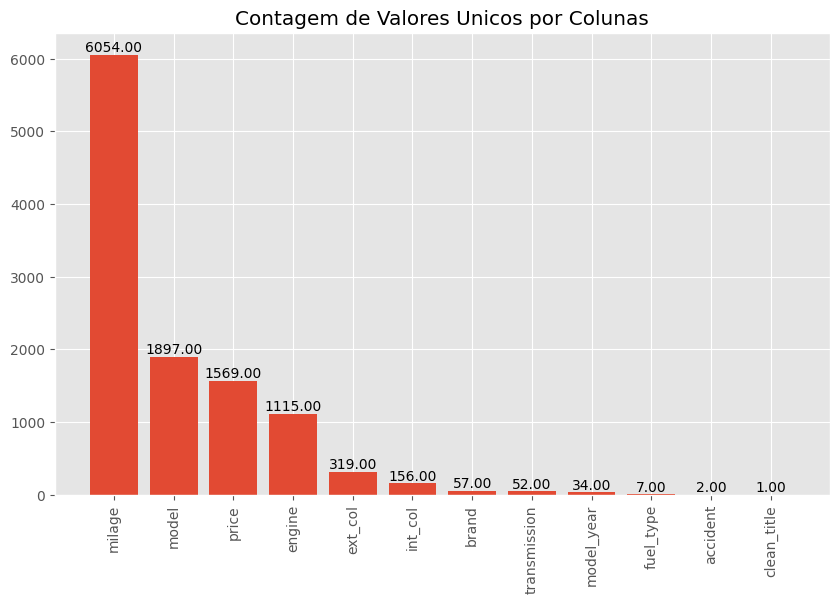

In [24]:
train_nunique = train.nunique().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

plt.bar(train_nunique.index, train_nunique.values)
plt.title("Contagem de Valores Unicos por Colunas")
plt.tick_params(axis="x", rotation=90)
for index, value in enumerate(train_nunique.values):
    plt.text(index, value, f"{value:.2f}", ha="center", va="bottom")


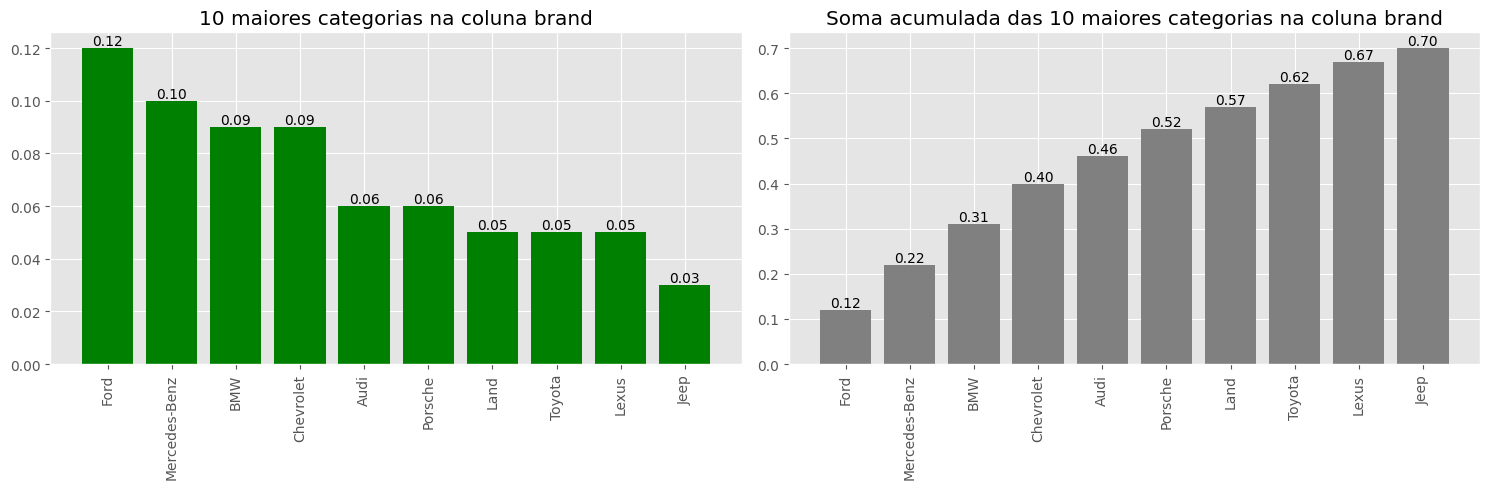

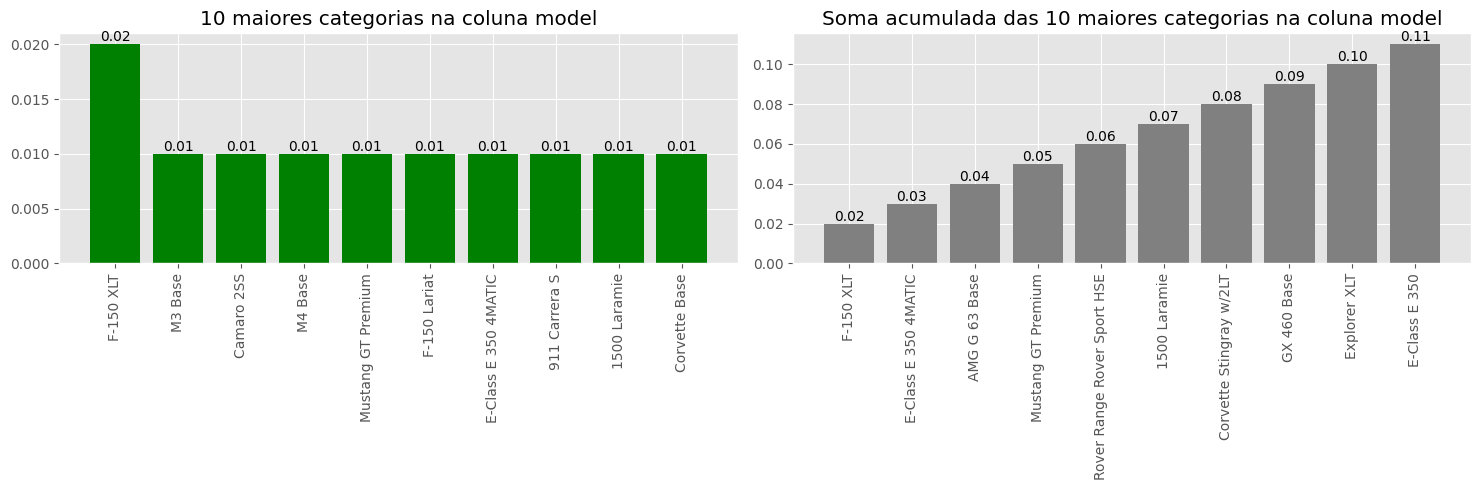

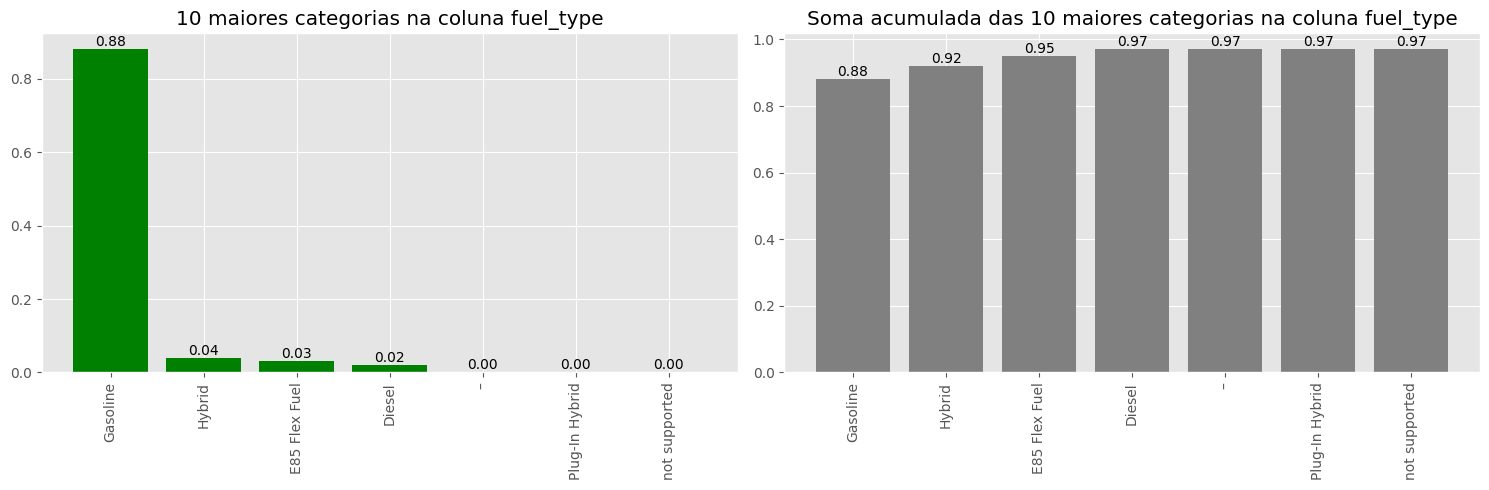

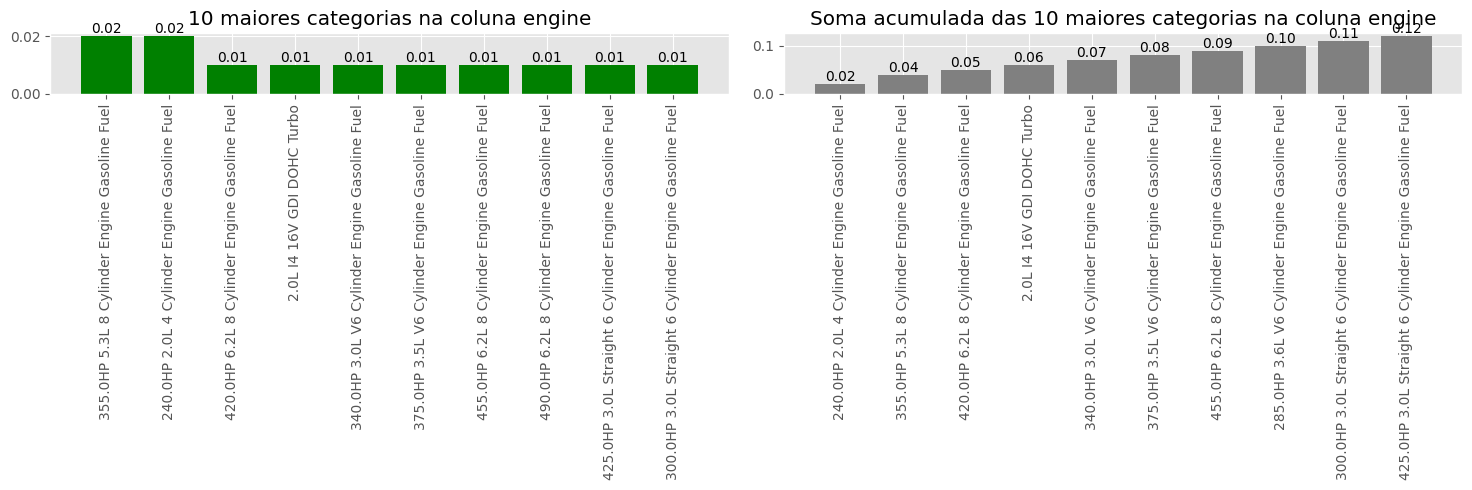

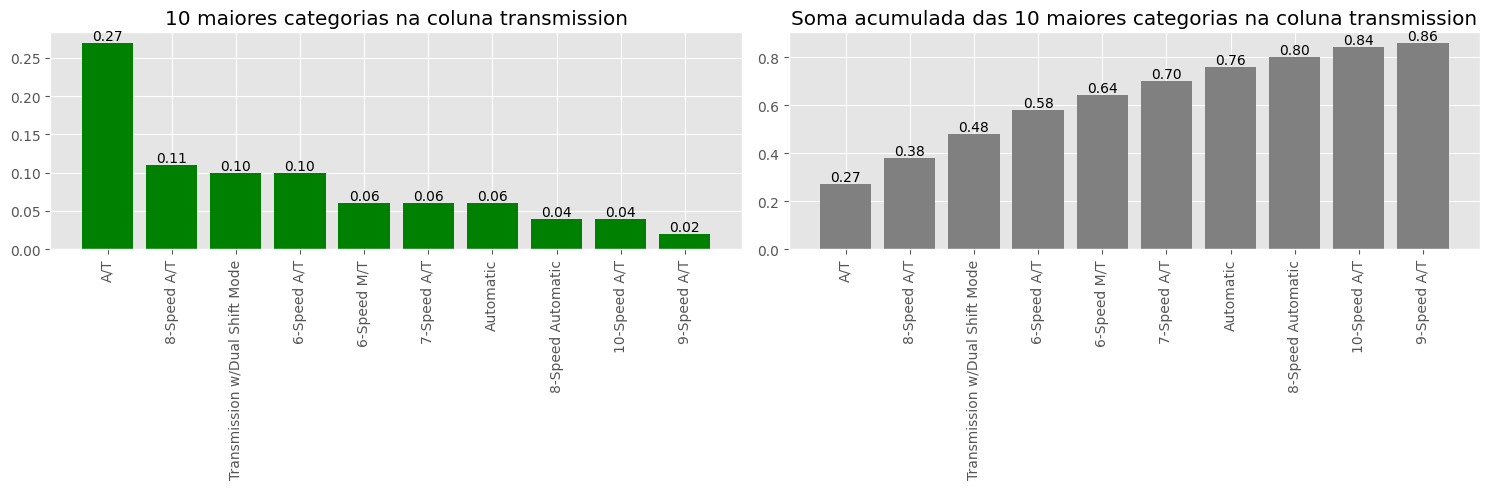

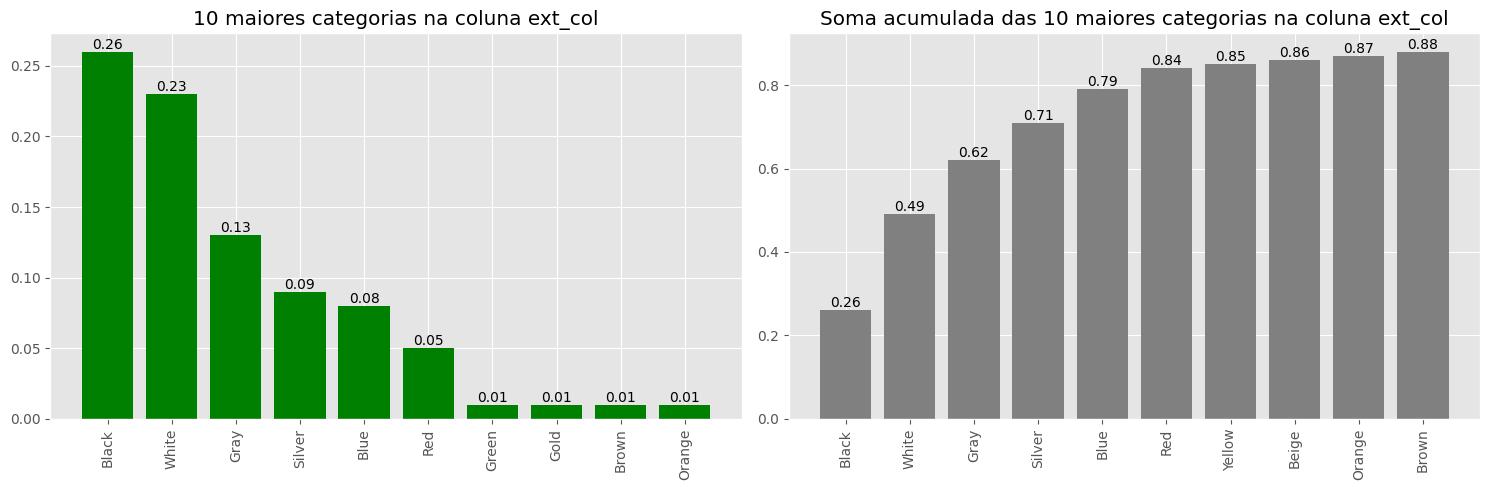

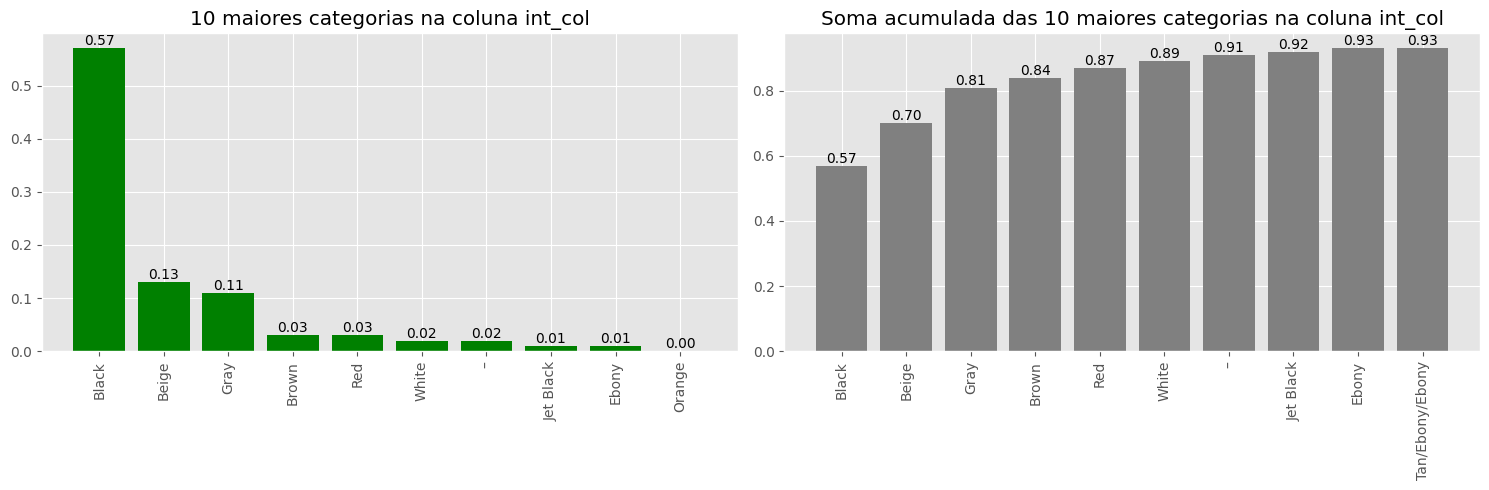

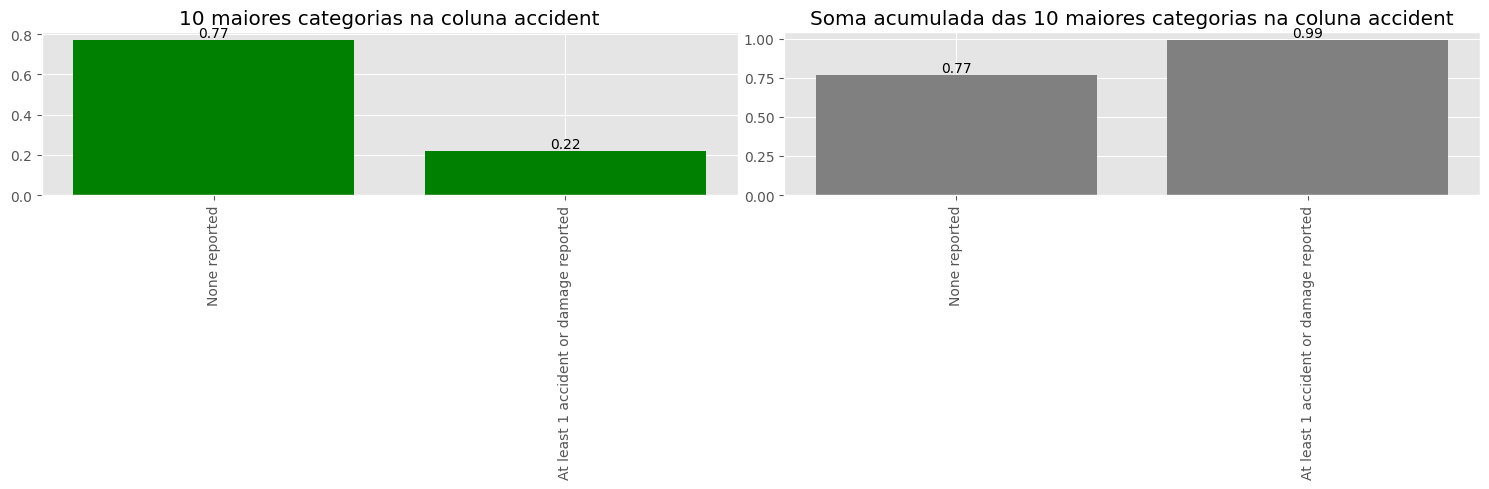

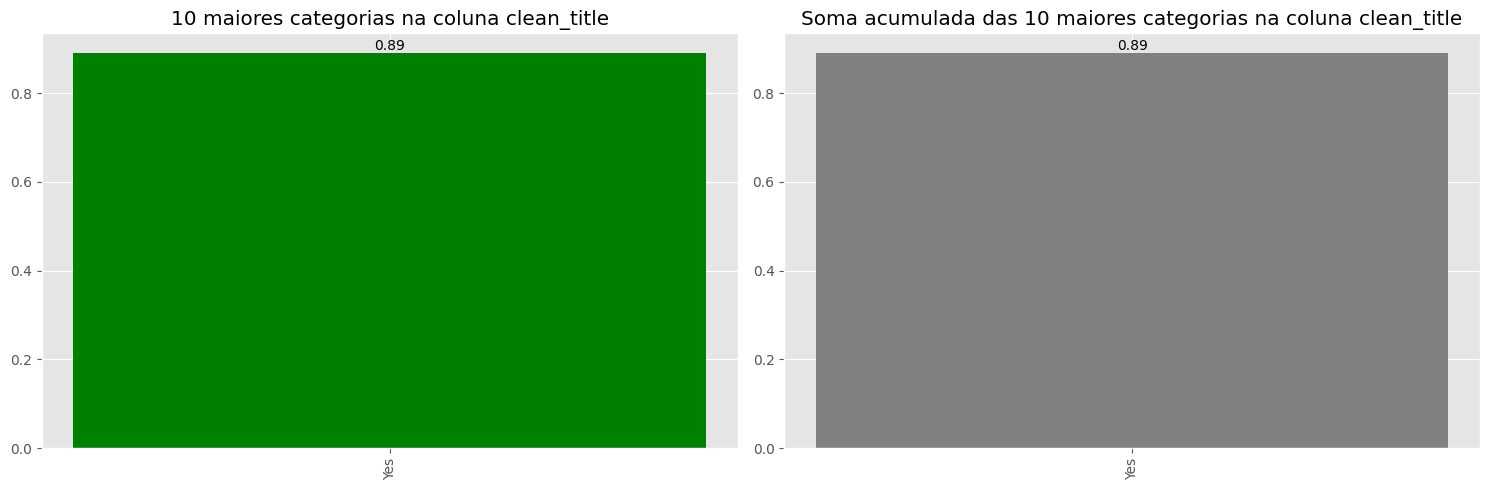

In [25]:
for col in train.columns:
    if train[col].dtype != "int64":
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        train_class = (
                round(train[col].value_counts() / train.shape[0], 2)
                .head(10)
                .sort_values(ascending=False)
            )
        
        train_cumsum = (
            round(train[col].value_counts() / train.shape[0], 2)
            .sort_values(ascending=False)
            .cumsum()
            .head(10)
        )
        
        
        axes[0].bar(train_class.index, train_class.values, color="green", label="train")
        axes[0].set_title(f"10 maiores categorias na coluna {col}")
        axes[0].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_class.values):
            axes[0].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        axes[1].bar(
            train_cumsum.index, train_cumsum.values, color="gray", label="train"
        )
        axes[1].set_title(f"Soma acumulada das 10 maiores categorias na coluna {col}")
        axes[1].tick_params(axis="x", rotation=90)
        for index, value in enumerate(train_cumsum.values):
            axes[1].text(index, value, f"{value:.2f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()
   


In [26]:
train.groupby('transmission')['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=False).head(50)

mean    median  \
transmission                                                                  
7-Speed                                             193650.833333  146200.0   
7-Speed Manual                                      156586.860656  125445.0   
8-Speed Automatic with Auto-Shift                   155042.271462  104500.0   
–                                                   152909.843750   85309.0   
8-Speed Manual                                       89923.368421   84645.0   
2-Speed Automatic                                    76778.947368   69900.0   
7-Speed Automatic with Auto-Shift                   121695.509072   68750.0   
7-Speed DCT Automatic                               148567.909091   67250.0   
Single-Speed Fixed Gear                              68691.666667   64149.0   
7-Speed M/T                                          84649.160714   59972.5   
10-Speed Automatic with Overdrive                    65201.171429   59950.0   
2-Speed A/T                                          57633.444444   59000.0   
9-Speed Automatic with Auto-Shift                    93374.260870   52991.0   
1-Speed A/T                                          57676.333333   48990.0   
10-Speed A/T                                         58303.695793   48990.0   
6-Speed Manual                                      116329.642424   47214.0   
1-Speed Automatic                                    62546.512281   46598.0   
10-Speed Automatic                                   63189.209451   45480.0   
Automatic                                            59570.132636   44998.0   
9-Speed A/T                                          59079.127941   44870.0   
Variable                                             45785.649123   42598.0   
7-Speed Automatic                                    59520.218045   42499.0   
8-Speed Automatic                                    67837.320083   41998.0   
9-Speed Automatic                                    64672.348624   41900.0   
8-Speed A/T                                          56332.812454   41000.0   
6-Speed                                              45226.884615   39992.0   
6 Speed At/Mt                                        36184.562500   37498.5   
6 Speed Mt                                           35282.533333   37298.0   
Transmission w/Dual Shift Mode                       50279.351058   35900.0   
2                                                    50345.440000   35707.0   
CVT-F                                                34187.181818   34645.0   
F                                                    49150.934783   33148.5   
Manual                                               56133.000000   32998.0   
7-Speed A/T                                          46697.726935   32400.0   
4-Speed Automatic                                   100744.114286   31999.0   
5-Speed Automatic                                    53819.672131   31862.0   
Automatic CVT                                        38452.081818   31465.0   
6-Speed Automatic                                    39751.639249   29995.0   
6-Speed Electronically Controlled Automatic with O   32073.500000   28371.5   
6-Speed Automatic with Auto-Shift                    43112.663265   28345.5   
Transmission Overdrive Switch                        27495.391667   22750.0   
6-Speed M/T                                          33186.920744   21999.0   
A/T                                                  31586.064298   20499.0   
CVT Transmission                                     25444.077313   20150.0   
6-Speed A/T                                          25541.718406   19995.0   
M/T                                                  27144.974843   15575.0   
5-Speed A/T                                          20277.326893   12950.0   
5-Speed M/T                                          15203.938542   11499.5   
4-Speed A/T                                          15763.616790   10000.0   

                               

In [27]:
## Criando novas variáveis
# potencia do motor
train['hp'] = pd.to_numeric([float(i[0].split('HP')[0]) if 'HP' in i[0] else None for i in train['engine'].str.split(' ')],errors='coerce')
##Quantidade de marchas
train['marchas'] = pd.to_numeric([i[0] if len(i) > 1 else None for i in train['transmission'].str.split('-')],errors='coerce')
# Idade do carro em anos
train['idade_carro'] = datetime.datetime.now().year - train.model_year
## Quantas valvulas tem o motor 

automatic_patterns = [
    'Automatic', 'Auto-Shift', 'DCT Automatic', 'CVT', 'A/T'
]

# Cria a nova coluna 'automatico' com base nos padrões
train['cambio'] = np.where(
    train['transmission'].str.contains('|'.join(automatic_patterns), case=False, na=False),
    'automatico',
    np.where(train['transmission'].str.contains('Dual'),'dual','manual') )

lista_engine = []
for t in train['engine'].str.split(' '):
    if 'HP' in t[0]:
        if 'Straight' in t[2] or 'Flat' in t[2] or 'Cylinder' in t[2]:
            lista_engine.append(t[3])
        elif 'Electric' in t[0] or 'Electric' in t[1]:
            lista_engine.append('0')
        else:
            lista_engine.append(t[2])
    elif 'L' in t[0]:
        try:
            if 'Straight' in t[1] or 'Flat' in t[1] or 'Cylinder' in t[1]:
                lista_engine.append(t[2])
            else:
                lista_engine.append(t[1])
        except IndexError:
            lista_engine.append('None')
                
    elif len(t) > 1:
        if  'Liter' in t[1]:
            lista_engine.append('None')
        else:
            lista_engine.append(t)
    elif 'Electric' == t[0]:
        lista_engine.append('0')
 
    elif 'Intercooled' == t[0]:
        lista_engine.append(t[3])
    elif 'Dual' == t[0]:
        lista_engine.append('None')
    else:
        lista_engine.append('None')

train['cilindros'] = lista_engine

train['cilindros'] = pd.to_numeric(train['cilindros'].str.replace(r'[VIHW]', '', regex=True).str.replace('Electric', '0').str.replace('Rotary', 'None'),errors='coerce')

train.loc[(train['cilindros'].isna()) & (train['fuel_type'] == 'electric')] = train.loc[(train['cilindros'].isna()) & (train['fuel_type'] == 'electric')].fillna(0)

train['fuel_type'].fillna('electric',inplace=True)
train['fuel_type'] = train['fuel_type'].replace('–','Gasoline').replace('Plug-In Hybrid', 'Hybrid').replace('E85 Flex Fuel','flex')
train.loc[train['fuel_type'] == 'not supported', 'fuel_type'] = np.where(
                                                                train[train['fuel_type'] == 'not supported']['engine'].str.contains('Gasoline'), 'Gasoline',
                                                                np.where(
                                                                    train[train['fuel_type'] == 'not supported']['engine'].str.contains('Electric'), 'electric', 'flex'
                                                                    )
                                                                )
                            

<Axes: >

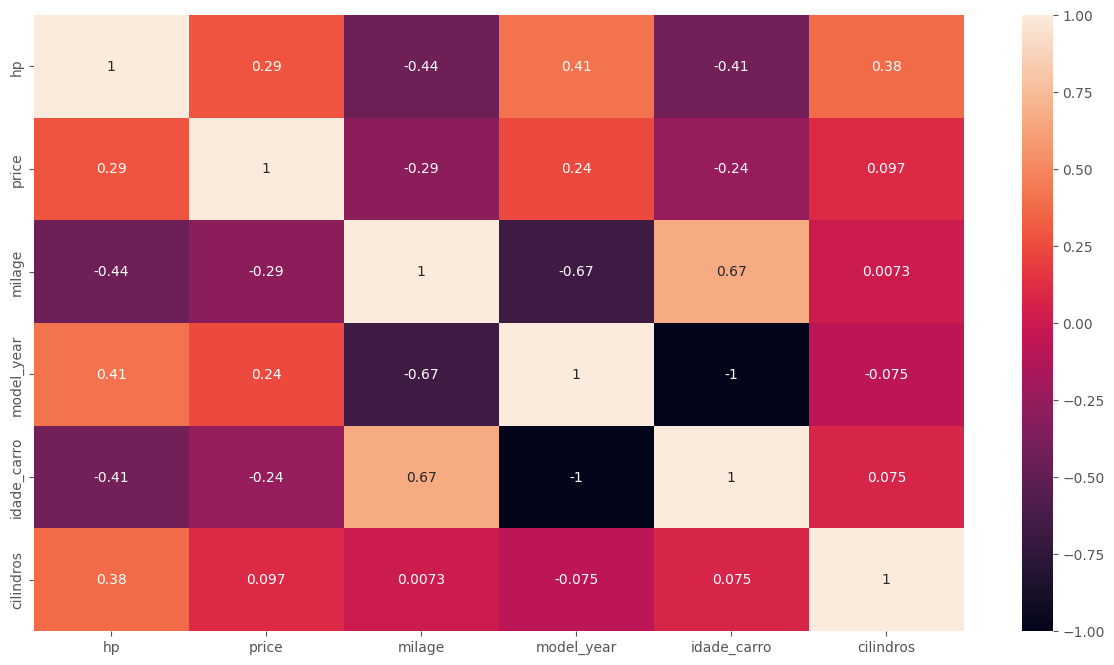

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(train[['hp','price','milage','model_year','idade_carro','cilindros']].corr(), annot=True)

 - Olhando a potência, percebemos que quanto mais potente um carro for, mais caro o mesmo vai ser.

 - Já olhando a distância, percebemos que quanto mais distancia um veículo percorre, mais barato o mesmo vai ser.

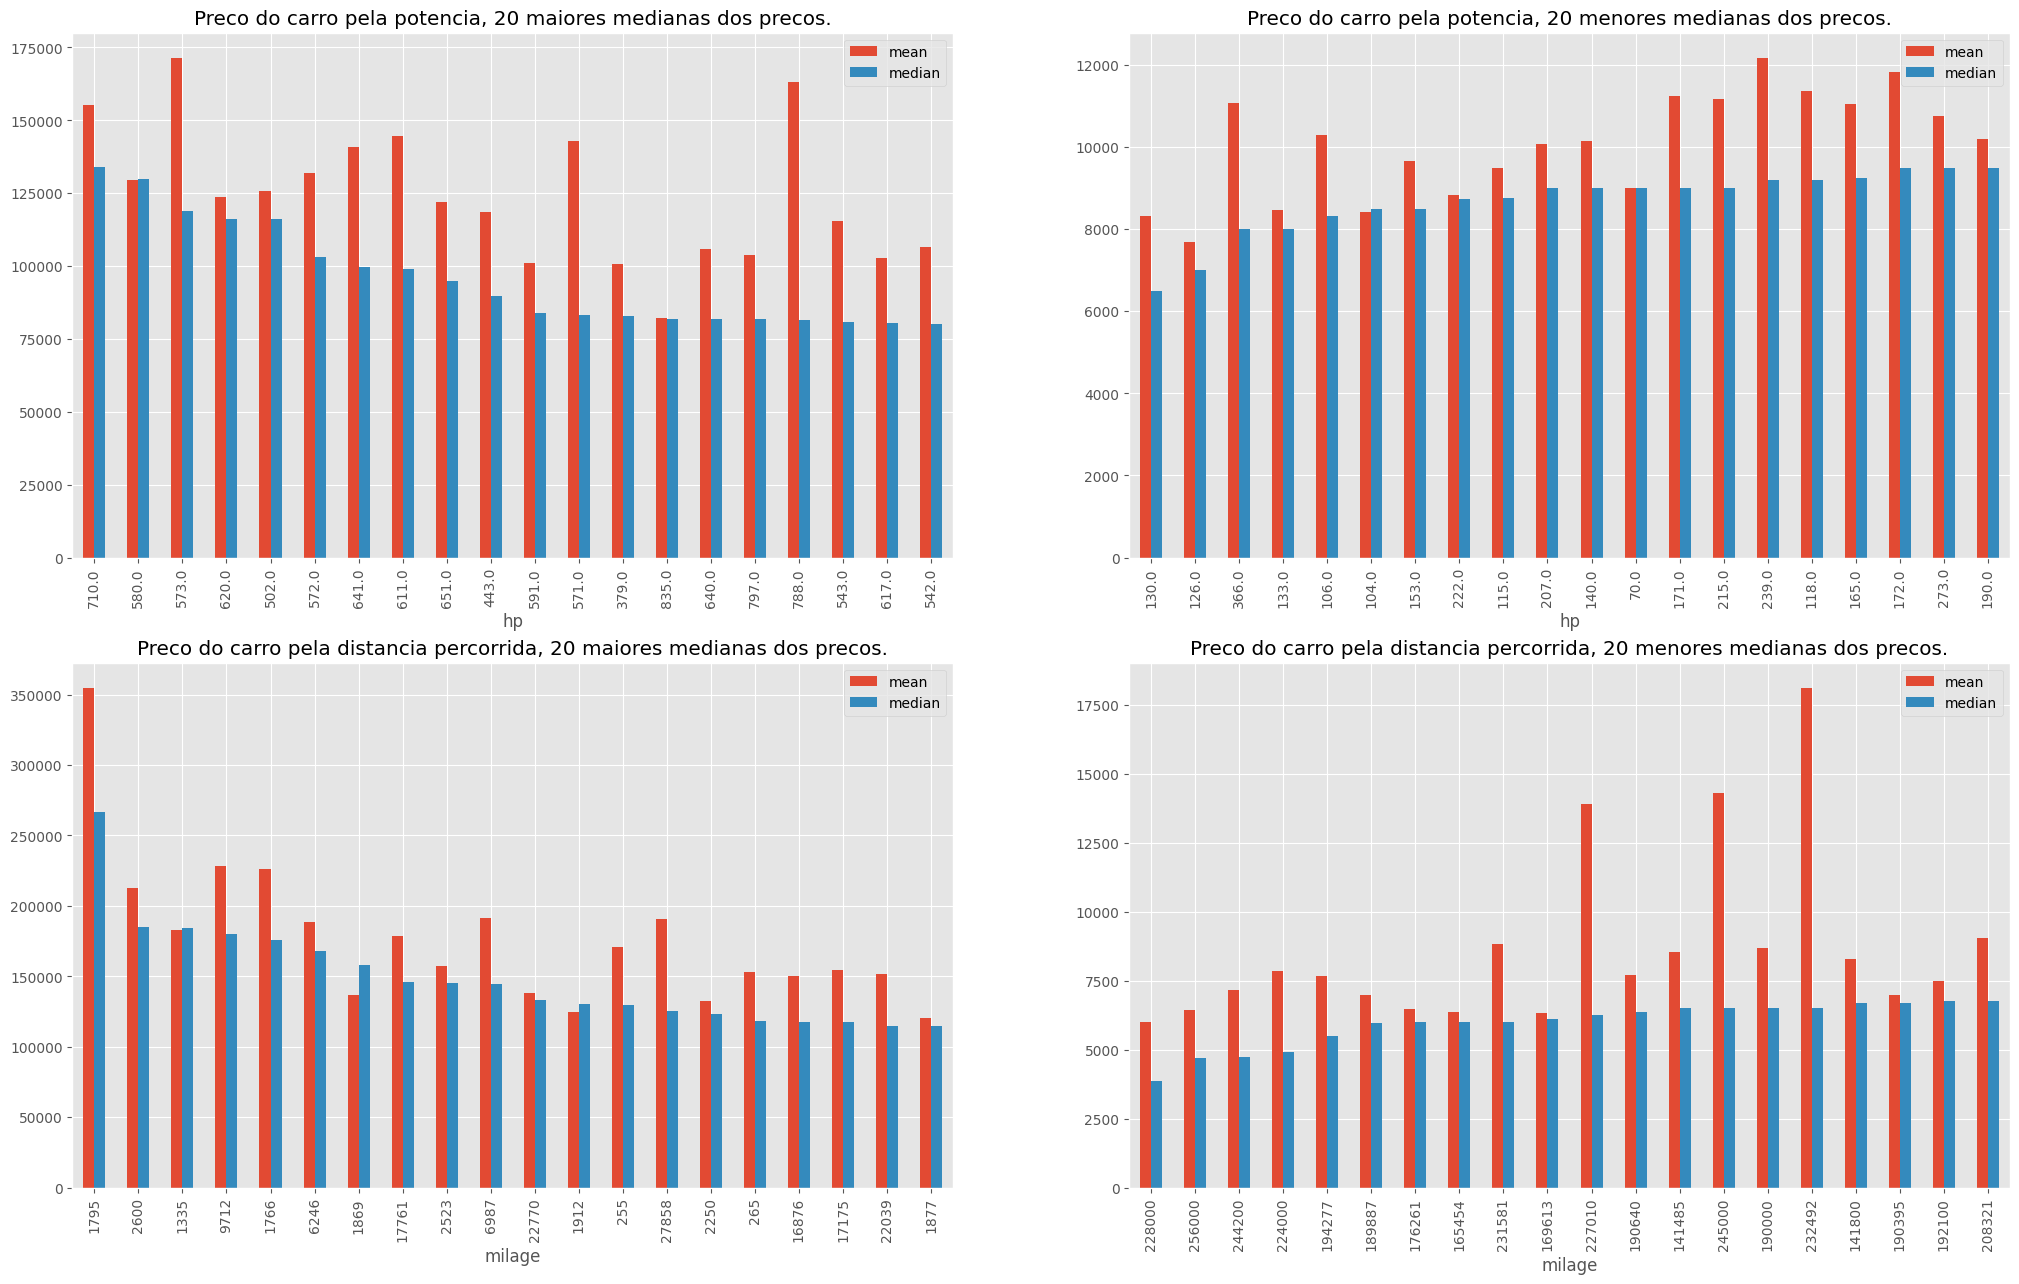

In [29]:
preco_potencia_superio = train.groupby(['hp'])['price'].agg(['mean', 'median', 'count']).sort_values(by='median',ascending=False).head(20)
preco_potencia_inferior = train.groupby(['hp'])['price'].agg(['mean', 'median', 'count']).sort_values(by='median',ascending=True).head(20)
preco_distancia_superio = train.groupby(['milage'])['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=False).head(20)
preco_distancia_inferior = train.groupby(['milage'])['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=True).head(20)

fig, axes = plt.subplots(2, 2, figsize=(25, 15))

preco_potencia_superio[['mean', 'median']].plot(kind='bar',ax=axes[0][0])
axes[0][0].set_title('Preco do carro pela potencia, 20 maiores medianas dos precos.')
axes[0][0].tick_params(axis="x", rotation=90)
    
    
preco_potencia_inferior[['mean', 'median']].plot(kind='bar',ax=axes[0][1])
axes[0][1].set_title('Preco do carro pela potencia, 20 menores medianas dos precos.')
axes[0][1].tick_params(axis="x", rotation=90)


preco_distancia_superio[['mean', 'median']].plot(kind='bar',ax=axes[1][0])
axes[1][0].set_title('Preco do carro pela distancia percorrida, 20 maiores medianas dos precos.')
axes[1][0].tick_params(axis="x", rotation=90)
    
    
preco_distancia_inferior[['mean', 'median']].plot(kind='bar',ax=axes[1][1])
axes[1][1].set_title('Preco do carro pela distancia percorrida, 20 menores medianas dos precos.')
axes[1][1].tick_params(axis="x", rotation=90)

In [30]:
## substituindo os valores faltantes de hp
train_hp = train[train['hp'].notnull()]
x_train_hp = train_hp[['idade_carro','cilindros']]
y_train_hp = train_hp['hp']
pipe = Pipeline([('inputar', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()), 
                 ('random_forest', RandomForestRegressor())])

pipe.fit(x_train_hp, y_train_hp)

x_predict_hp = train.loc[train['hp'].isnull(),['idade_carro','cilindros']]

train.loc[x_predict_hp.index,'hp'] = pipe.predict(x_predict_hp)

## substituindo os valores faltantes de cilindros
train_cilindros = train[train['cilindros'].notnull()]
x_train_cilindros = train_cilindros[['hp','idade_carro']]
y_train_cilindros = train_cilindros['cilindros']
pipe = Pipeline([('inputar', SimpleImputer(strategy='median')),
                 ('scaler', StandardScaler()), 
                 ('random_forest', RandomForestRegressor())])

pipe.fit(x_train_cilindros, y_train_cilindros)

x_predict_cilindros= train.loc[train['cilindros'].isnull(),['hp','idade_carro']]

train.loc[x_predict_cilindros.index,'cilindros'] = pipe.predict(x_predict_cilindros).round(0)

In [31]:
## substituindo os valores faltantes de marchas
train_marchas = train[train['marchas'].notnull()]
x_train_marchas = train_marchas[['hp', 'idade_carro','cilindros', 'cambio']]
y_train_marchas = train_marchas['marchas']

pip_cat = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

pip_num = Pipeline(steps=[
    ('inputar', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Suponha que suas colunas categóricas e numéricas são as seguintes
categorical_features = ['cambio']  # Exemplo de colunas categóricas

numerical_features = ['hp', 'idade_carro','cilindros',]    # Exemplo de colunas numéricas

# Criação do ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pip_num, numerical_features),
        ('cat', pip_cat, categorical_features)
    ]
)

# Criação do pipeline final
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])
            

pipe.fit(x_train_marchas, y_train_marchas)

x_predict_marchas= train.loc[train['marchas'].isnull(),['hp', 'idade_carro','cilindros', 'cambio']]

train.loc[x_predict_marchas.index,'marchas'] = pipe.predict(x_predict_marchas).round(0)

Text(0.5, 1.0, 'Mediana dos precos agrupados pelas marchas e pelo cambio')

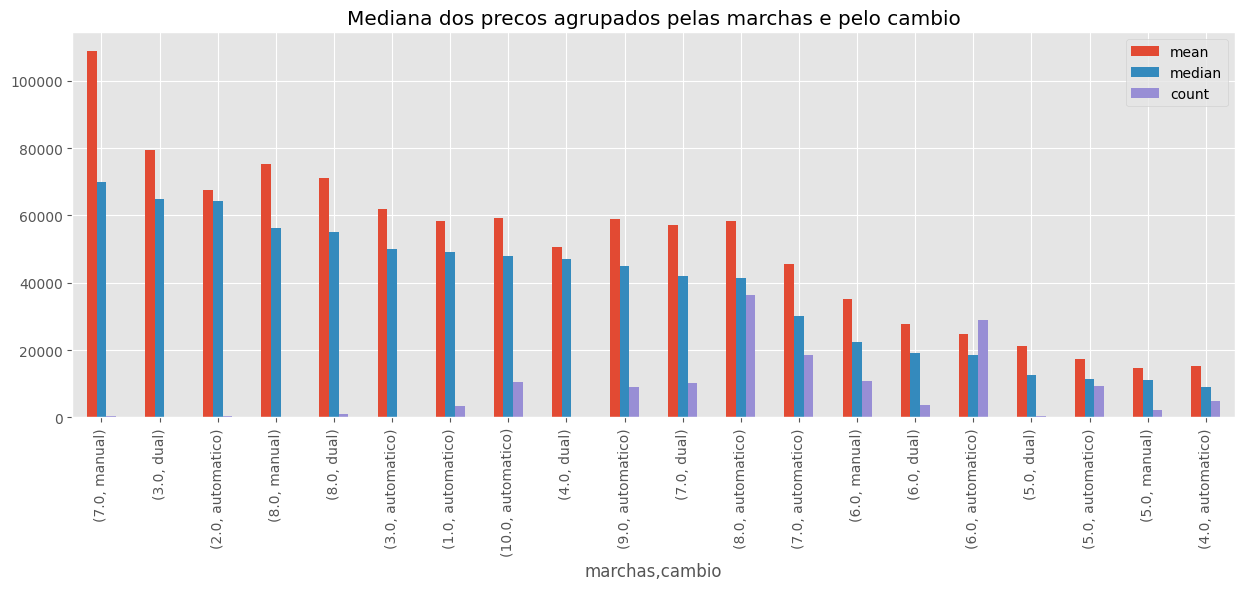

In [32]:
train.groupby(['marchas','cambio'])['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=False).head(50).plot(kind='bar',figsize=(15, 5))
plt.title('Mediana dos precos agrupados pelas marchas e pelo cambio')

In [33]:
train['accident'].value_counts()

accident
None reported                             115472
At least 1 accident or damage reported     33371
Name: count, dtype: int64

In [34]:
train.groupby('accident')['price'].agg(['mean', 'median', 'count']).query('count > 10').sort_values(by='median',ascending=False).head(50)

mean   median   count
accident                                                             
None reported                           48694.896105  35000.0  115472
At least 1 accident or damage reported  25385.366965  18000.0   33371

In [35]:
train['ext_col'].value_counts()

ext_col
Black                                 38914
White                                 34936
Gray                                  20308
Silver                                13669
Blue                                  11708
                                      ...  
Frozen White                              3
Granite Crystal Metallic Clearcoat        3
Mango Tango Pearlcoat                     2
BLUE                                      2
Aventurine Green Metallic                 2
Name: count, Length: 319, dtype: int64

Visualizando 5 transformacoes para as colunas numericas

- StandardScaler()
- MinMaxScaler()
- BoxCoxTransformer()
- LogCpTransformer()
- YeoJohnsonTransformer()

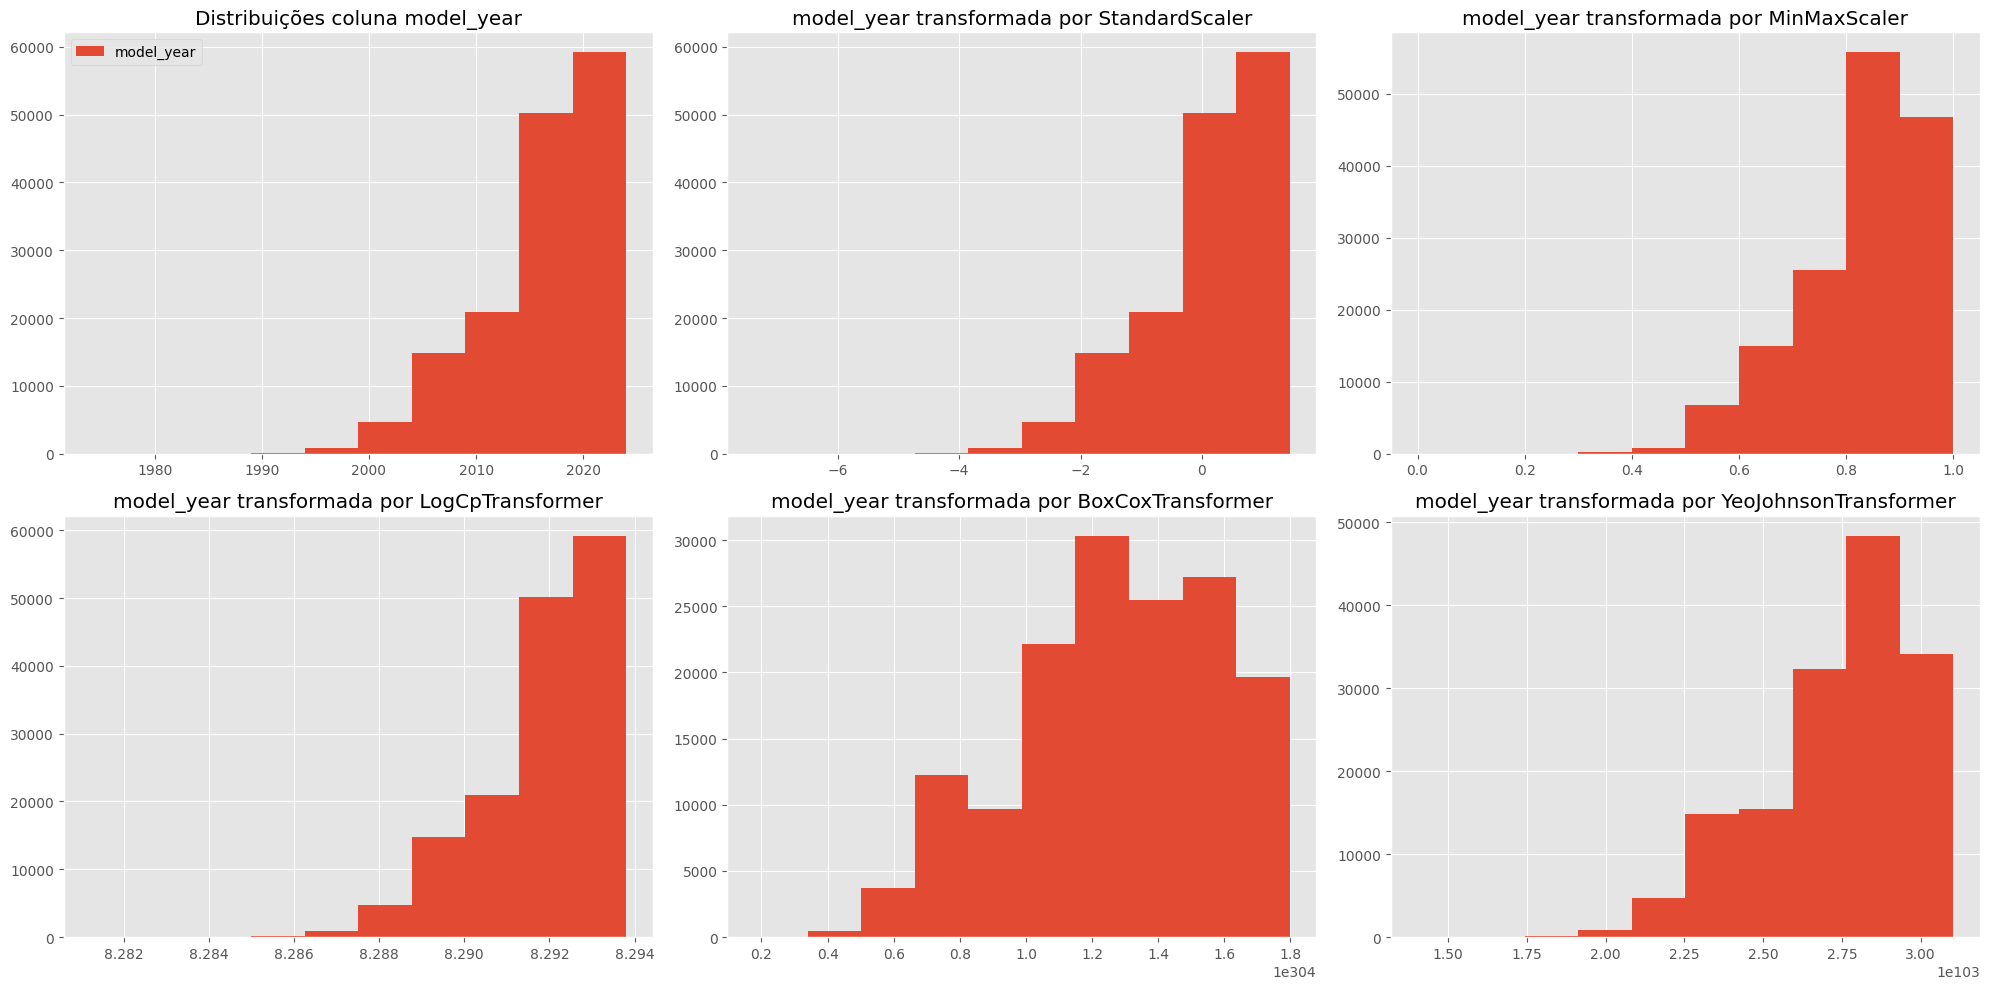

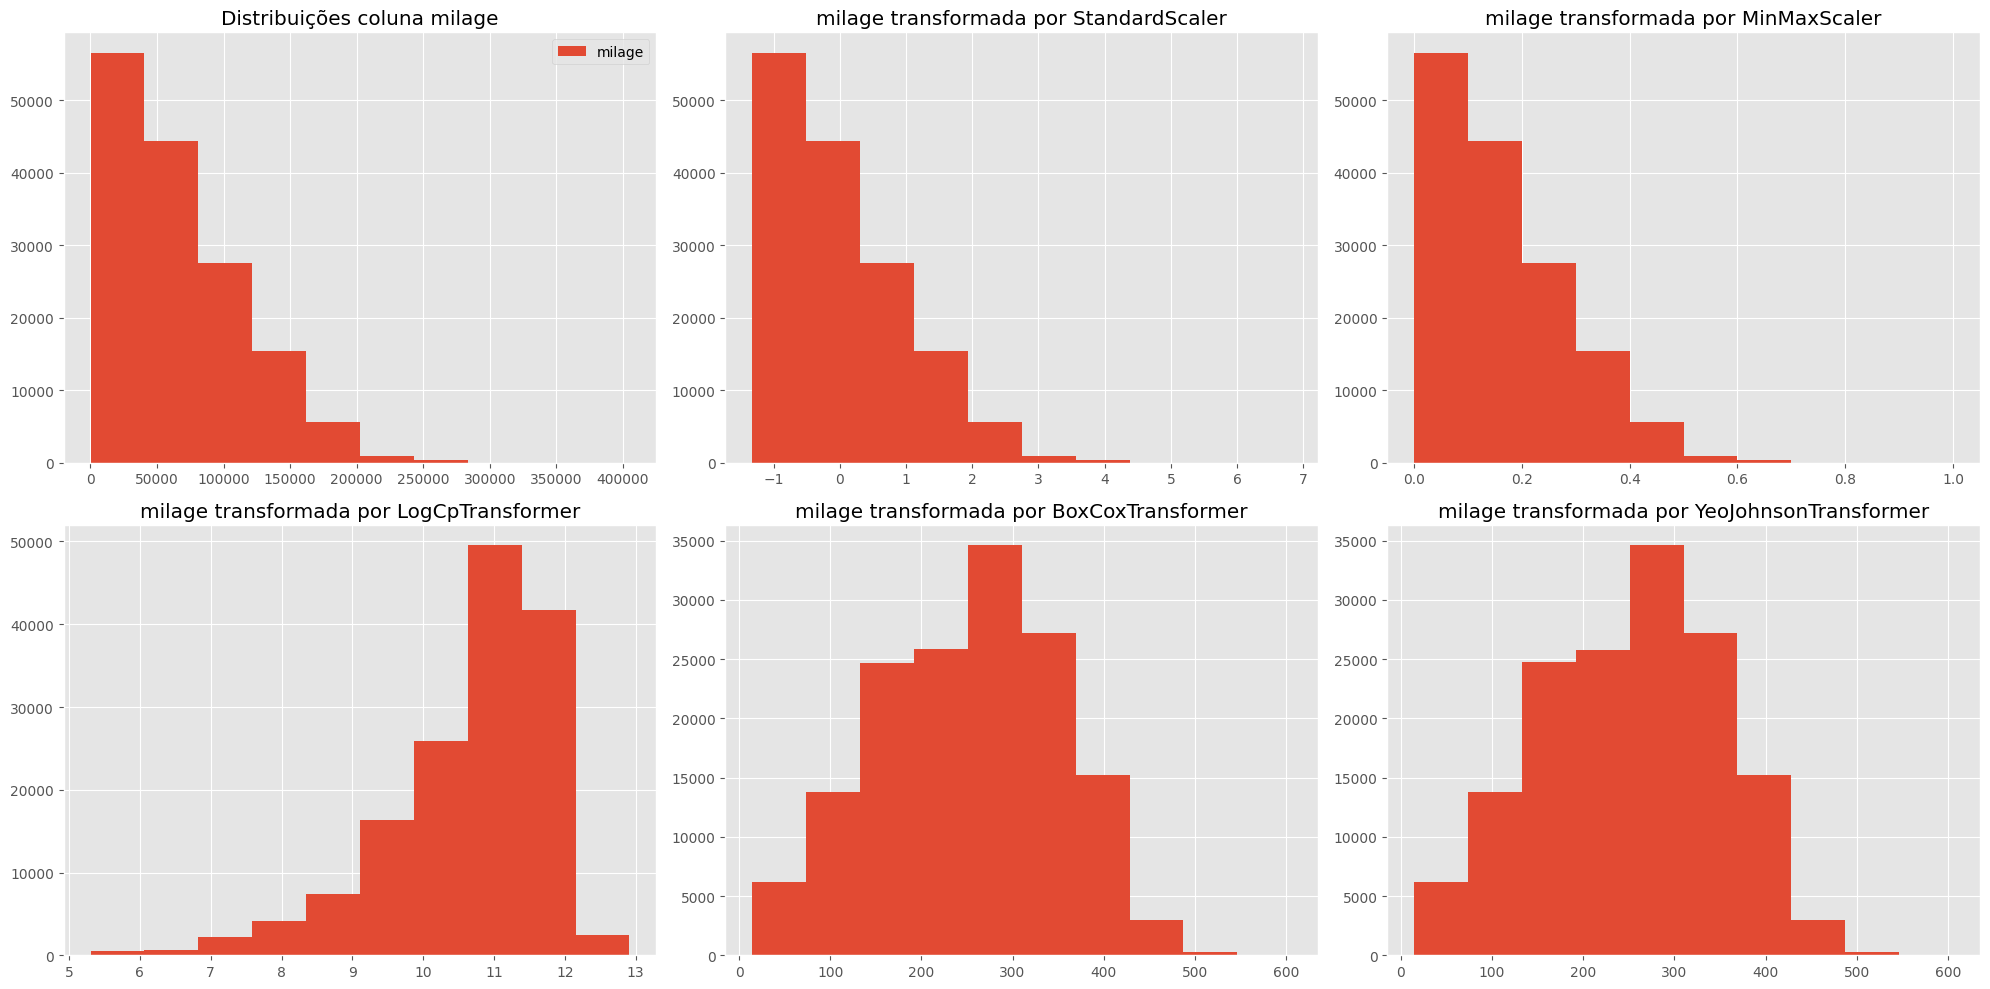

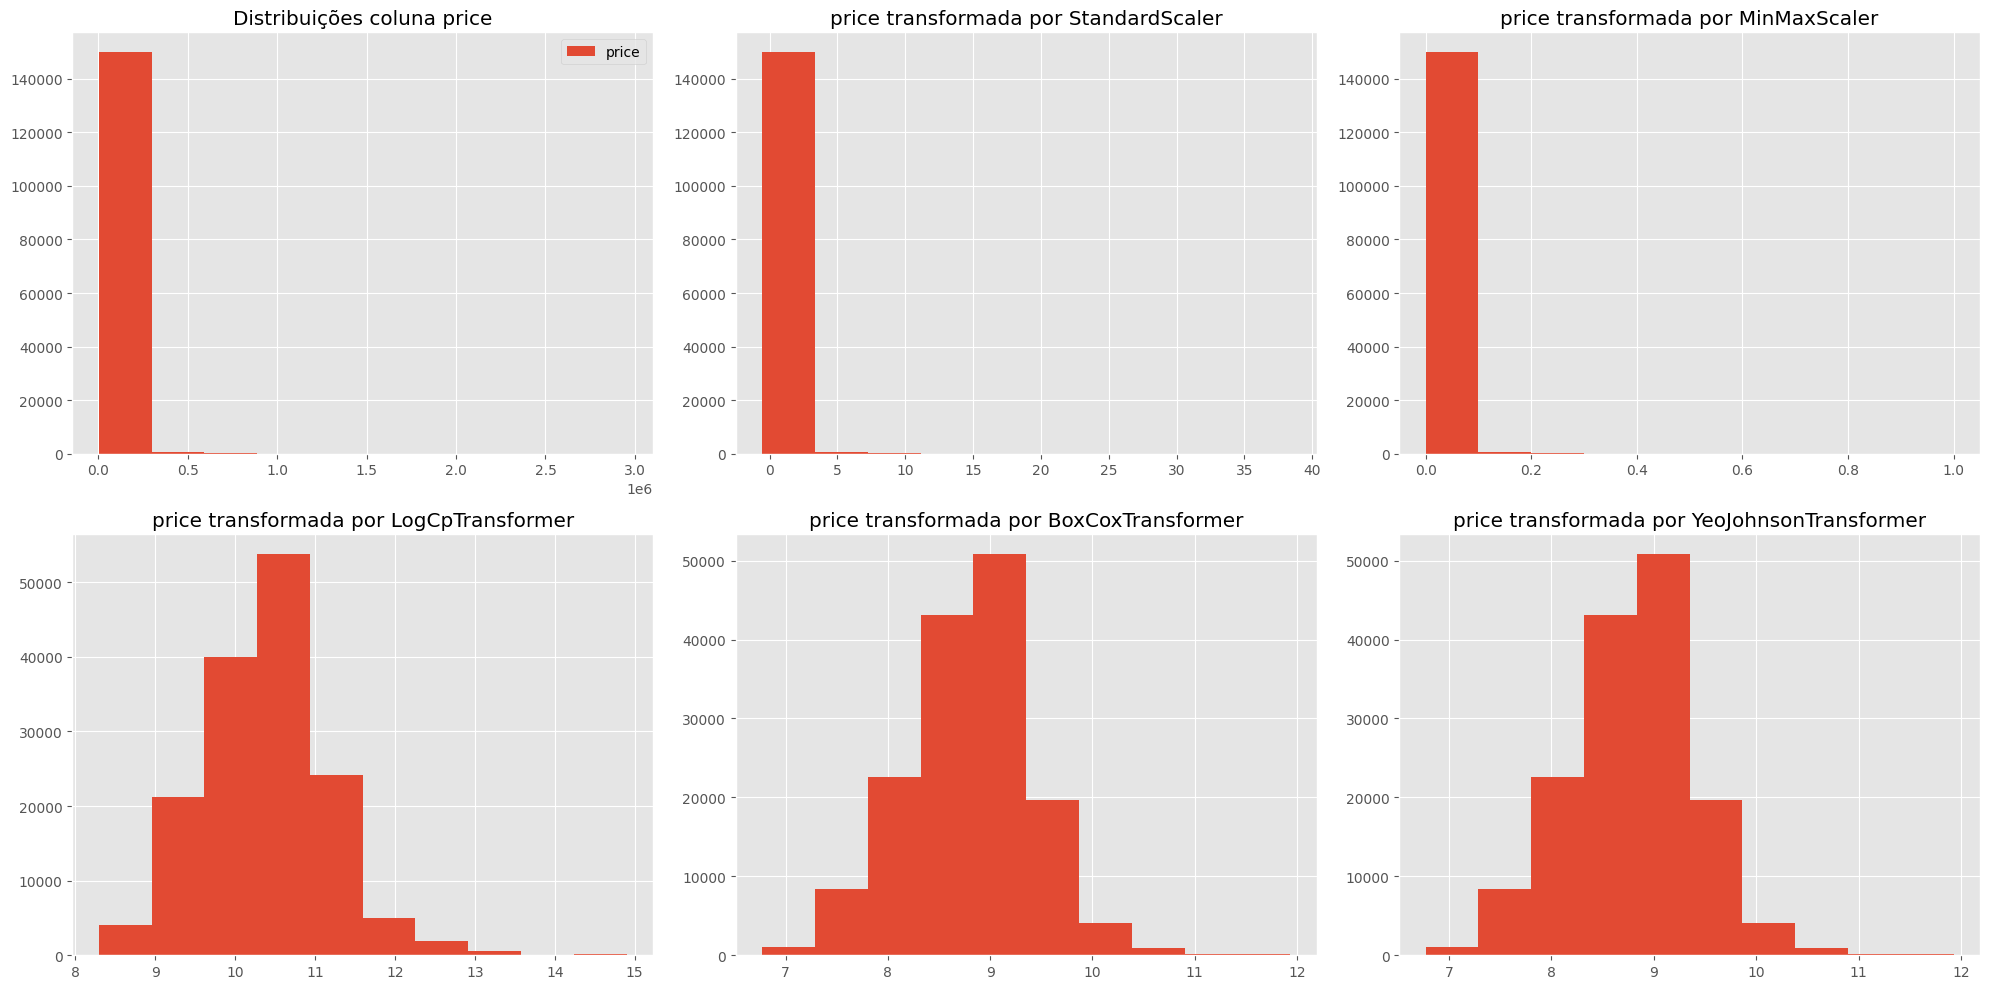

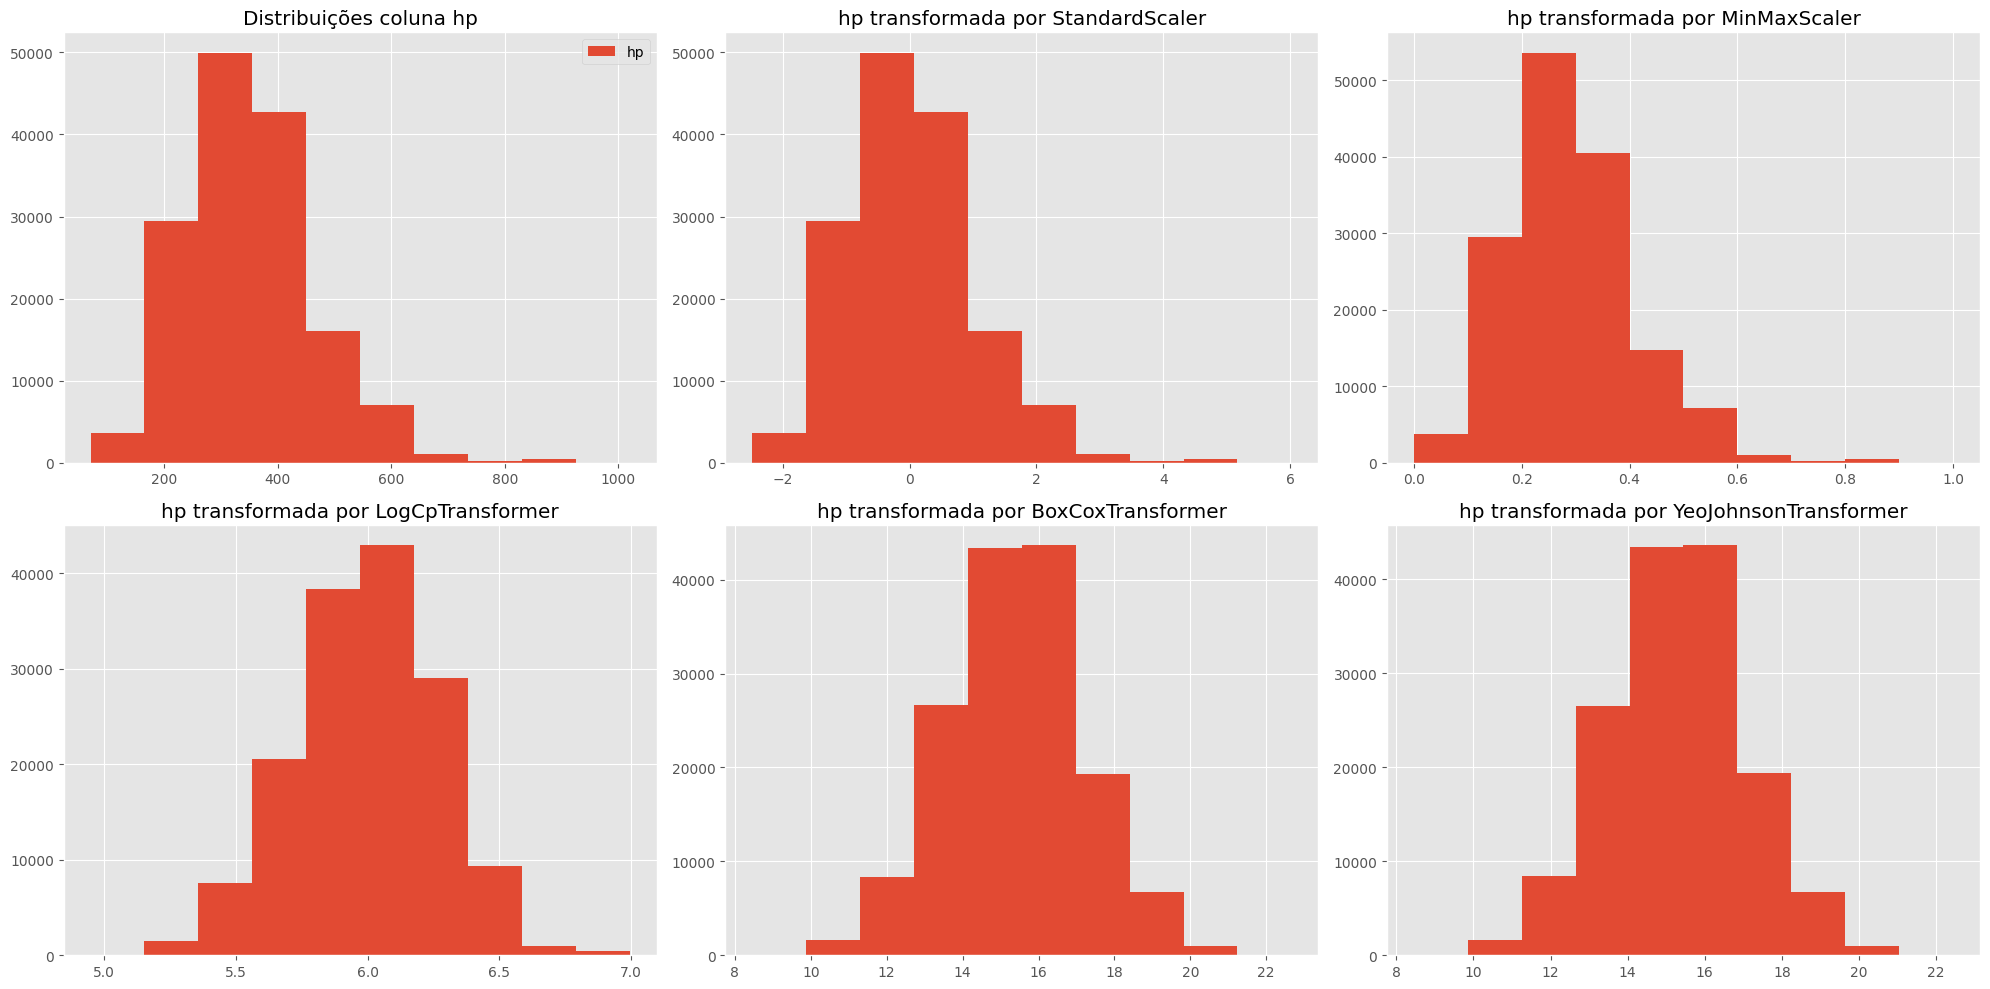

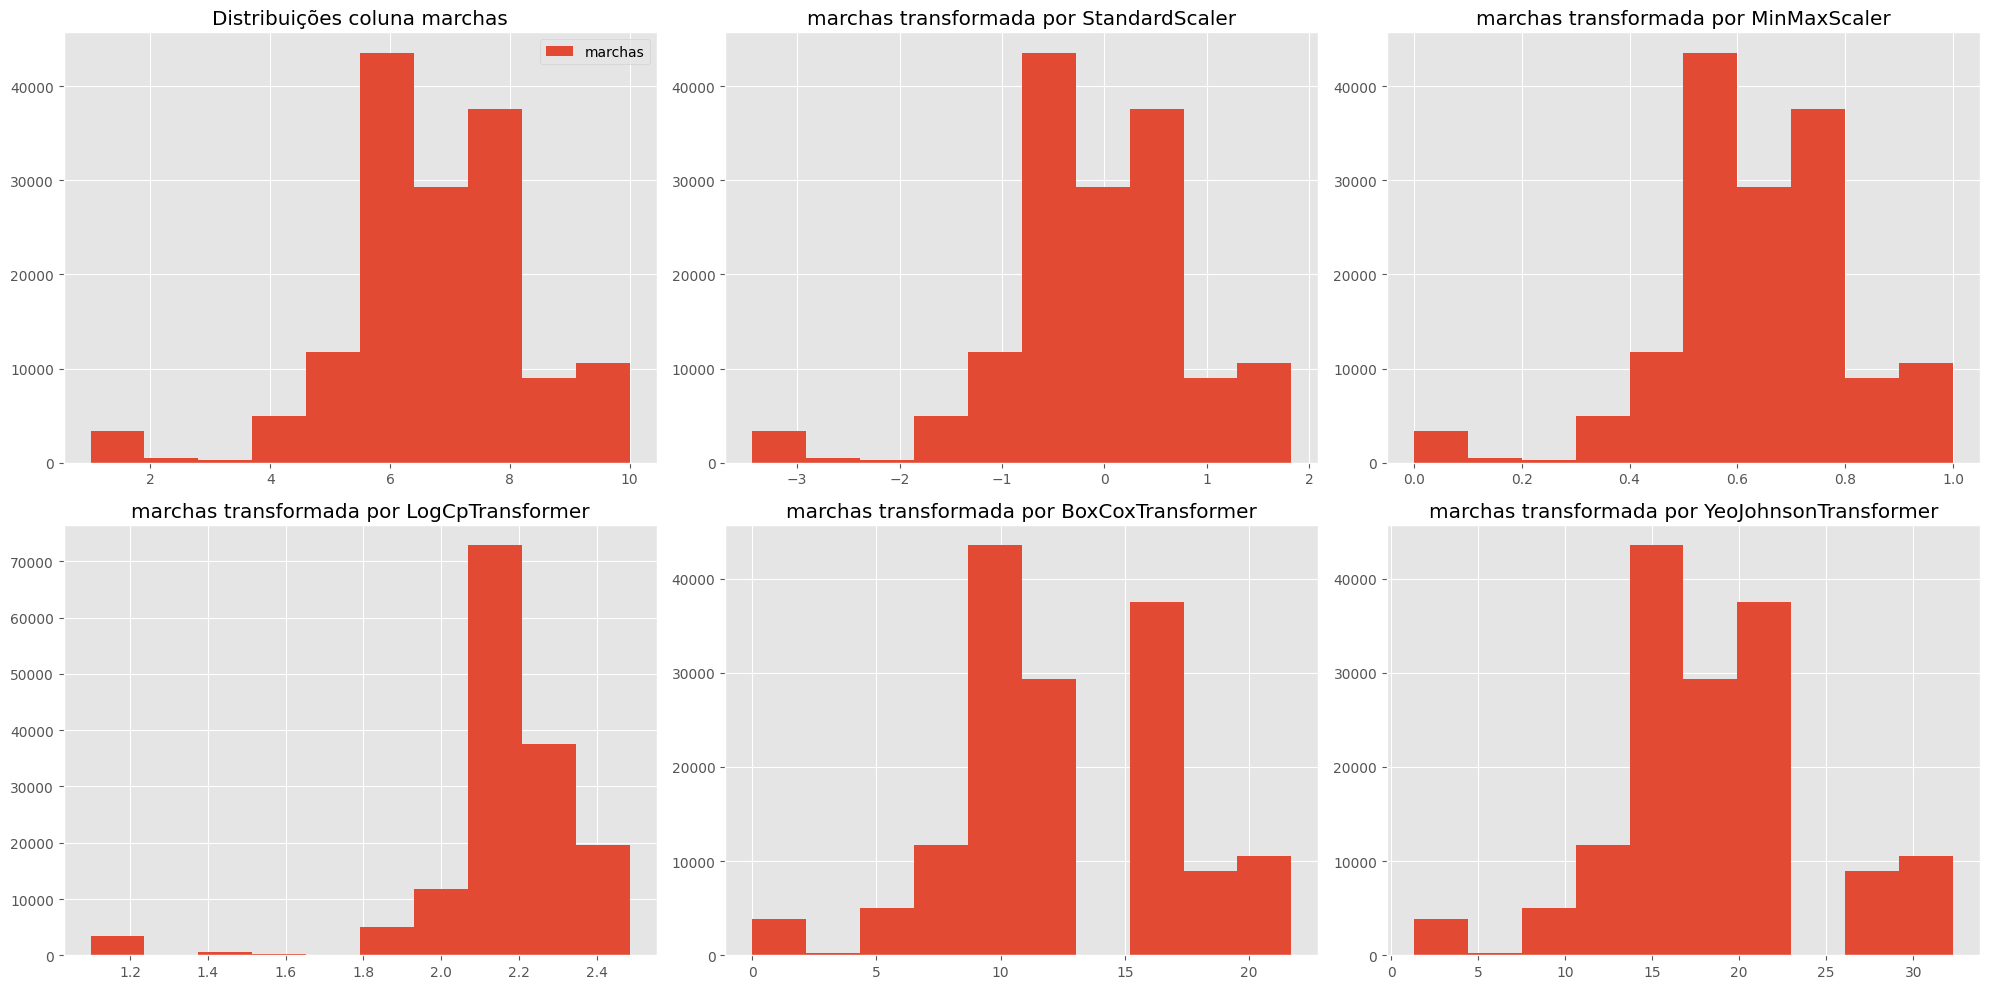

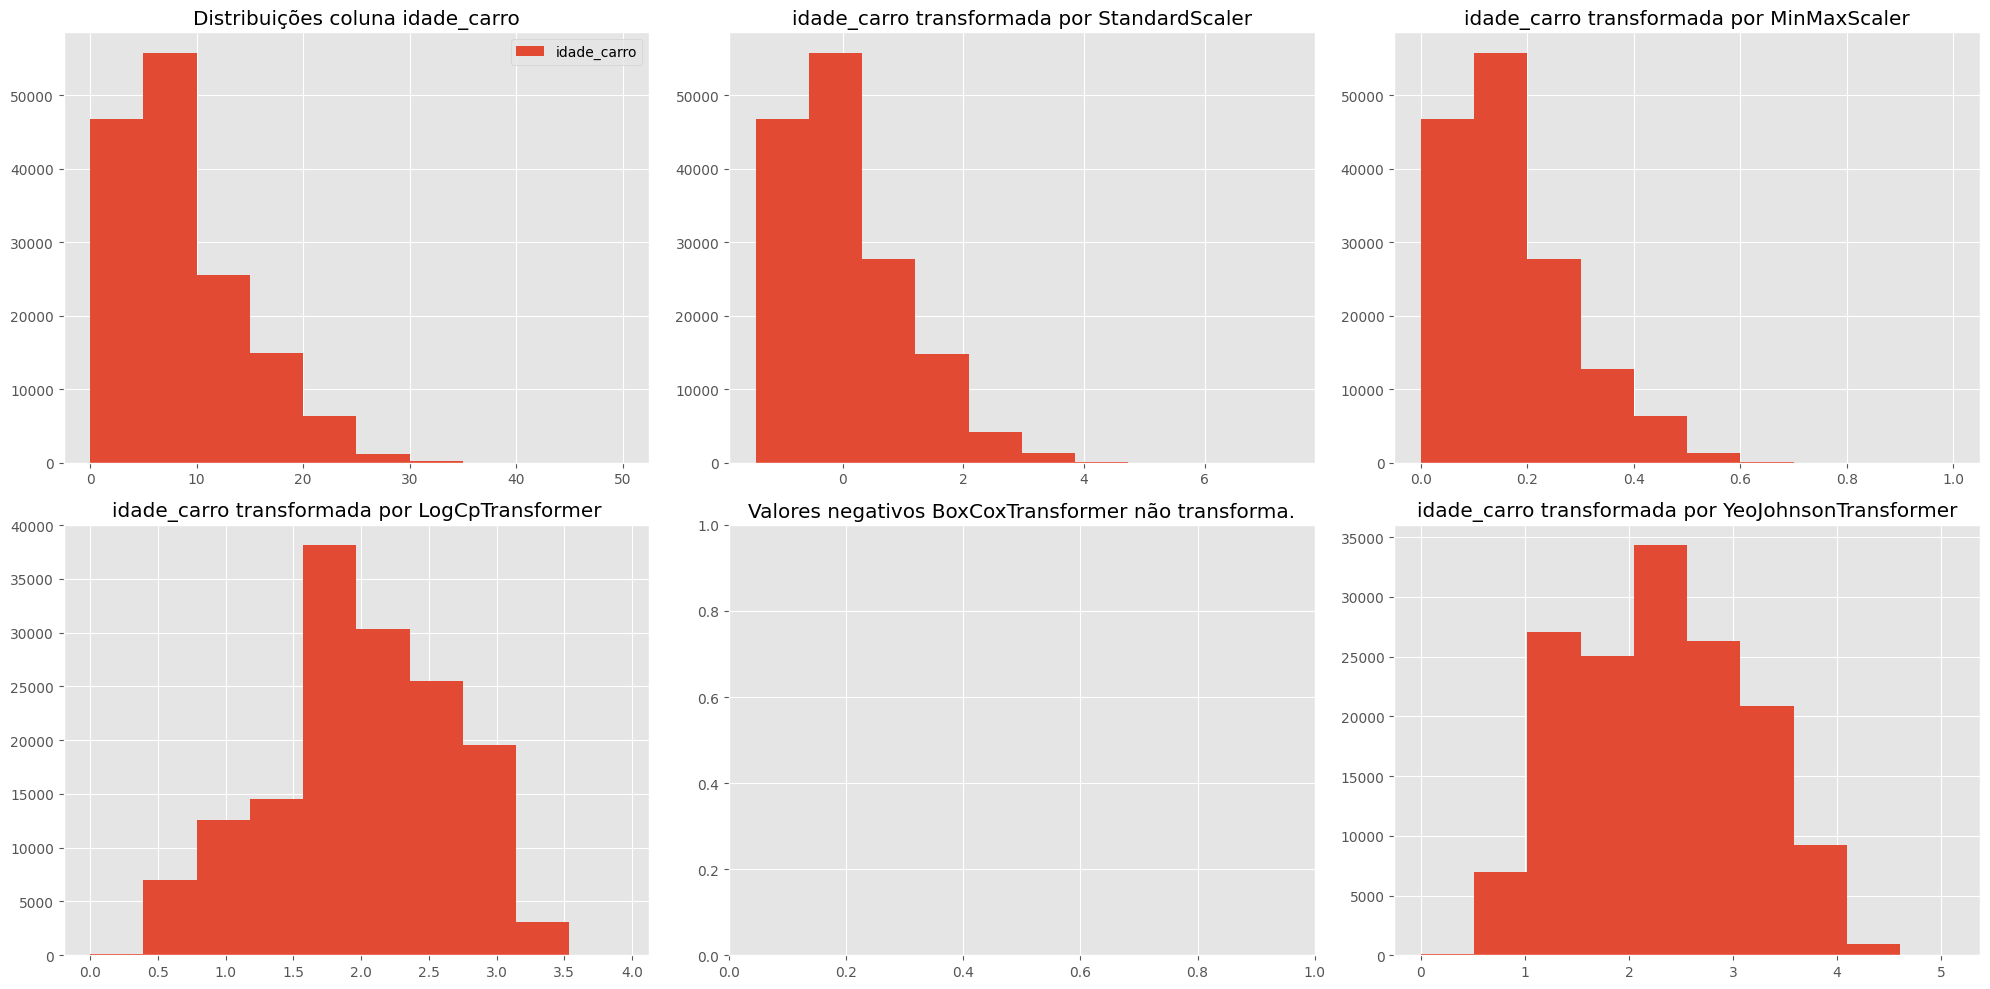

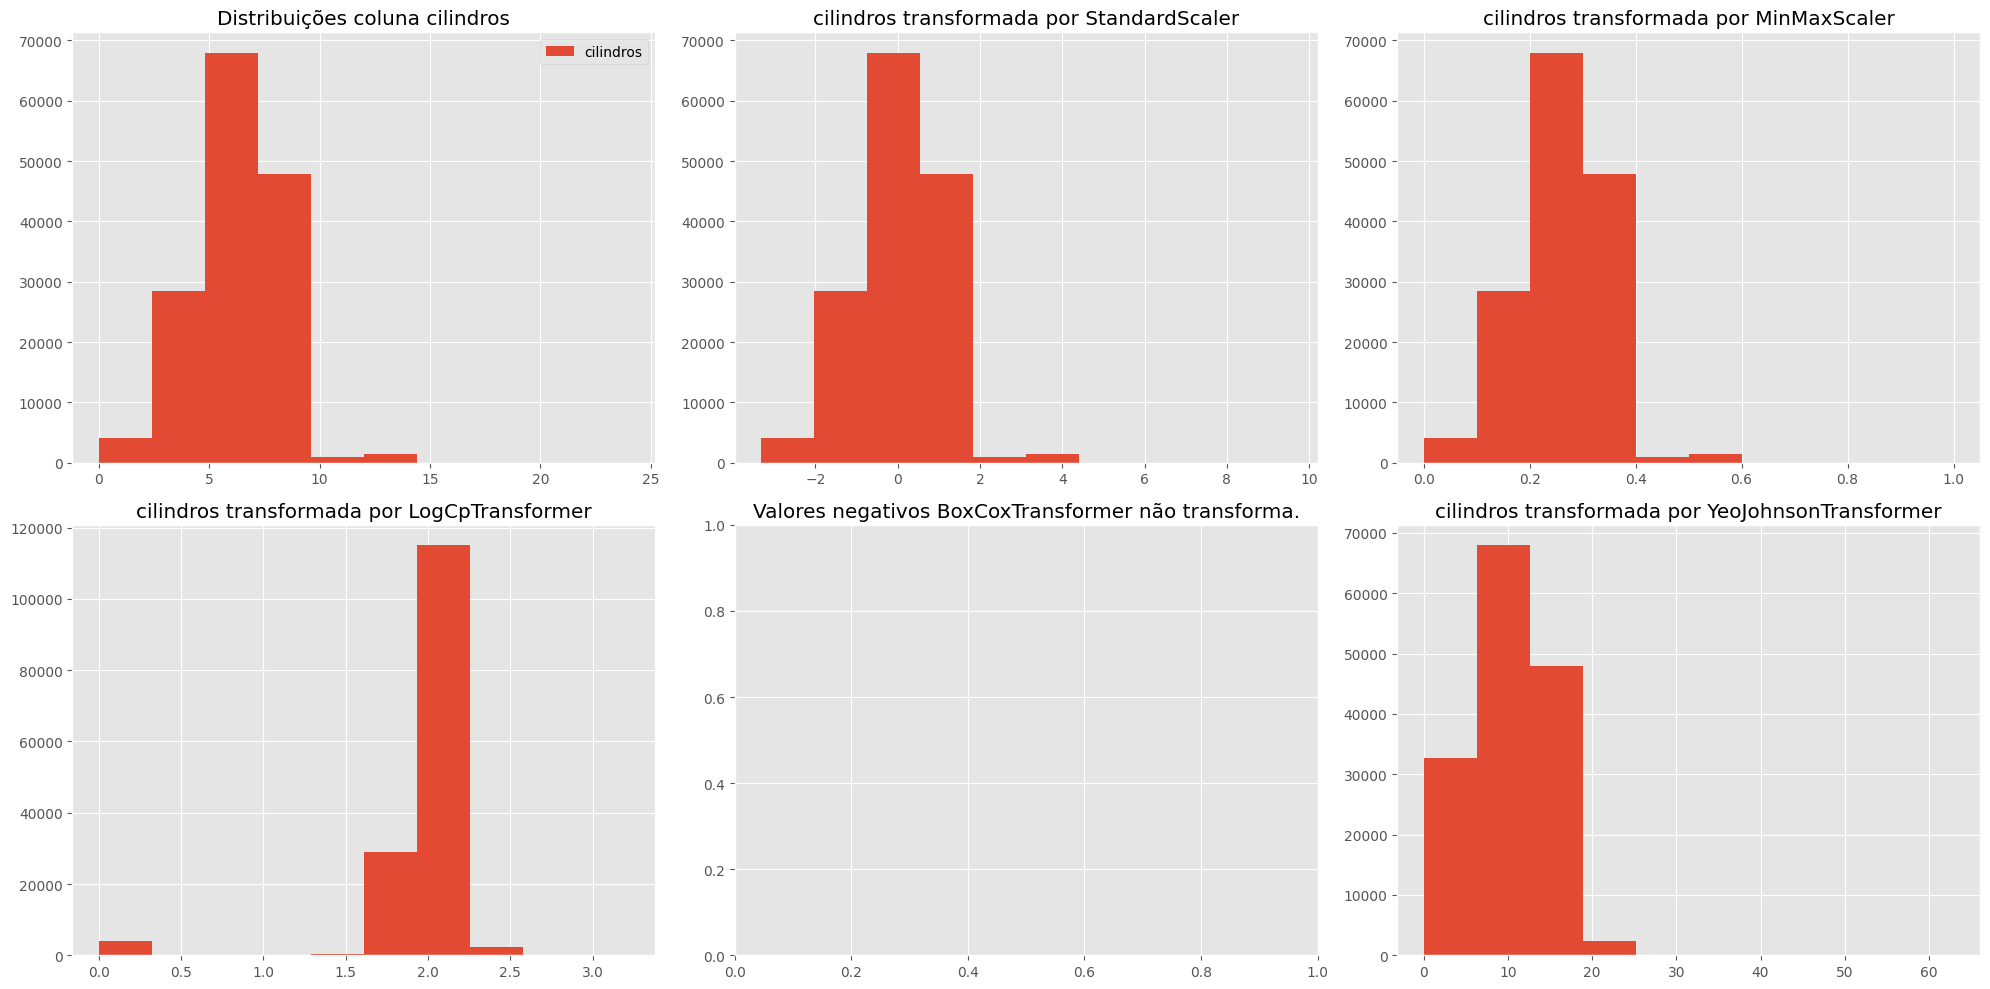

In [38]:
train_numerical_sem_nan = train.copy()
float_cols = train_numerical_sem_nan.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="median")
train_numerical_sem_nan[float_cols] = imputer.fit_transform(train_numerical_sem_nan[float_cols])
col_numeric = ['model_year', 'milage', 'price', 'hp', 'marchas','idade_carro','cilindros']
for col in col_numeric:
    stand = StandardScaler()
    norm = MinMaxScaler()
    box = BoxCoxTransformer()
    log = LogCpTransformer()
    jonson = YeoJohnsonTransformer()

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    axes[0][0].hist(train_numerical_sem_nan[col], label=col)
    axes[0][0].set_title(f'Distribuições coluna {col}')
    axes[0][0].legend()

    axes[0][1].hist(stand.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_stand')
    axes[0][1].set_title(f'{col} transformada por StandardScaler')

    axes[0][2].hist(norm.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_norm')
    axes[0][2].set_title(f'{col} transformada por MinMaxScaler')

    axes[1][0].hist(log.fit_transform(train_numerical_sem_nan[[col]]), label=f'{col}_log')
    axes[1][0].set_title(f'{col} transformada por LogCpTransformer')

    try:
        axes[1][1].hist(box.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_box')
        axes[1][1].set_title(f'{col} transformada por BoxCoxTransformer')

    except ValueError:
        axes[1][1].set_title('Valores negativos BoxCoxTransformer não transforma.')

    axes[1][2].hist(jonson.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_jonson')
    axes[1][2].set_title(f'{col} transformada por YeoJohnsonTransformer')

    plt.tight_layout()
    plt.show()

In [39]:
train.groupby('ext_col')['price'].agg(['mean', 'median', 'count']).query('count > 1000').sort_values(by='median',ascending=False).head(25).round(0)

mean   median  count
ext_col                         
Gray     47617.0  35700.0  20308
Green    50972.0  34955.0   2175
Blue     40396.0  30000.0  11708
Black    42382.0  29500.0  38914
White    40317.0  29500.0  34936
Red      39556.0  24999.0   7881
Silver   31625.0  20000.0  13669
Gold     23724.0  12500.0   1335

In [40]:
train.groupby('brand')['price'].agg(['mean', 'median', 'count']).query('count > 2980').sort_values(by='median',ascending=False).head(25).round(0)

mean   median  count
brand                                 
Tesla          56014.0  47541.0   2981
Porsche        71320.0  45999.0   8504
RAM            52320.0  40000.0   3385
Land           52453.0  38900.0   7609
Mercedes-Benz  50749.0  36000.0  15329
Ford           40077.0  32000.0  18531
Chevrolet      41394.0  32000.0  13167
BMW            43240.0  31000.0  13656
Cadillac       45315.0  30000.0   3736
Audi           41266.0  29900.0   8665
Jeep           33736.0  29000.0   5173
Lexus          34452.0  25495.0   6891
Toyota         29001.0  22000.0   7092
Nissan         28793.0  18000.0   3178

In [41]:
train.groupby('int_col')['price'].agg(['mean', 'median', 'count']).query('count > 4000').sort_values(by='median',ascending=False).head(25).round(0)/train.shape[0]

mean    median     count
int_col                              
Red      0.389203  0.275801  0.027177
Brown    0.312274  0.238023  0.030883
Black    0.300326  0.218795  0.571360
Beige    0.197022  0.130946  0.130031
Gray     0.184537  0.116028  0.112905

# 5_Tratamento_Dados

**Foi aplicado os seguintes tratamentos ao conjunto de dados**

1. **Retirando IDs**
    - Remove a coluna `id` dos conjuntos de dados `train_x` e `test_x`.

2. **Criando a Coluna Cilindros**
    - Adiciona uma nova coluna representando o número de cilindros extraído dos dados da coluna `engine`.

3. **Criando a Coluna "HP"**
    - Cria uma coluna para a potência do motor (HP) extraída da coluna `engine`.

4. **Criando a Coluna "Marchas**
    - Adiciona uma coluna que representa o número de marchas do veículo extraído dos dados da coluna `transmission`.

5. **Criando a Coluna Idade dos Carros**
    - Cria uma coluna para a idade dos carros, calculada a partir dos dados da coluna `model_year`.

6. **Criando a Coluna Câmbio**
    - Adiciona uma coluna para o tipo de câmbio do veículo extraído dos dados da coluna `transmission`.

7. **Dropando Colunas**
    - Remove as colunas model, `model_year`, `model`, `engine`, `transmission` e `clean_title` dos conjuntos de dados.

8. **Imputação dos valores faltantes na Coluna Marchas"**
    - Preenche valores faltantes na coluna `marchas` utilizando um modelo de imputação treinado com as características `cambio`, `fuel_type`, `hp`, `idade_carro`,`cilindros`.

9. **Imputação dos valores faltantes na Coluna HP"**
    - Preenche valores faltantes na coluna `HP` utilizando um modelo de imputação treinado com as características `cambio`, `fuel_type`, `marchas`, `idade_carro`,`cilindros`.

10. **Imputação dos valores faltantes na Coluna cilindros"**
    - Preenche valores faltantes na coluna `cilindros` utilizando um modelo de imputação treinado com as características `cambio`, `fuel_type`, `marchas`, `idade_carro`,`HP`.

11. **One-Hot Encoding para Colunas Categóricas**
    - Aplicamos One-Hot Encoding para as colunas categóricas com uma frequência mínima de especificada para cada coluna, criando novas colunas para categorias pouco frequentes.

12. **Normalização das Variáveis Numéricas**
    - Normalizamos as variáveis numéricas utilizando a técnica de escalonamento StandardScaler.

Após todo os tratamentos os conjuntos de dados ficaram com os seguintes tamanhos:

- treino: `(150826, 53)`

- teste: `(37707, 53)`

In [19]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados'
else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")
    diretorio = 'dados'

tratar_dados = False

if "dados_tratados.pkl" not in arquivos or tratar_dados == True:
     ## separando as x e y
    train_x = train.drop("price", axis=1)
    train_y = train["price"]

    test_x = test.drop("price", axis=1)
    test_y = test["price"]
    
    trat = Tratamento()

    ## retirando ids
    train_x_sem_id, train_x_id = trat.retirando_ids(train_x)
    test_x_sem_id, test_x_id = trat.retirando_ids(test_x)
    
    ## criando coluna cilindros
    train_x_cil = trat.extrair_cilindros(train_x_sem_id)
    test_x_cil = trat.extrair_cilindros(test_x_sem_id)
    
    ## criando coluna hp
    train_x_hp = trat.extrair_hp(train_x_cil)
    test_x_hp = trat.extrair_hp(test_x_cil)
    
    ## criando coluna marchas
    train_x_marchas = trat.extrair_marchas(train_x_hp)
    test_x_marchas = trat.extrair_marchas(test_x_hp)
    
    ## criando a coluna idade dos carros
    train_x_idade = trat.extrair_idade_carros(train_x_marchas)
    test_x_idade = trat.extrair_idade_carros(test_x_marchas)
    
    ## criando coluna cambio
    train_x_cambio = trat.extrair_cambio(train_x_idade)
    test_x_cambio = trat.extrair_cambio(test_x_idade)
    
    ## drop colunas model, model_year, engine, transmission, clean_title
    
    columns_drop = ['model','model_year','engine','transmission','clean_title']
    train_x_drop = trat.drop_columns(train_x_cambio,columns_drop)
    test_x_drop = trat.drop_columns(test_x_cambio, columns_drop)
    
    ## inputando valores faltantes coluna marchas
    categorical_features_marchas = ['cambio','fuel_type'] 
    numerical_features_marchas = ['hp', 'idade_carro','cilindros',]
    classe_marchas = 'marchas'
    train_x_marchas_sem_na, modelo_inputer_marchas = trat.imputar_dados_faltantes_modelo(train_x_drop,classe_marchas,
                                                                                    categorical_features=categorical_features_marchas,
                                                                                    numerical_features=numerical_features_marchas)
    test_x_marchas_sem_na = trat.imputar_dados_faltantes_modelo(test_x_drop,
                                                           classe_marchas,
                                                           categorical_features=categorical_features_marchas,
                                                           numerical_features=numerical_features_marchas,
                                                           modelo_imputer = modelo_inputer_marchas)
    
    ## inputando valores faltantes coluna hp
    categorical_features_hp = ['cambio','fuel_type'] 
    numerical_features_hp = ['marchas', 'idade_carro','cilindros',]
    classe_hp = 'hp'
    train_x_hp_sem_na, modelo_inputer_hp = trat.imputar_dados_faltantes_modelo(train_x_marchas_sem_na,
                                                                          classe_hp,
                                                                        categorical_features=categorical_features_hp,
                                                                        numerical_features=numerical_features_hp)
    test_x_hp_sem_na = trat.imputar_dados_faltantes_modelo(test_x_marchas_sem_na,
                                                        classe_hp,
                                                    categorical_features=categorical_features_hp,
                                                    numerical_features=numerical_features_hp,
                                                    modelo_imputer = modelo_inputer_hp)
    
    ## imputando valores faltantes coluna cilindros
    
    categorical_features_cilindros = ['cambio','fuel_type'] 
    numerical_features_cilindros= ['marchas', 'idade_carro','hp',]
    classe_cilindros = 'cilindros'
    train_x_cilindros_sem_na, modelo_inputer_cilindros = trat.imputar_dados_faltantes_modelo(train_x_hp_sem_na,
                                                                          classe_cilindros,
                                                                        categorical_features=categorical_features_cilindros,
                                                                        numerical_features=numerical_features_cilindros)
    test_x_cilindros_sem_na = trat.imputar_dados_faltantes_modelo(test_x_hp_sem_na,
                                                        classe_cilindros,
                                                    categorical_features=categorical_features_cilindros,
                                                    numerical_features=numerical_features_cilindros,
                                                    modelo_imputer = modelo_inputer_cilindros)
    
    ## criando onhot nas colunas categoricas
    colunas_onhot = ['int_col', 'ext_col', 'brand','accident','fuel_type','cambio']
    porcentagem_frequencia_onhot = [0.02, 0.05, 0.01, 0.03, 0.05, 0.05]
    train_x_onhot, modelo_onhot = trat.criando_onehot(train_x_cilindros_sem_na, 
                                                      colunas_onhot,
                                                      model_onehot = None, 
                                                      list_frequenci= porcentagem_frequencia_onhot)
    
    test_x_onhot = trat.criando_onehot(test_x_cilindros_sem_na,
                                       colunas_onhot, 
                                       model_onehot = modelo_onhot, 
                                       list_frequenci= porcentagem_frequencia_onhot)
    
    ## normalizando as colunas numericas
    col_numeric_stard = ['milage', 'cilindros', 'hp','marchas','idade_carro']

    train_x_stard_numerical, modelo_stard = trat.transformacao_variaveis_numericas(train_x_onhot,
                                                                               col_transformada=col_numeric_stard)
    test_x_stard_numerical = trat.transformacao_variaveis_numericas(test_x_onhot,
                                                                col_transformada=col_numeric_stard, 
                                                                modelo_imputer=modelo_stard)
    
    print(train_x_onhot.shape, test_x_onhot.shape)
    print('Dados tratados!')

    dados_tratados = {}
    dados_tratados['x_train'] = train_x_onhot
    dados_tratados['x_test'] = test_x_onhot
    dados_tratados['y_train'] = train_y
    dados_tratados['y_test'] = test_y
    dados_tratados['categorical_features_marchas'] = categorical_features_marchas
    dados_tratados['numerical_features_marchas'] = numerical_features_marchas
    dados_tratados['modelo_inputer_marchas'] = modelo_inputer_marchas
    dados_tratados['categorical_features_hp'] = categorical_features_hp
    dados_tratados['numerical_features_hp'] = numerical_features_hp
    dados_tratados['modelo_inputer_hp'] = modelo_inputer_hp
    dados_tratados['categorical_features_cilindros'] = categorical_features_cilindros
    dados_tratados['numerical_features_cilindros'] = numerical_features_cilindros
    dados_tratados['modelo_inputer_cilindros'] = modelo_inputer_cilindros
    dados_tratados['columns_drop'] = columns_drop
    dados_tratados['colunas_onhot'] = colunas_onhot
    dados_tratados['porcentagem_frequencia_onhot'] = porcentagem_frequencia_onhot
    dados_tratados['modelo_onhot'] = modelo_onhot
    dados_tratados['col_numeric_stard'] = col_numeric_stard
    dados_tratados['modelo_stard'] = modelo_stard
    with open(diretorio + '/dados_tratados.pkl', 'wb') as f:
        pickle.dump(dados_tratados, f)

else:
    with open(diretorio + '/dados_tratados.pkl', 'rb') as f:
        dados_tratados = pickle.load(f)

    x_train = dados_tratados['x_train']
    x_test = dados_tratados['x_test']
    y_train = dados_tratados['y_train'].values
    y_test = dados_tratados['y_test'].values
    
    categorical_features_marchas = dados_tratados['categorical_features_marchas']
    numerical_features_marchas = dados_tratados['numerical_features_marchas']
    modelo_inputer_marchas = dados_tratados['modelo_inputer_marchas']
    
    categorical_features_hp = dados_tratados['categorical_features_hp']
    numerical_features_hp = dados_tratados['numerical_features_hp']
    modelo_inputer_hp =  dados_tratados['modelo_inputer_hp']
    
    categorical_features_cilindros = dados_tratados['categorical_features_cilindros']
    numerical_features_cilindros = dados_tratados['numerical_features_cilindros']
    modelo_inputer_cilindros = dados_tratados['modelo_inputer_cilindros']
    
    columns_drop = dados_tratados['columns_drop']
    colunas_onhot = dados_tratados['colunas_onhot']
    porcentagem_frequencia_onhot = dados_tratados['porcentagem_frequencia_onhot']
    modelo_onhot = dados_tratados['modelo_onhot']
    
    col_numeric_stard = dados_tratados['col_numeric_stard']
    modelo_stard = dados_tratados['modelo_stard']
    
    print('X_treino:',x_train.shape, 'X_teste:',x_test.shape,  'Y_train:',y_train.shape, 'Y_teste:',y_test.shape,)
    print('Dowload dos dados com sucesso!')

x_train_colunms = x_train.copy()
x_test_columns = x_test.copy()

x_train = x_train.values
x_test = x_test.values


X_treino: (150826, 53) X_teste: (37707, 53) Y_train: (150826,) Y_teste: (37707,)
Dowload dos dados com sucesso!


# 6_Principais_caracteristicas

Utilizando a biblioteca [Shapley Additive exPlanations (SHAP)](https://shap.readthedocs.io/en/latest/), podemos identificar as variáveis mais importantes no modelo de regressão, com destaque para as variáveis `milage`, `hp`, `idade_carro`, `brand_Porsche`, e `brand_Land`.

Ao analisar o gráfico de `summary_plot`, observamos os seguintes insights:

- **`milage` (quilometragem)**: Valores **baixos** de quilometragem (em azul) têm um impacto **positivo** nas previsões, enquanto valores **altos** (em vermelho) impactam **negativamente**. Isso indica que carros com quilometragem mais alta tendem a ter preços **mais baixos**, enquanto veículos com baixa quilometragem são avaliados com preços **mais altos**.

- **`hp` (potência)**: Valores **altos** de potência estão associados a impactos **positivos** nas previsões, sugerindo que carros com mais potência são, em geral, previstos com preços **mais altos**.

- **`idade_carro` (idade do carro)**: Carros mais antigos (em vermelho) têm um impacto **negativo** no valor previsto, enquanto carros mais novos (em azul) têm um efeito **positivo**, o que é esperado, já que veículos mais novos geralmente possuem maior valor de mercado.

- **`brand_Porsche`**: A marca Porsche tem um impacto **fortemente positivo** nas previsões, indicando que os carros dessa marca são frequentemente associados a preços **mais elevados**, como esperado, dado o prestígio e o alto custo dos veículos Porsche.

- **`cambio_manual`**: Veículos com câmbio manual parecem ter um impacto **negativo** nas previsões, sugerindo que carros com câmbio manual são frequentemente avaliados com preços **mais baixos** em comparação com aqueles com câmbio automático ou dual.

- **`accident_At least 1 accident or damage reported` (acidente/dano reportado)**: Como esperado, a presença de acidentes ou danos reportados (valores em vermelho) tem um impacto **negativo** significativo, diminuindo o valor previsto do carro. Isso reflete a percepção de que carros com histórico de acidentes ou danos tendem a ser desvalorizados.

Este gráfico ajuda a visualizar o efeito de cada variável no modelo, ilustrando como diferentes características afetam o preço previsto de um veículo.



#![Analise Exploratória](imagens/shap_summary_plot.png)



In [20]:
# Supondo que shap_values já esteja definido como no código original
def df_shap_importancia(shap_values):
    # Convert Explanation objects to dictionaries
    if isinstance(shap_values, Explanation):
        cohorts = {"": shap_values}
    elif isinstance(shap_values, Cohorts):
        cohorts = shap_values.cohorts
    elif isinstance(shap_values, dict):
        cohorts = shap_values
    else:
        raise TypeError("The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!")

    # Desempacotando os Explanation objects
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())

    for i, exp in enumerate(cohort_exps):
        if not isinstance(exp, Explanation):
            raise TypeError("The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!")
        
        if len(exp.shape) == 2:
            # Colapsa as arrays de Explanation para o formato (#features,)
            cohort_exps[i] = exp.abs.mean(0)

        if cohort_exps[i].shape != cohort_exps[0].shape:
            raise DimensionError("Quando passar vários Explanation objects, eles devem ter o mesmo número de colunas de features!")

    # Pega os nomes dos recursos e valores de SHAP
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])

    # Verifica se não está vazio
    if len(values[0]) == 0:
        raise ValueError("O Explanation fornecido está vazio, então não há nada para extrair.")

    # Cria um DataFrame com as importâncias médias dos SHAP values
    df_importancias = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value': values.mean(axis=0)  # Média dos valores de SHAP para cada feature
    })

    # Ordena por ordem decrescente de importância
    df_importancias = df_importancias.sort_values(by='SHAP Value', ascending=False)

    # Mostra o DataFrame
    return df_importancias


In [22]:
if IN_COLAB:
    sys.path.append("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados")
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados'
else:
    # Adiciona o caminho da pasta 'dados' ao sys.path
    sys.path.append("dados")
    # Verifica os arquivos dentro da pasta 'dados'
    arquivos = os.listdir("dados")
    diretorio = 'dados'
    
shap.initjs()

treinamento_shap = False

if 'dados_importancia.pkl' not in arquivos or treinamento_shap == True:
    # Selecionando uma subamostra para reduzir o tempo de treinamento
    random_indices = np.random.choice(x_train.shape[0], 10000, replace=False)
    #subset_shap_values = shap_values[random_indices]
    subset_x_treino = x_train_colunms.iloc[random_indices]
    subset_y_treino = y_train[random_indices]
    
    model = RandomForestRegressor(verbose=0)
    model.fit(subset_x_treino, subset_y_treino)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(subset_x_treino, subset_y_treino)
    dados_importancia = {}
    dados_importancia['explainer'] = explainer
    dados_importancia['shape_values'] = shap_values
    dados_importancia['subset_x_treino'] = subset_x_treino
    dados_importancia['subset_y_treino'] = subset_y_treino
    importancia_shap = df_shap_importancia(shap_values)
    
    with open(diretorio +"/dados_importancia.pkl", "wb") as f:
        pickle.dump(dados_importancia, f)
    
    with open(diretorio + '/importancia_carcteristicas.pkl','wb') as f:
        pickle.dump(importancia_shap, f)
        
    print('Modelo treinado!')
else:
    dados_importancia = pickle.load(open(diretorio + '/dados_importancia.pkl', 'rb'))
    explainer = dados_importancia['explainer']
    shap_values = dados_importancia['shape_values']
    subset_x_treino = dados_importancia['subset_x_treino']
    subset_y_treino = dados_importancia['subset_y_treino'] 
    
    with open(diretorio + '/importancia_carcteristicas.pkl','rb') as f:
        importancia_shap = pickle.load(f)
        
    print('Dowload dos dados completados!')   

Dowload dos dados completados!


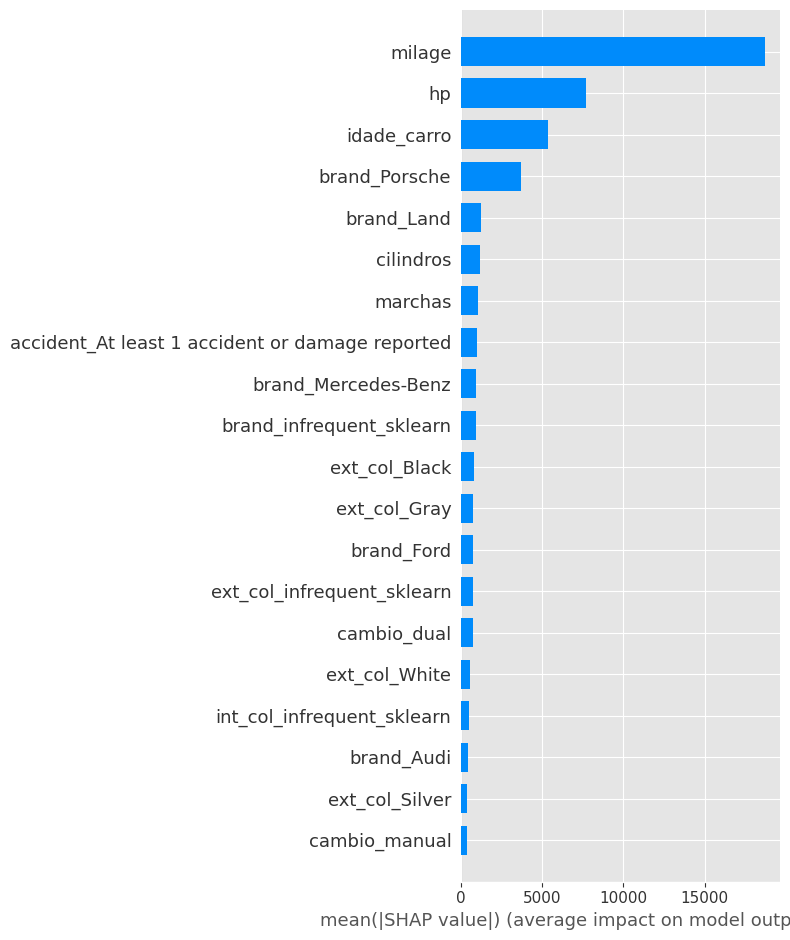

In [54]:
shap.summary_plot(shap_values, subset_x_treino, plot_type="bar", show=False)

In [9]:
#shap.force_plot(shap_values, subset_x_treino)

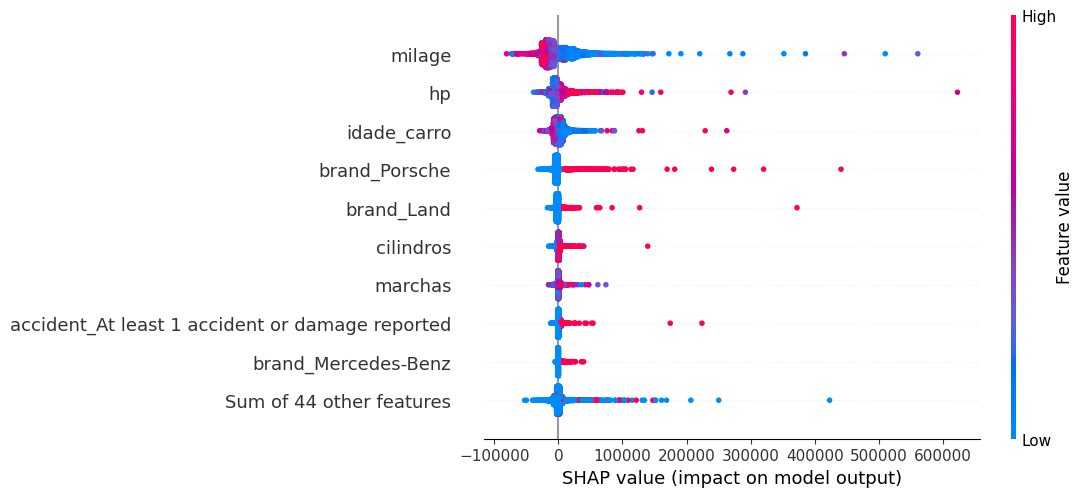

In [10]:
shap.plots.beeswarm(shap_values)

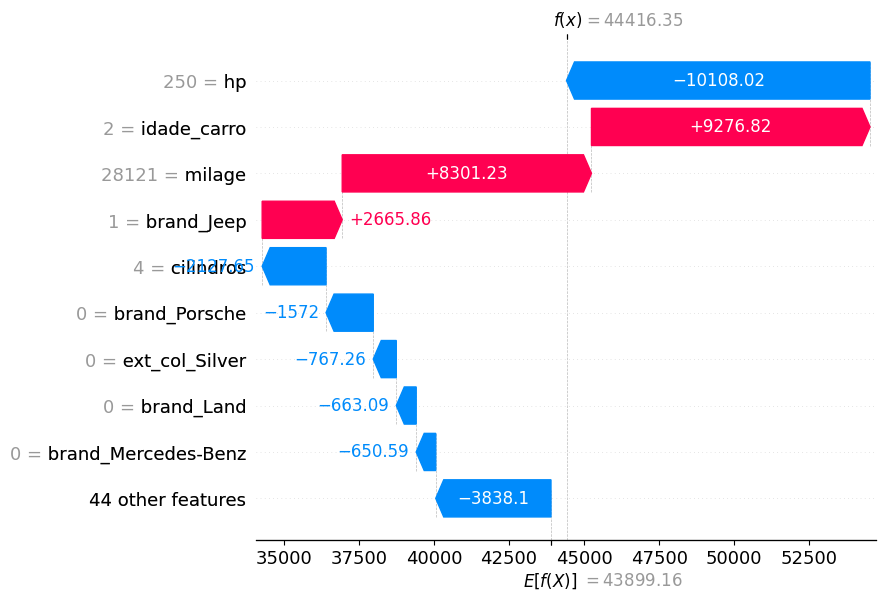

In [11]:
shap.plots.waterfall(shap_values[0])

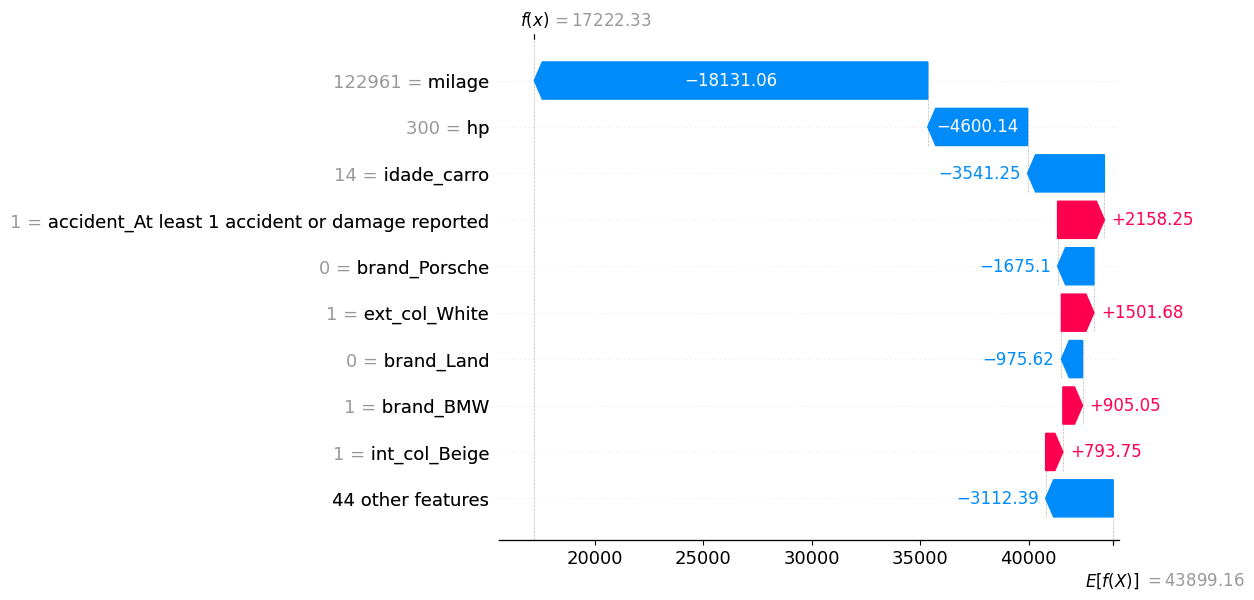

In [12]:
shap.plots.waterfall(shap_values[1])

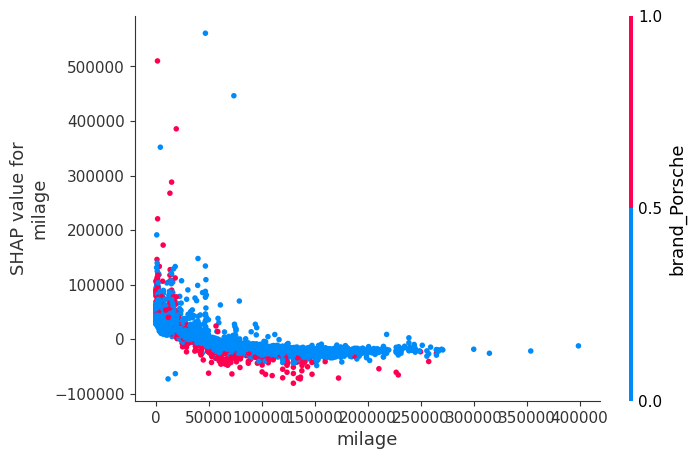

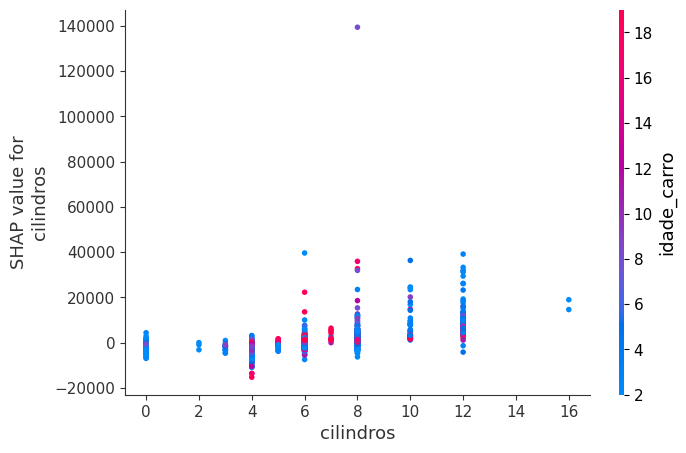

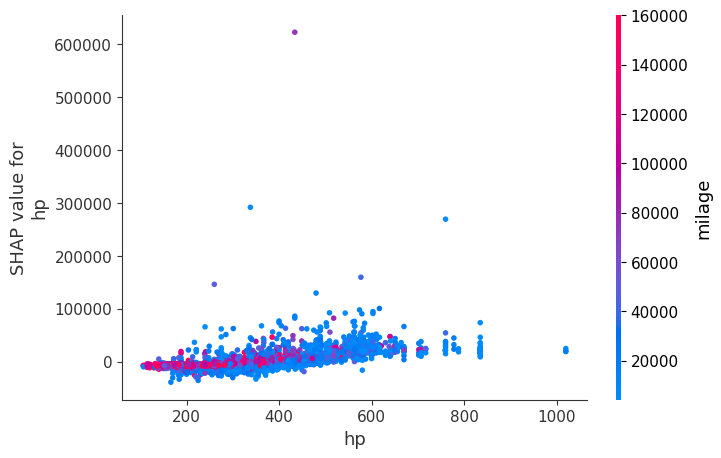

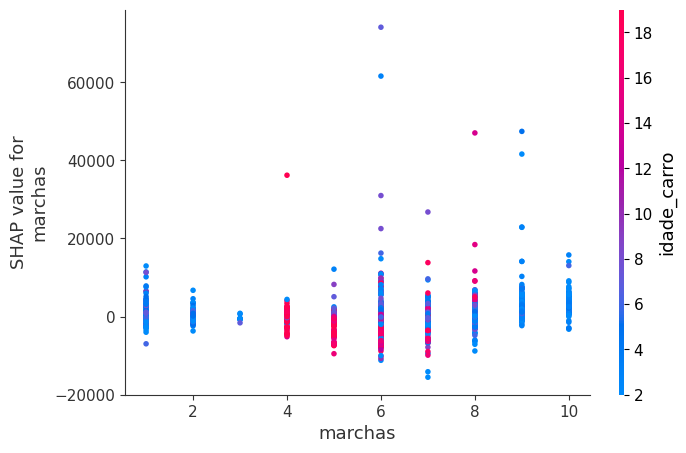

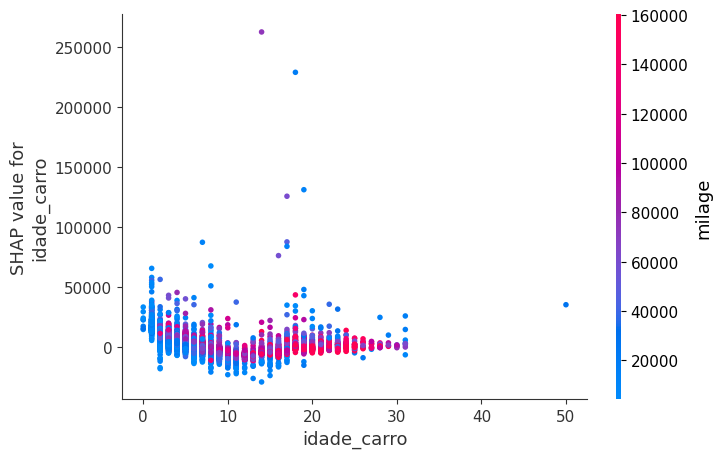

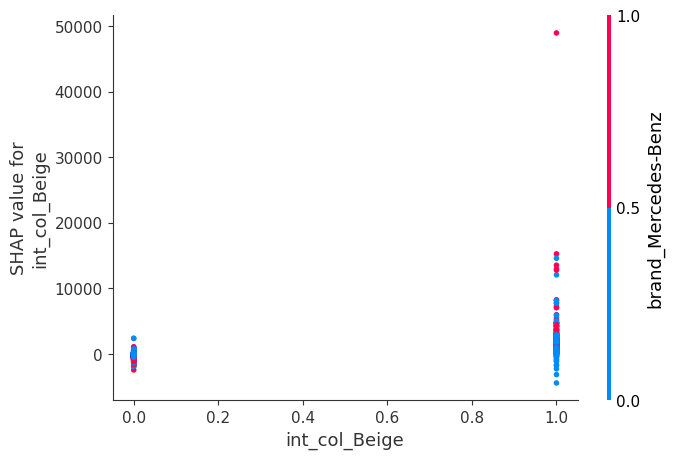

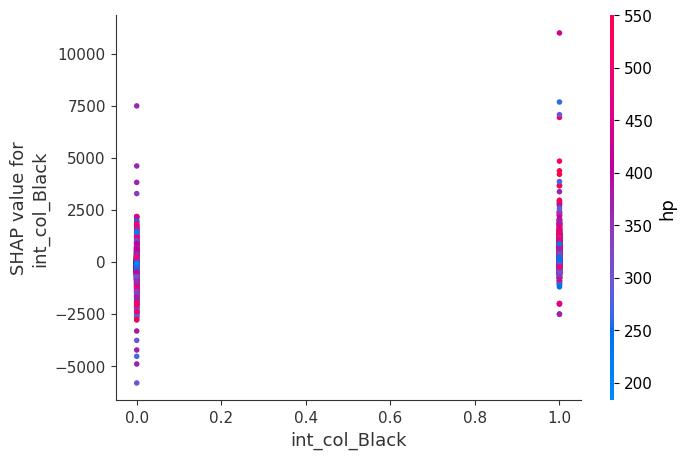

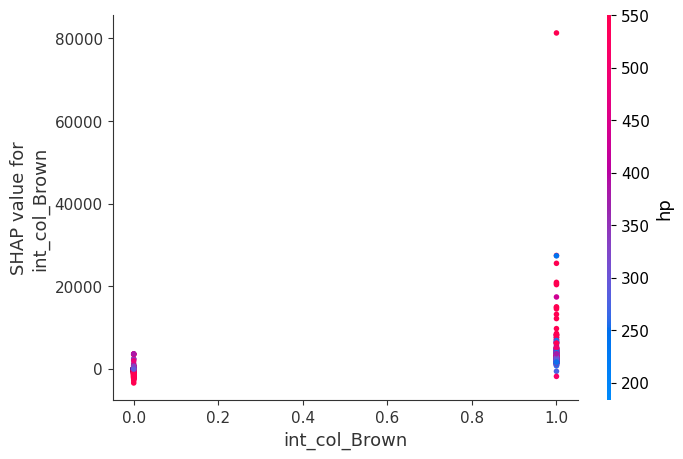

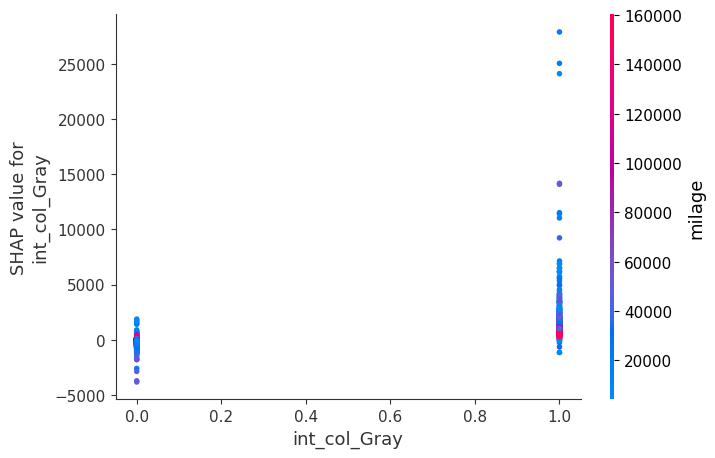

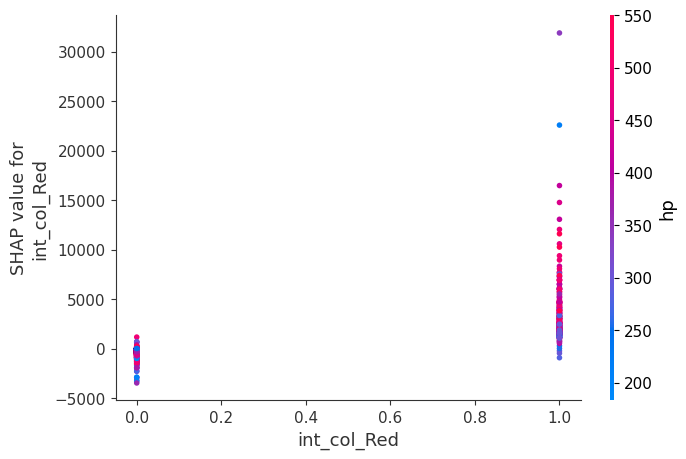

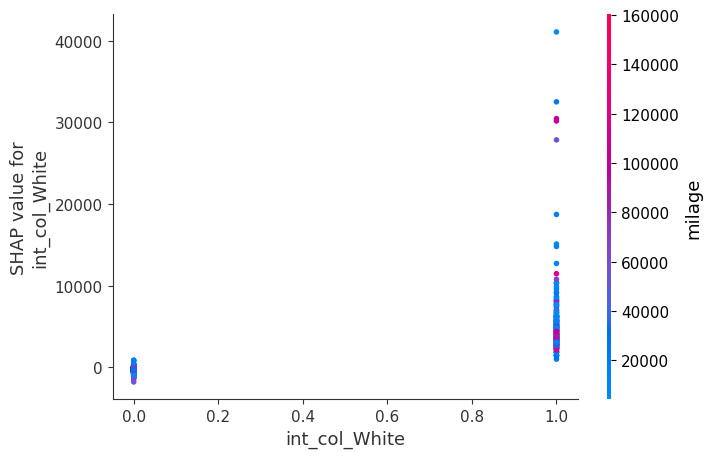

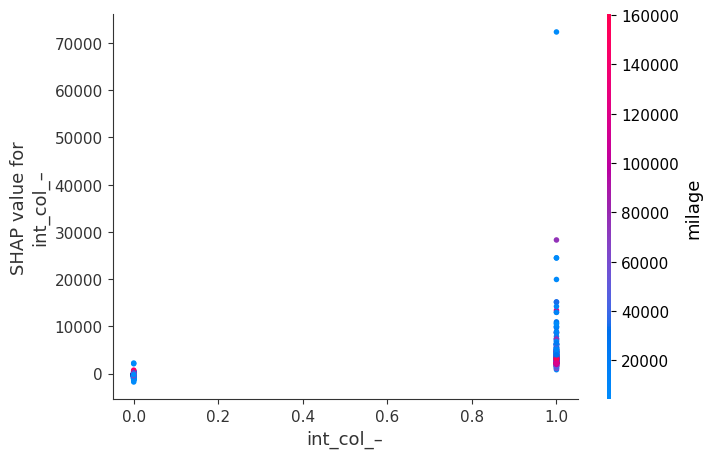

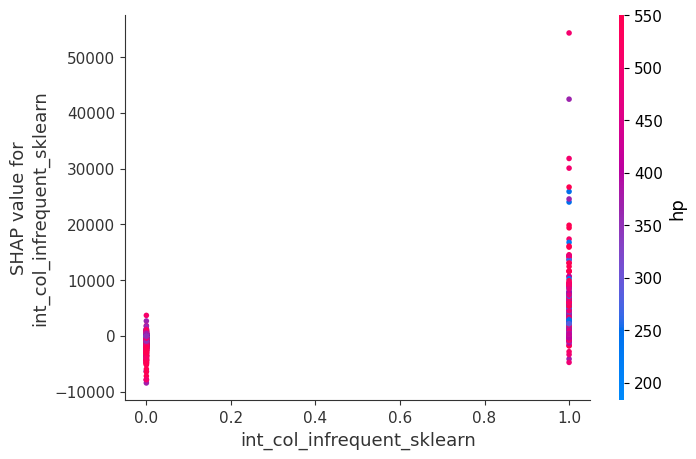

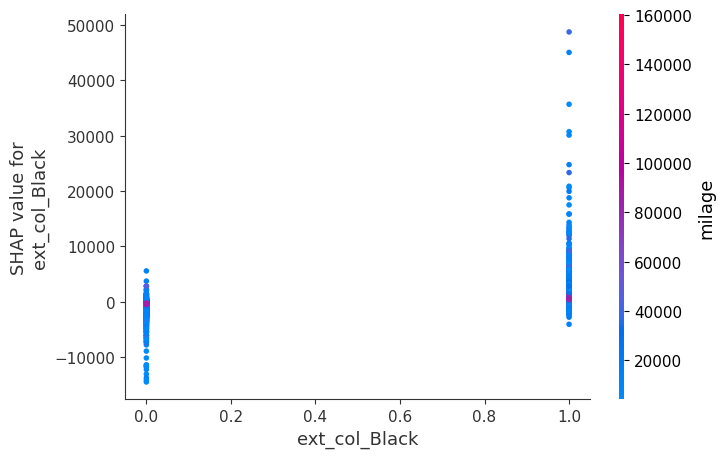

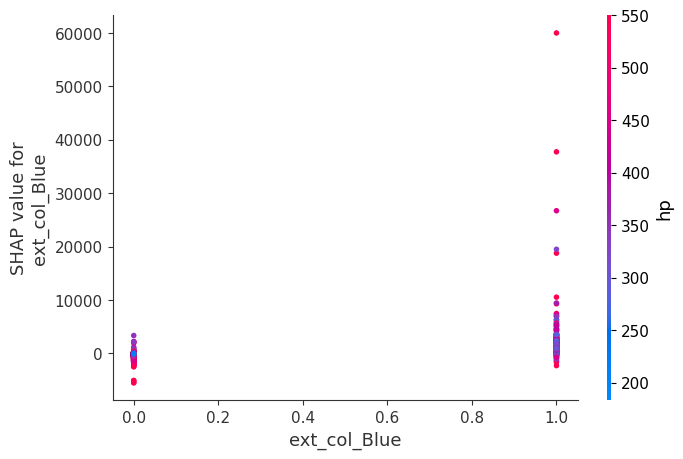

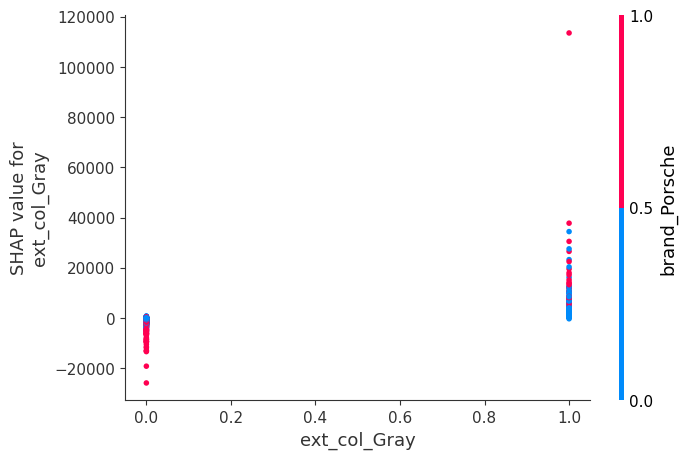

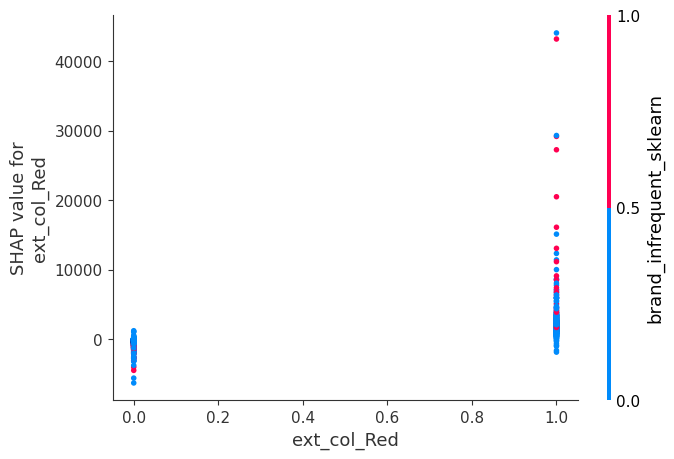

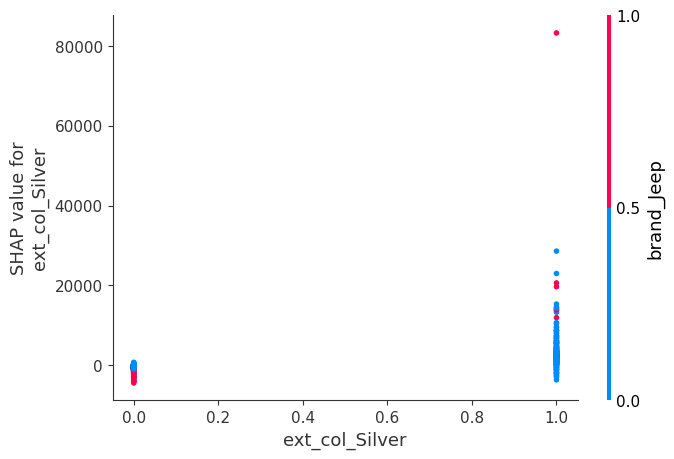

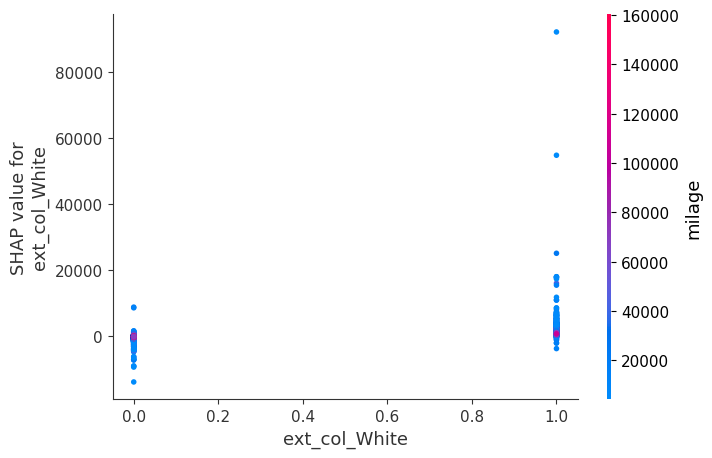

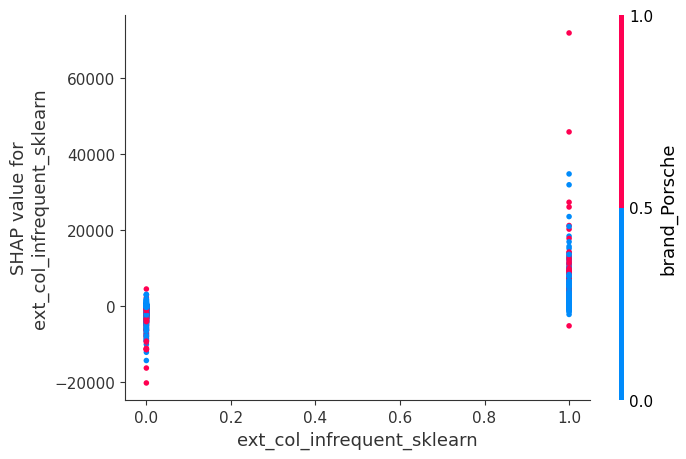

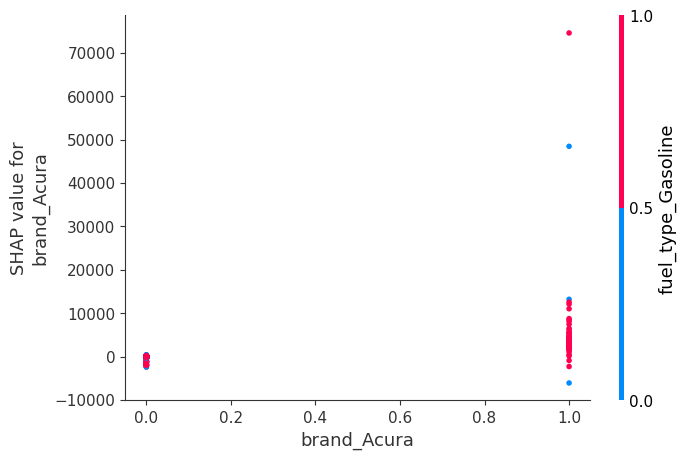

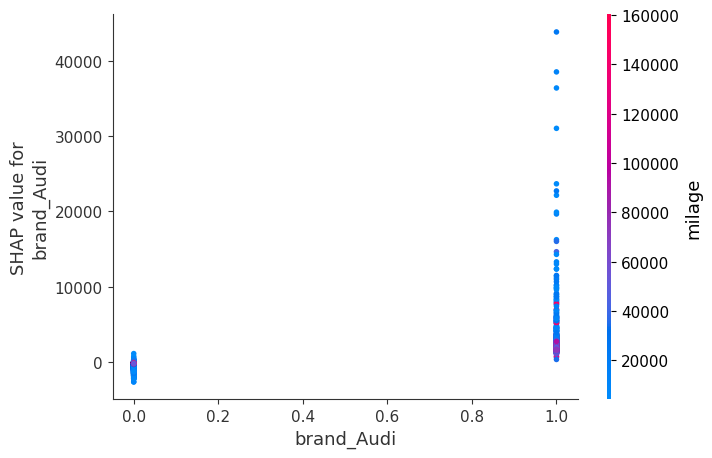

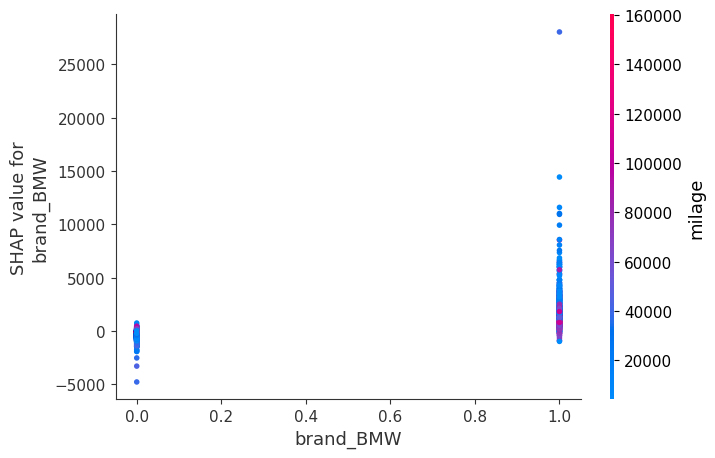

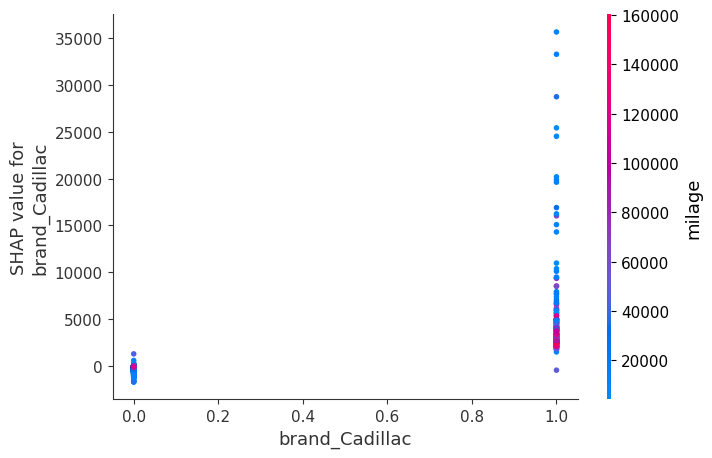

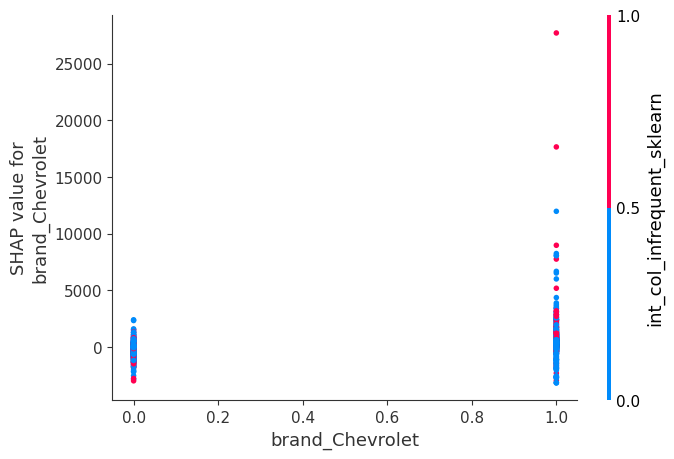

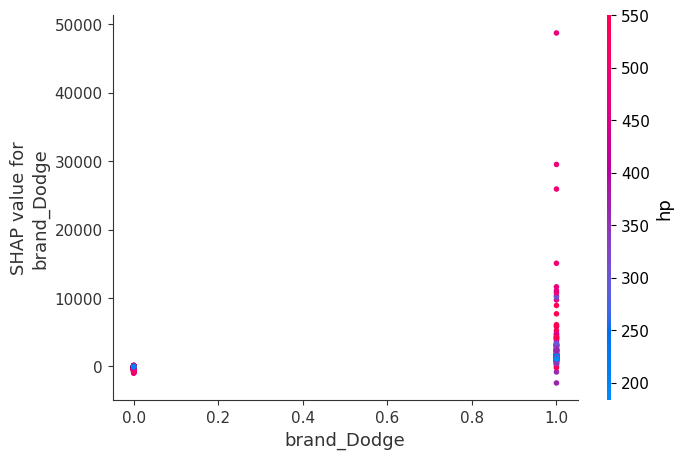

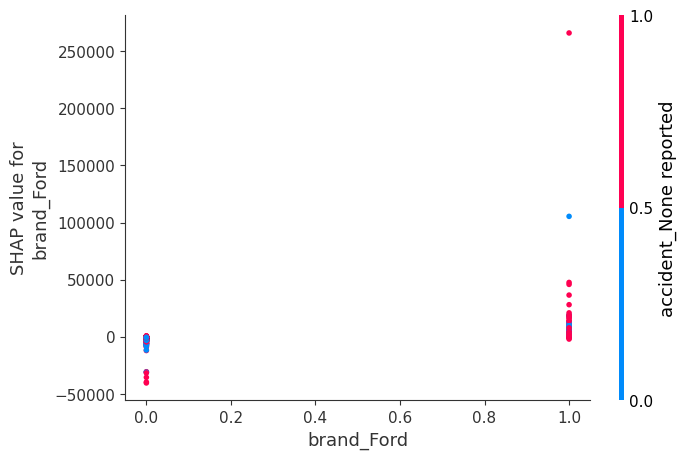

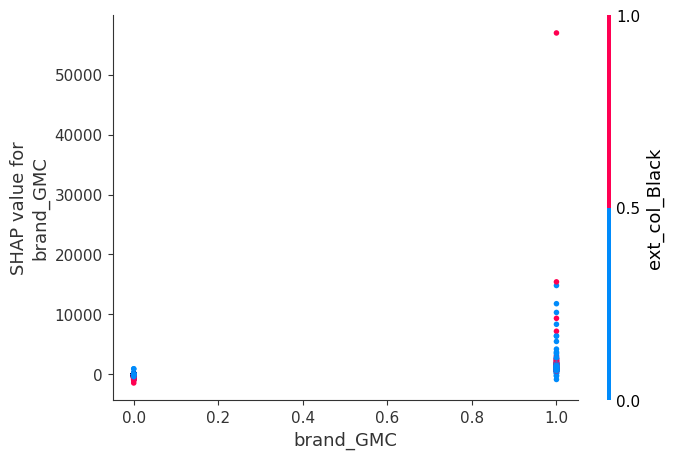

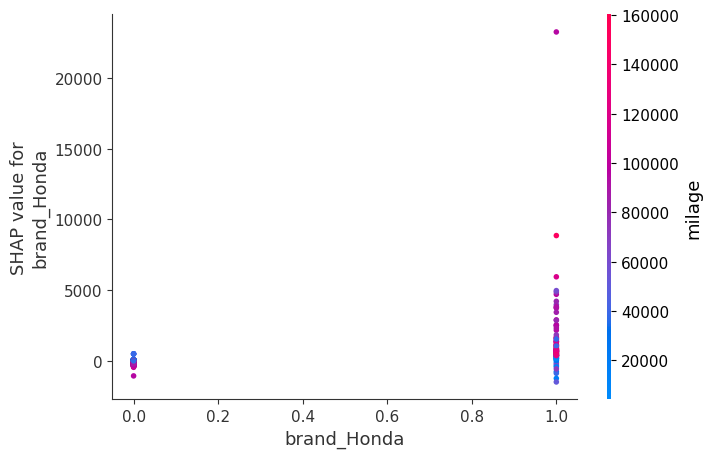

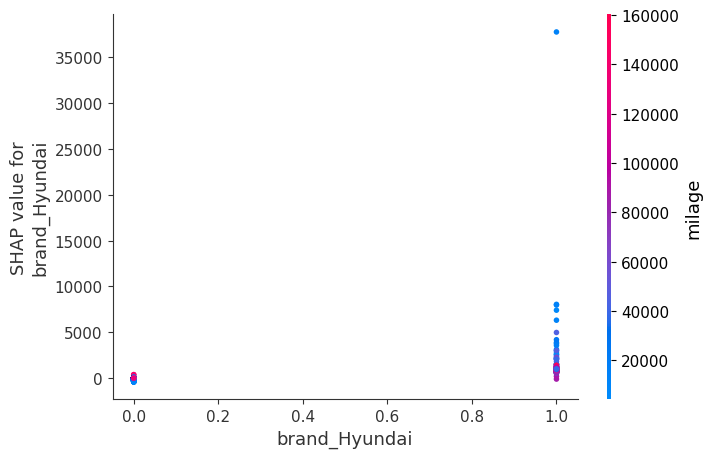

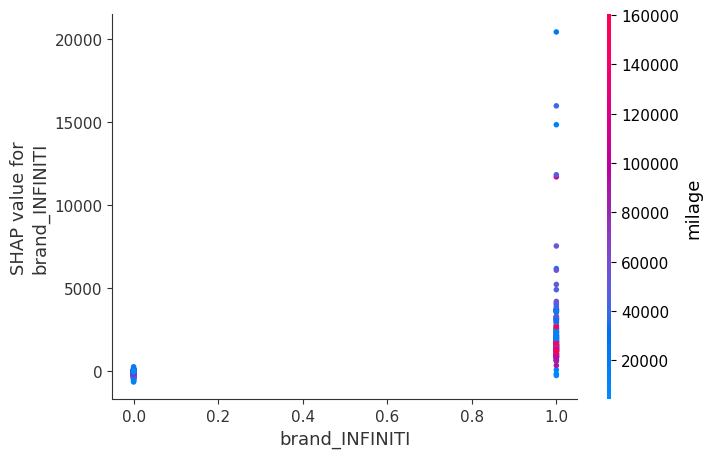

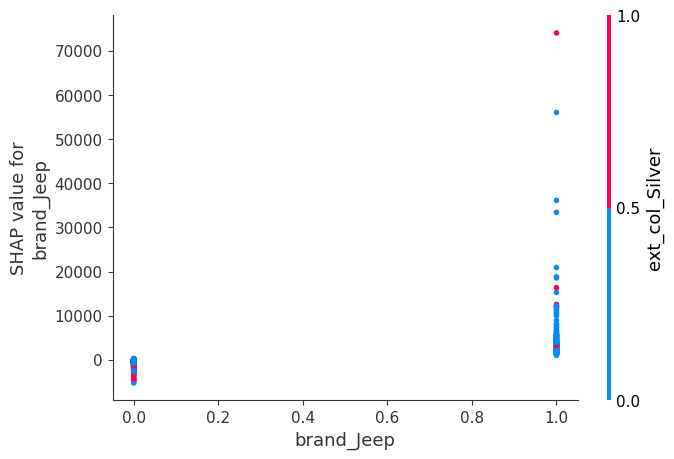

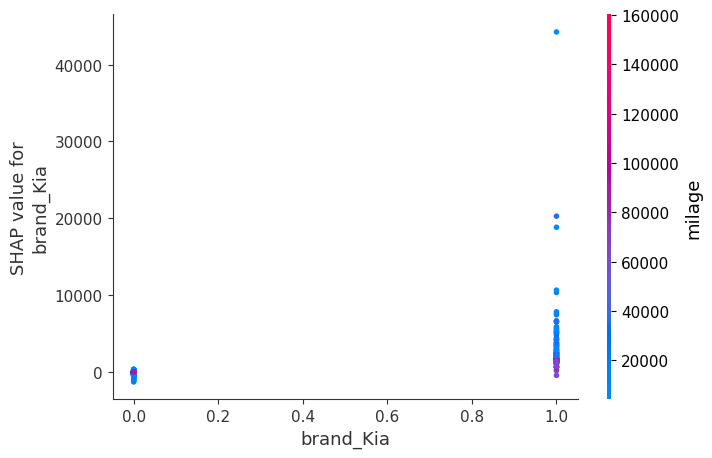

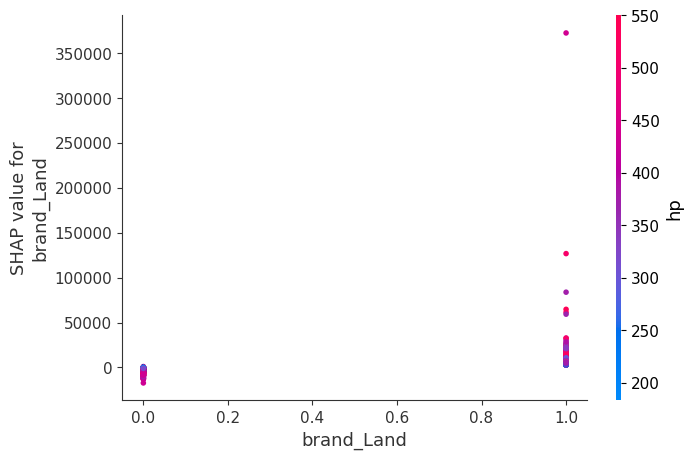

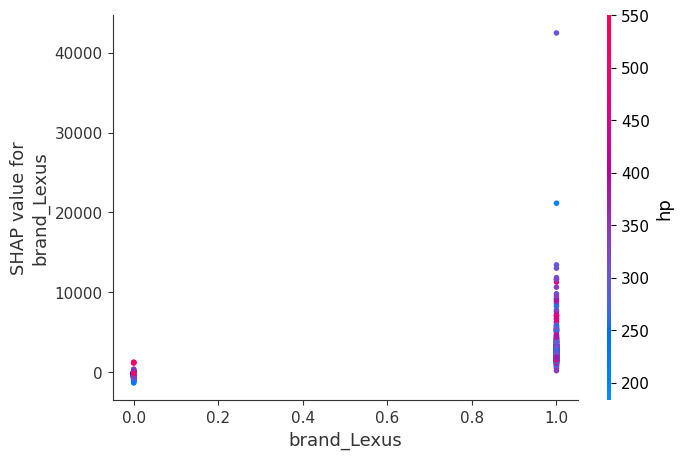

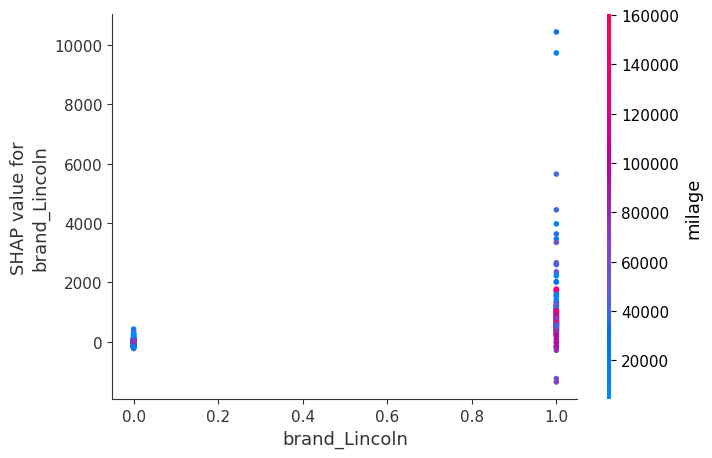

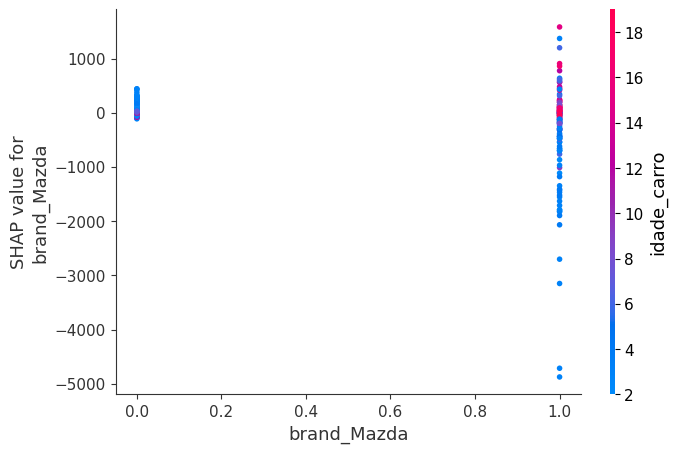

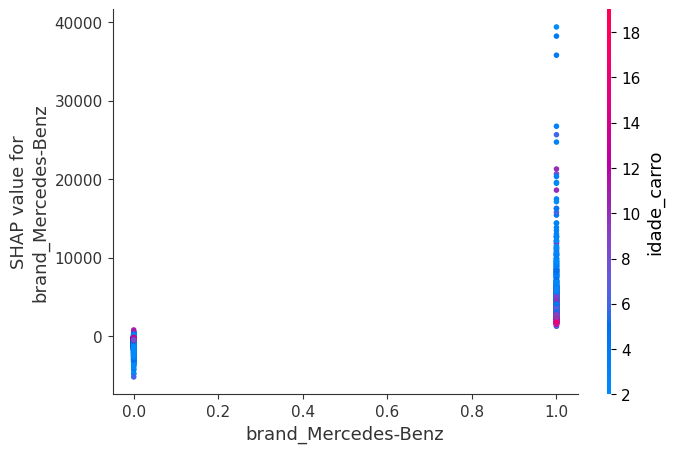

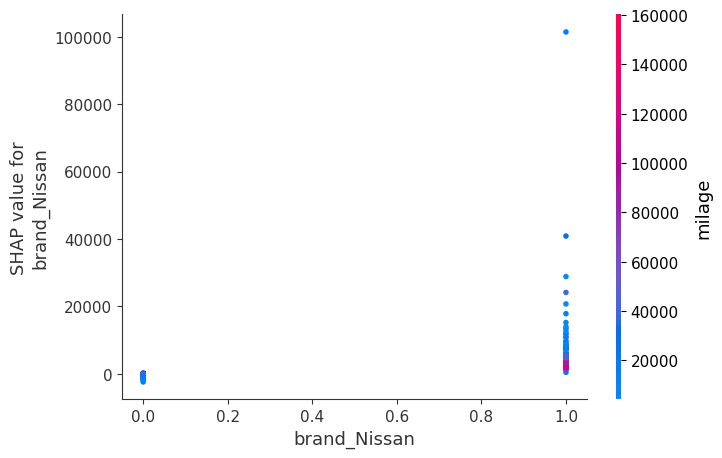

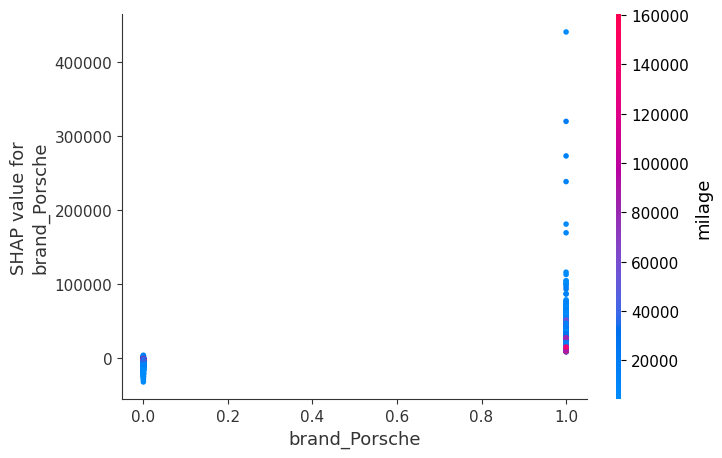

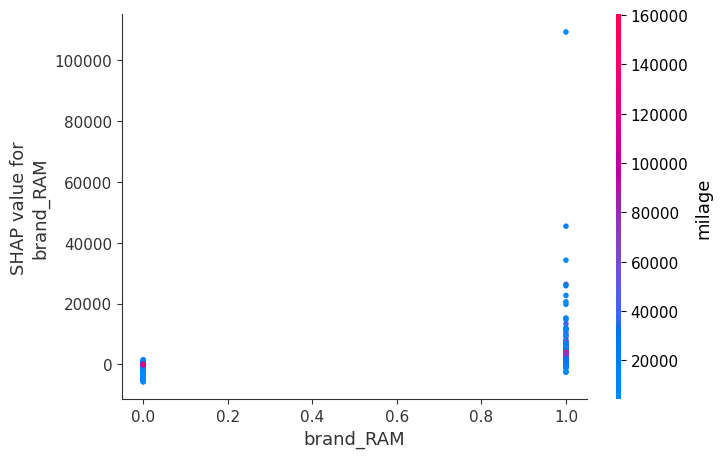

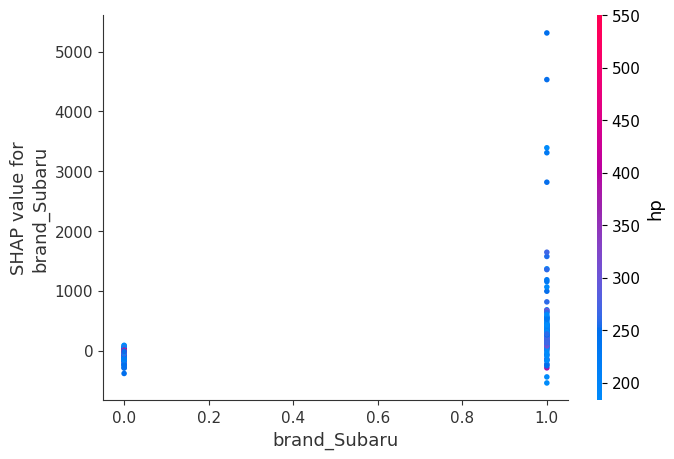

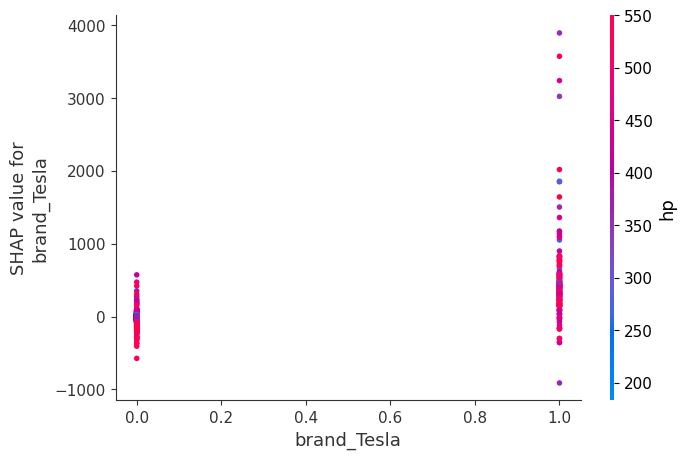

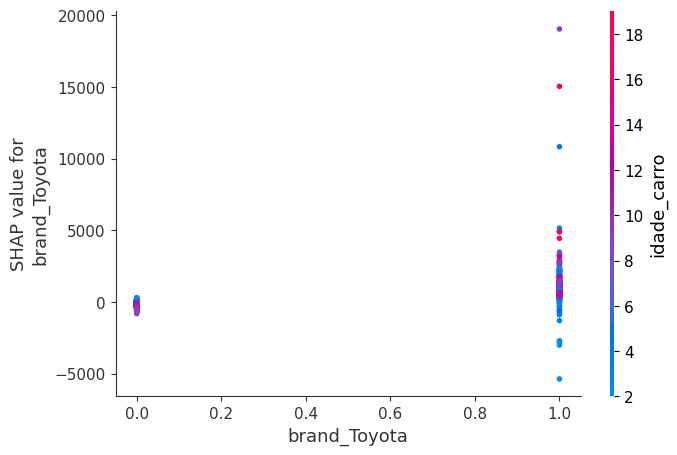

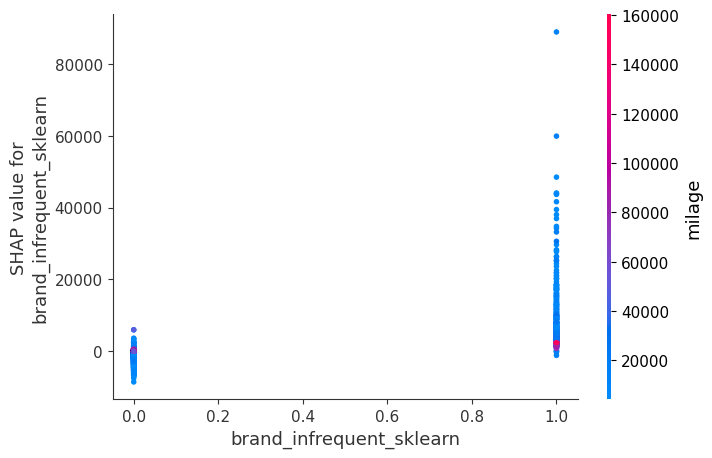

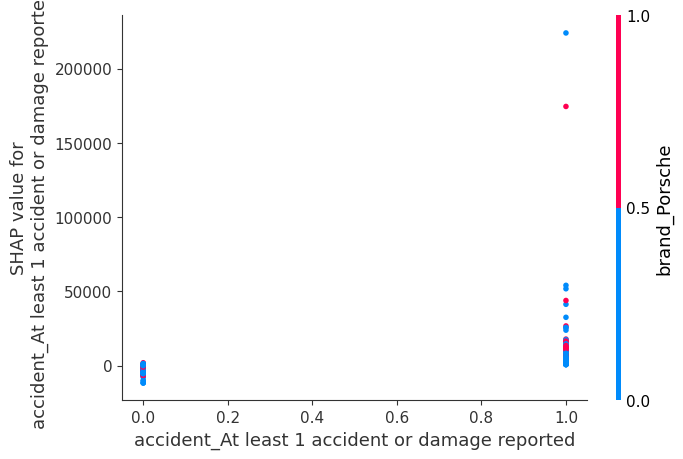

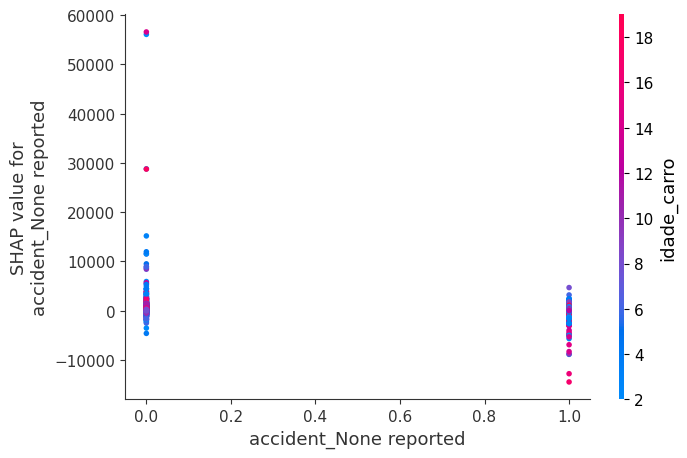

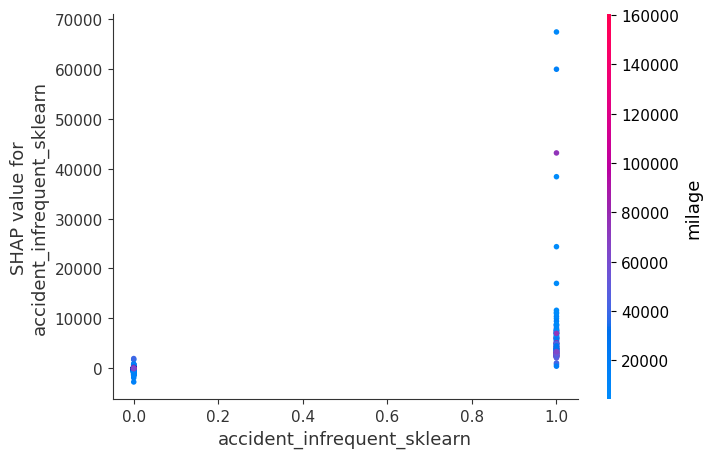

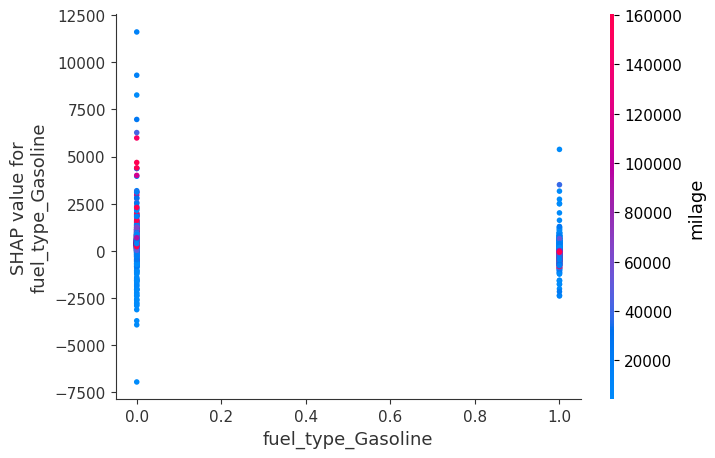

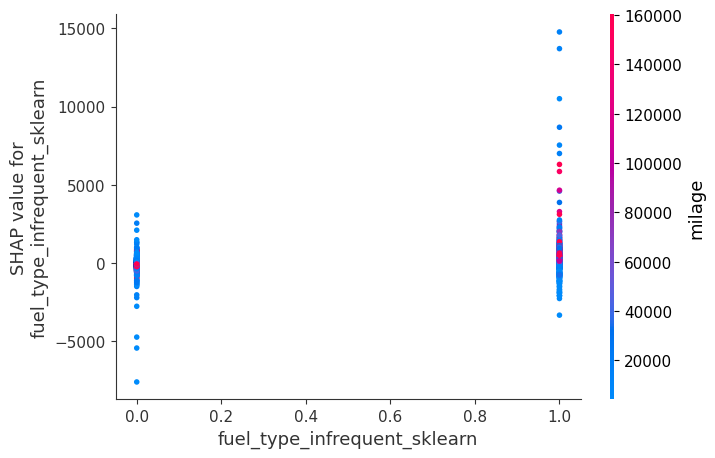

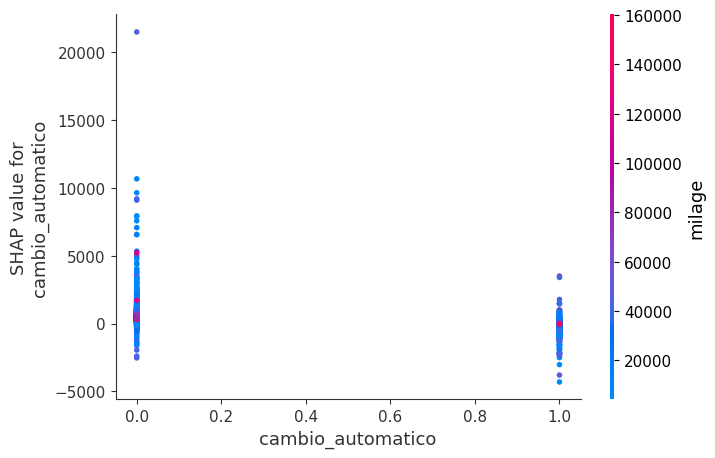

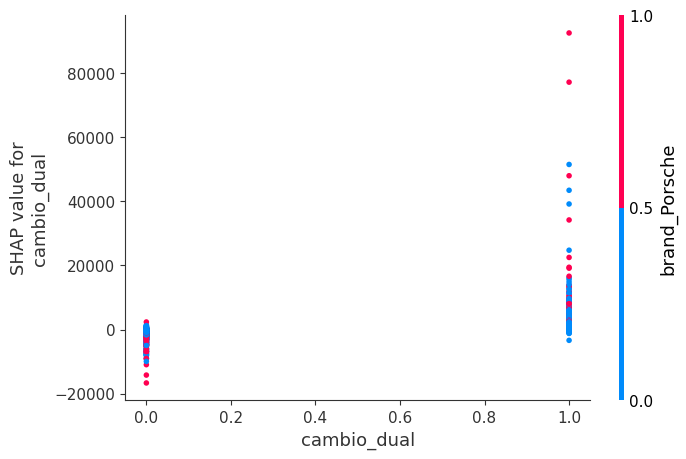

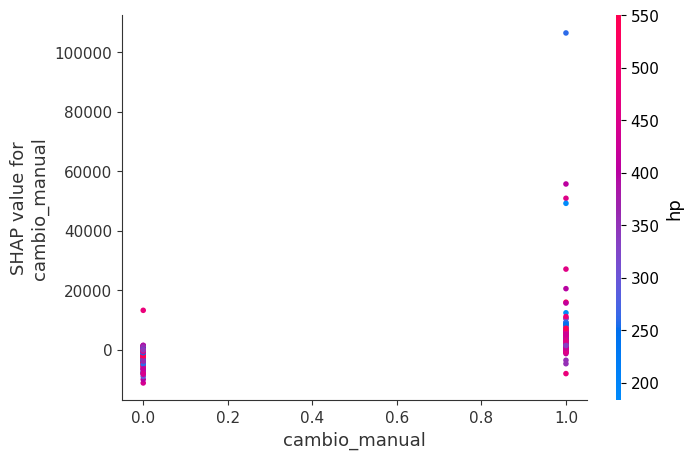

In [13]:
for name in subset_x_treino.columns:
    shap.dependence_plot(name, shap_values.values, subset_x_treino, display_features=subset_x_treino)

# 7_Treinamento_Dos_Modelos

Primeiramente, utilizei onze algoritmos para o treinamento com seus parâmetros padrão:

- `LinearRegression()`
- `DecisionTreeRegressor()`
- `RandomForestRegressor()`
- `GradientBoostingRegressor()`
- `CatBoostRegressor()`
- `keras.Sequential()`
- `SVR()`
- `SGDRegressor()`
- `KNeighborsRegressor()`
- `QuantileRegressor()`
- `RandomForestRegressor()`

O modelo **GradientBoosting** apresentou o melhor desempenho geral, com o menor RMSE e MSE, e um MAE relativamente baixo, tornando-o a escolha mais confiável entre os modelos. **Redes Neurais** e **CatBoost** também se destacaram, embora tenham um desempenho ligeiramente inferior em precisão e explicação da variação dos dados.

**Linear Regression** teve um MAE significativamente alto, sugerindo previsões menos precisas. **RandomForest**, **SVR**, e **KNeighbors** tiveram desempenhos medianos, com erros mais altos e baixa capacidade explicativa (R² muito baixo).

**Decision Tree** e **SGDR** apresentaram resultados extremamente insatisfatórios, com o último indicando um erro de cálculo grave. Em resumo, **GradientBoosting** é a melhor escolha, enquanto **SGDR** e **Decision Tree** devem ser descartados.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Model</th>
      <th>RMSE</th>
      <th>MSE</th>
      <th>MAE</th>
      <th>MAPE</th>
      <th>R2</th>
      <th>ExplainedVariance</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>3</th>
      <td>GradientBoosting</td>
      <td>84577.95</td>
      <td>7153429816.57</td>
      <td>20403.63</td>
      <td>0.53</td>
      <td>0.11</td>
      <td>0.11</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Redes_neurais</td>
      <td>85502.12</td>
      <td>7310612256.56</td>
      <td>21152.99</td>
      <td>0.48</td>
      <td>0.09</td>
      <td>0.10</td>
    </tr>
    <tr>
      <th>0</th>
      <td>Linear</td>
      <td>85654.74</td>
      <td>7336734695.69</td>
      <td>23432.51</td>
      <td>0.74</td>
      <td>0.09</td>
      <td>0.09</td>
    </tr>
    <tr>
      <th>9</th>
      <td>CatBoost</td>
      <td>86210.56</td>
      <td>7432261244.01</td>
      <td>20579.82</td>
      <td>0.52</td>
      <td>0.08</td>
      <td>0.08</td>
    </tr>
    <tr>
      <th>7</th>
      <td>XGBR</td>
      <td>86510.40</td>
      <td>7484048894.24</td>
      <td>20853.33</td>
      <td>0.53</td>
      <td>0.07</td>
      <td>0.07</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Quantile</td>
      <td>87247.60</td>
      <td>7612143629.71</td>
      <td>20809.65</td>
      <td>0.51</td>
      <td>0.05</td>
      <td>0.07</td>
    </tr>
    <tr>
      <th>5</th>
      <td>SVR</td>
      <td>88525.66</td>
      <td>7836792869.53</td>
      <td>22057.49</td>
      <td>0.54</td>
      <td>0.03</td>
      <td>0.05</td>
    </tr>
    <tr>
      <th>2</th>
      <td>RandomForest</td>
      <td>88606.14</td>
      <td>7851048450.30</td>
      <td>22298.04</td>
      <td>0.56</td>
      <td>0.02</td>
      <td>0.02</td>
    </tr>
    <tr>
      <th>4</th>
      <td>KNeighbors</td>
      <td>89134.08</td>
      <td>7944884106.39</td>
      <td>23171.82</td>
      <td>0.57</td>
      <td>0.01</td>
      <td>0.01</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Decision_tree</td>
      <td>115366.31</td>
      <td>13309385281.26</td>
      <td>28740.35</td>
      <td>0.70</td>
      <td>-0.65</td>
      <td>-0.65</td>
    </tr>
    <tr>
      <th>10</th>
      <td>SGDR</td>
      <td>487363997117125312.00</td>
      <td>237523665685981347699930809092800512.00</td>
      <td>387990650036058944.00</td>
      <td>27434527821995.32</td>
      <td>-29535066995239774792450048.00</td>
      <td>-10816457118337098342989824.00</td>
    </tr>
  </tbody>
</table>
</div>


**Ranking dos Modelos**

O gráfico abaixo mostra quantas vezes cada modelo ficou em cada posição, através do ranqueamento da diferença entre sua predição e o valor real. O modelo **Decision Tree** foi o que mais vezes ficou em primeiro lugar, mas também ficou muitas vezes em penúltimo, demonstrando que ele é bastante inconsistente em suas predições. **GradientBoosting** e **CatBoost** se destacam como os modelos mais consistentes, frequentemente ocupando posições intermediárias e superiores, com poucas ocorrências nas últimas posições. **RandomForest** e **XGBR** também apresentam um bom equilíbrio, mantendo-se nas posições medianas, sugerindo boa performance geral. Em contrapartida, **Linear** frequentemente ocupa posições mais baixas, sendo o modelo frequentemente classificado em penúltimo lugar. **Redes Neurais**, **SVR** e **KNeighbors** têm um desempenho mediano, com posições distribuídas de forma equilibrada, mas raramente nas primeiras colocações. **Quantile** apresenta uma variação significativa, ficando tanto nas melhores quanto nas piores posições. No geral, **GradientBoosting** e **CatBoost** são as escolhas mais confiáveis, enquanto **Decision Tree** tem o pior desempenho.

![imagens](imagens/distribuição_posições_modelos.png)


Para a tunagem dos parametros selecionarei os modelos:

- **GradientBoosting**
- **CatBoost**
- **Redes Neurais**
- **XGBR**
- **RandomForest**




In [11]:
## criar a redes_neural

model_rede = keras.Sequential()
model_rede.add(layers.Dense(units=40, activation='relu', input_shape=(x_train.shape[1],)))
model_rede.add(layers.Dense(units=60, activation='relu'))
model_rede.add(layers.Dense(units=40, activation='relu'))
model_rede.add(layers.Dense(units=1, activation='linear'))  # saída para regressão

model_rede.compile(optimizer="adam", 
                   loss='mse',
                   metrics=[keras.metrics.RootMeanSquaredError()])


In [13]:
diretorio = 'dados'
diretorio_models = 'modelos'
## criar os modelos base
treinar_modelos_base = False
if treinar_modelos_base:
    modelos = {
        'Linear': LinearRegression(),
        'Decision_tree':DecisionTreeRegressor(),
        'RandomForest':RandomForestRegressor(),
        'GradientBoosting':GradientBoostingRegressor(),
        'KNeighbors':KNeighborsRegressor(),
        'SVR':SVR(),
        'Redes_neurais':model_rede,
        'XGBR':XGBRegressor(),
        'Quantile':QuantileRegressor(),
        'CatBoost':CatBoostRegressor(),
        'SGDR':SGDRegressor()
    }
    predict_padrao = {}
    modelos_base_treinados = {}
    for name, model in modelos.items():
        if name == 'Redes_neurais':
            epochs_hist = model.fit(x_train, 
                                y_train, 
                                epochs=50, 
                                batch_size=200, 
                                verbose=0)
            
            modelos_base_treinados[name] = model
            y_pred = model.predict(x_test).squeeze()
            predict_padrao[name] = y_pred
            print('O modelo treinado é o:', name)
        else:
            if name == 'CatBoost':
                model_treinado = model.fit(x_train, y_train, verbose=0)
            else:
                model_treinado = model.fit(x_train, y_train)
                
            modelos_base_treinados[name] = model
            y_pred = model.predict(x_test)
            predict_padrao[name] = y_pred
            
            print('O modelo treinado é o:', name)
            
    with open(diretorio + '/predictions_padrao.pkl', 'wb') as f:
        pickle.dump(predict_padrao, f)
    with open(diretorio_models+ '/modelos_base_treinados.pkl', 'wb') as f:
        pickle.dump(modelos_base_treinados, f)   
else:
    with open(diretorio_models + '/modelos_base_treinados.pkl', 'rb') as f:
        modelos_base_treinados = pickle.load(f) 
    
    with open(diretorio + '/predictions_padrao.pkl', 'rb') as f:
        predict_padrao = pickle.load(f)

In [14]:
model_metrics_padrao = {
    'Model' : [],
    "RMSE" : [],
    "MSE" :[],
    "MAE" : [],
    'MAPE': [],
    'R2' : [],
    'ExplainedVariance' : [],  
    #'RMSLE': [] 
}
for name, preds in predict_padrao.items():
    model_metrics_padrao["Model"].append(name)
    model_metrics_padrao["RMSE"].append(root_mean_squared_error(y_test, preds))
    model_metrics_padrao["MSE"].append(mean_squared_error(y_test, preds))
    model_metrics_padrao["MAE"].append(mean_absolute_error(y_test, preds))
    model_metrics_padrao["R2"].append(r2_score(y_test, preds))
    model_metrics_padrao["MAPE"].append(mean_absolute_percentage_error(y_test, preds))
    model_metrics_padrao["ExplainedVariance"].append(explained_variance_score(y_test, preds))
    #model_metrics_padrao['RMSLE'].append(root_mean_squared_log_error(y_test, preds))


results_padrao = pd.DataFrame(model_metrics_padrao).sort_values(by='RMSE')
results_padrao

Model                  RMSE  \
3   GradientBoosting              84577.95   
6      Redes_neurais              85502.12   
0             Linear              85654.74   
9           CatBoost              86210.56   
7               XGBR              86510.40   
8           Quantile              87247.60   
5                SVR              88525.66   
2       RandomForest              88606.14   
4         KNeighbors              89134.08   
1      Decision_tree             115366.31   
10              SGDR 487363997117125312.00   

                                       MSE                   MAE  \
3                            7153429816.57              20403.63   
6                            7310612256.56              21152.99   
0                            7336734695.69              23432.51   
9                            7432261244.01              20579.82   
7                            7484048894.24              20853.33   
8                            7612143629.71              20809.65   
5                            7836792869.53              22057.49   
2                            7851048450.30              22298.04   
4                            7944884106.39              23171.82   
1                           13309385281.26              28740.35   
10 237523665685981347699930809092800512.00 387990650036058944.00   

                MAPE                             R2  \
3               0.53                           0.11   
6               0.48                           0.09   
0               0.74                           0.09   
9               0.52                           0.08   
7               0.53                           0.07   
8               0.51                           0.05   
5               0.54                           0.03   
2               0.56                           0.02   
4               0.57                           0.01   
1               0.70                          -0.65   
10 27434527821995.32 -29535066995239774792450048.00   

                ExplainedVariance  
3                            0.11  
6                            0.10  
0                            0.09  
9                            0.08  
7                            0.07  
8                            0.07  
5                            0.05  
2                            0.02  
4                            0.01  
1                           -0.65  
10 -10816457118337098342989824.00

In [15]:
df_predicoes_padrao = pd.DataFrame(predict_padrao)
df_predicoes_padrao['real'] = y_test
df_predicoes_padrao

Linear  Decision_tree  RandomForest  GradientBoosting  KNeighbors  \
0     15544.76        5700.00      11213.87          14140.54     8656.00   
1     -3749.91       60995.00      27650.74          12383.18     7980.00   
2      5740.26        5000.00      10223.76          10836.44     7160.00   
3     26494.76       15700.00      10838.46          14387.07     9860.00   
4     42476.07       34947.50      35705.49          38876.60    44677.00   
...        ...            ...           ...               ...         ...   
37702  8148.91        8500.00       9383.95          13130.22    14827.60   
37703 45975.47       48000.00      45212.08          39922.49    53129.00   
37704 34173.16       27500.00      28709.70          25704.83    33429.00   
37705 16936.61       13999.00      13667.99          13410.05    20737.20   
37706 44770.43       44800.00      33591.28          34475.76    38653.80   

           SVR  Redes_neurais     XGBR  Quantile  CatBoost  \
0     15580.40        8828.18 15298.32  11420.54  12122.12   
1     20698.88       14268.95 14149.50  -2969.11  14304.89   
2     15069.23        9193.11 16536.05  15681.49  11019.63   
3     16207.68       10212.59  9517.24  18290.75  13551.67   
4     28452.14       27053.16 38639.23  34436.96  37654.20   
...        ...            ...      ...       ...       ...   
37702 16029.93        8502.50 10396.00  13895.82  13207.54   
37703 34236.36       28324.21 41592.48  35983.77  41345.38   
37704 33286.22       19106.50 27151.48  31791.47  25318.24   
37705 21684.01        7539.25 14321.75  20299.38  13485.64   
37706 31265.80       28204.64 30821.40  36671.28  31132.98   

                        SGDR   real  
0      733521131061844608.00   6399  
1     1257497542973823232.00  17599  
2      769795244890964480.00  10500  
3      701753504455788032.00   9950  
4      414028309302181568.00  28500  
...                      ...    ...  
37702  709826427557211904.00  10600  
37703  311628342747157696.00  33900  
37704  328618994247954048.00  29995  
37705  542917629579771968.00  15000  
37706  364695123843366656.00  21500  

[37707 rows x 12 columns]

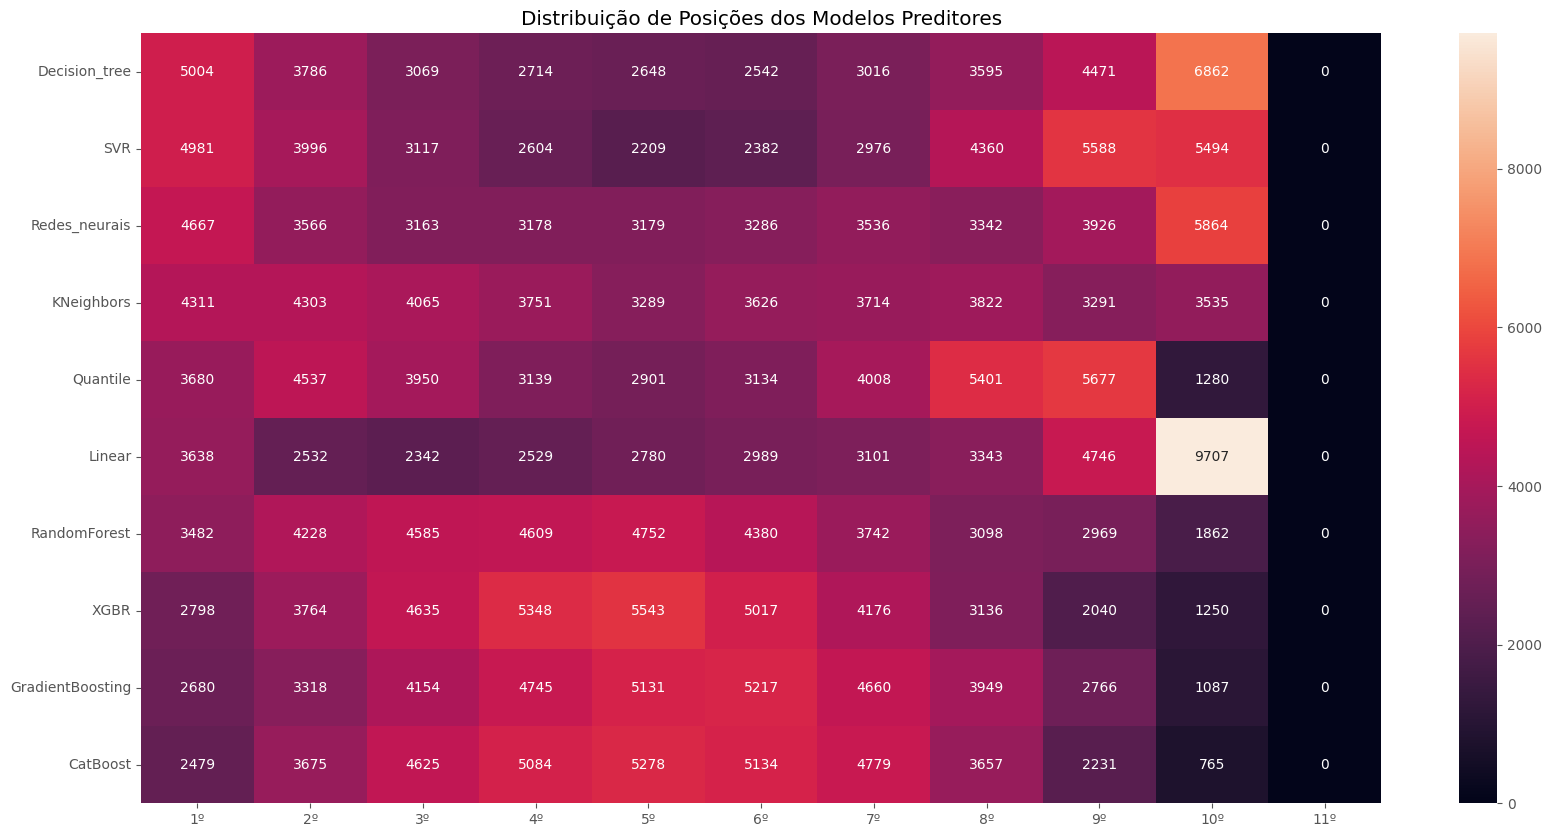

In [53]:
df_predicoes_padrao = pd.DataFrame(predict_padrao)
df_predicoes_padrao['real'] = y_test
# Remover a coluna 'real' para cálculos
predictions = df_predicoes_padrao.drop(columns=['real'])

# Calcular o erro absoluto (diferença absoluta entre previsão e valor real)
absolute_errors = predictions.sub(df_predicoes_padrao['real'], axis=0).abs()

# Função para classificar e gerar rankings (1º, 2º, 3º, etc.)
def rank_models(errors):
    return errors.rank(axis=1, method='min', ascending=True).astype(int)

# Gerar o ranking para cada linha (quanto menor o erro, melhor a posição)
rankings = rank_models(absolute_errors)

# Contar quantas vezes cada modelo ficou em cada posição
position_counts = pd.DataFrame({i: (rankings == i).sum() for i in range(1, rankings.shape[1] + 1)})

# Transpor para que as linhas sejam os algoritmos e as colunas as posições
position_counts.index = predictions.columns
position_counts.columns = [f"{i}º" for i in position_counts.columns]
#plt.ticklabel_format(style='plain', axis='both')
plt.figure(figsize=(20,10))
sns.heatmap(position_counts.iloc[0:10].sort_values(by= '1º', ascending=False),annot=True, fmt='.0f')
plt.title('Distribuição de Posições dos Modelos Preditores')
plt.show()

# 8_Avaliação_Dos_Modelos

In [16]:
##Local do diretorio
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/modelos'
else:
    diretorio = 'modelos'
##Pegando os amodelos salvos
selecionando_modelos = ['gradiente_boost_tunado.pkl', 'cat_boost_tunado.pkl', 'random_forest_tunado.pkl', 'redes_neurais_tunado.h5',] # Modelos tunado 
dic_modelos = {}
for index, model in enumerate(selecionando_modelos):
    with open(diretorio+'/'+ model, 'rb') as f:
        if 'redes_neurais_tunado.h5' in selecionando_modelos[index]:
            dic_modelos[selecionando_modelos[index].split('.h5')[0]] = keras.models.load_model(diretorio + '/redes_neurais_tunado.h5')
        else:
            dic_modelos[selecionando_modelos[index].split('.pkl')[0]] = pickle.load(f)

In [17]:
predict_tunado = {}
for name, model in dic_modelos.items():
    y_pred = dic_modelos[name].predict(x_test).squeeze()
    predict_tunado[name] = y_pred        
    print('O modelo treinado é o:', name)
    if name == 'redes_neurais_tunado':
        dic_modelos[name].summary()
    else:
        print(dic_modelos[name].best_params_)

O modelo treinado é o: gradiente_boost_tunado
{'n_estimators': 70, 'max_features': 10, 'max_depth': 2, 'learning_rate': 0.2, 'criterion': 'squared_error'}
O modelo treinado é o: cat_boost_tunado
{'learning_rate': 0.8, 'l2_leaf_reg': 7, 'iterations': 50, 'depth': 5}
O modelo treinado é o: random_forest_tunado
{'n_estimators': 50, 'max_features': 6, 'max_depth': 70, 'criterion': 'absolute_error'}
1179/1179 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
O modelo treinado é o: redes_neurais_tunado


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,987 (23.39 KB)

 Trainable params: 5,985 (23.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [18]:
model_metrics_padrao = {
    'Model' : [],
    "RMSE" : [],
    "MSE" :[],
    "MAE" : [],
    'MAPE': [],
    'R2' : [],
    'ExplainedVariance' : [],  
    #'RMSLE': [] 
}
for name, preds in predict_tunado.items():
    model_metrics_padrao["Model"].append(name)
    model_metrics_padrao["RMSE"].append(root_mean_squared_error(y_test, preds))
    model_metrics_padrao["MSE"].append(mean_squared_error(y_test, preds))
    model_metrics_padrao["MAE"].append(mean_absolute_error(y_test, preds))
    model_metrics_padrao["R2"].append(r2_score(y_test, preds))
    model_metrics_padrao["MAPE"].append(mean_absolute_percentage_error(y_test, preds))
    model_metrics_padrao["ExplainedVariance"].append(explained_variance_score(y_test, preds))
    #model_metrics_padrao['RMSLE'].append(root_mean_squared_log_error(y_test, preds))


results_padrao = pd.DataFrame(model_metrics_padrao).sort_values(by='RMSE')
results_padrao

Model     RMSE           MSE      MAE  MAPE   R2  \
0  gradiente_boost_tunado 84718.02 7177142338.58 20774.68  0.55 0.11   
1        cat_boost_tunado 84938.16 7214490373.20 20685.72  0.53 0.10   
3    redes_neurais_tunado 85405.27 7294060817.89 21437.62  0.52 0.09   
2    random_forest_tunado 86644.89 7507337584.81 20929.72  0.51 0.07   

   ExplainedVariance  
0               0.11  
1               0.10  
3               0.10  
2               0.07

In [21]:
diretorio = 'modelos'
with open(diretorio + '/modelos_teste_caracteristicas.pkl', 'rb') as f:
    modelos_base_treinados = pickle.load(f)

diretorio = 'dados'
with open(diretorio + '/resultados_teste_caracterisricas.pkl','rb') as f:
    results_padrao = pickle.load(f)

with open(diretorio + '/predicoes_teste_caracterisricas.pkl','rb') as f:
    predict_modelos = pickle.load(f)



In [ ]:
train_numerical_sem_nan = train.copy()
float_cols = train_numerical_sem_nan.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="median")
train_numerical_sem_nan[float_cols] = imputer.fit_transform(train_numerical_sem_nan[float_cols])
col_numeric = ['model_year', 'milage', 'price', 'hp', 'marchas','idade_carro','cilindros']
for col in col_numeric:
    stand = StandardScaler()
    norm = MinMaxScaler()
    box = BoxCoxTransformer()
    log = LogCpTransformer()
    jonson = YeoJohnsonTransformer()

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))

    axes[0][0].hist(train_numerical_sem_nan[col], label=col)
    axes[0][0].set_title(f'Distribuições coluna {col}')
    axes[0][0].legend()

    axes[0][1].hist(stand.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_stand')
    axes[0][1].set_title(f'{col} transformada por StandardScaler')

    axes[0][2].hist(norm.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_norm')
    axes[0][2].set_title(f'{col} transformada por MinMaxScaler')

    axes[1][0].hist(log.fit_transform(train_numerical_sem_nan[[col]]), label=f'{col}_log')
    axes[1][0].set_title(f'{col} transformada por LogCpTransformer')

    try:
        axes[1][1].hist(box.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_box')
        axes[1][1].set_title(f'{col} transformada por BoxCoxTransformer')

    except ValueError:
        axes[1][1].set_title('Valores negativos BoxCoxTransformer não transforma.')

    axes[1][2].hist(jonson.fit_transform(train_numerical_sem_nan[[col]]).squeeze(), label=f'{col}_jonson')
    axes[1][2].set_title(f'{col} transformada por YeoJohnsonTransformer')

    plt.tight_layout()
    plt.show()

# 9_Submissão

In [26]:
predict.head()

id brand                 model  model_year  milage fuel_type  \
0  188533  Land        Rover LR2 Base        2015   98000  Gasoline   
1  188534  Land     Rover Defender SE        2020    9142    Hybrid   
2  188535  Ford    Expedition Limited        2022   28121  Gasoline   
3  188536  Audi         A6 2.0T Sport        2016   61258  Gasoline   
4  188537  Audi  A6 2.0T Premium Plus        2018   59000  Gasoline   

                                              engine        transmission  \
0       240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel         6-Speed A/T   
1  395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...         8-Speed A/T   
2                    3.5L V6 24V PDI DOHC Twin Turbo  10-Speed Automatic   
3                                     2.0 Liter TFSI           Automatic   
4       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                 A/T   

           ext_col int_col       accident clean_title  
0            White   Beige  None reported         Yes  
1           Silver   Black  None reported         Yes  
2            White   Ebony  None reported         NaN  
3  Silician Yellow   Black  None reported         NaN  
4             Gray   Black  None reported         Yes

In [25]:
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados'
else:
    diretorio = 'dados'
    
predict = pd.read_csv(diretorio + "/test.csv")
    
trat = Tratamento()

## retirando ids
predict_sem_id, predict_id = trat.retirando_ids(predict)
    
    ## criando coluna cilindros
predict_x_cil = trat.extrair_cilindros(predict_sem_id)
   
## criando coluna hp
predict_x_hp = trat.extrair_hp(predict_x_cil)
    
    ## criando coluna marchas
predict_x_marchas = trat.extrair_marchas(predict_x_hp)
   
    
## criando a coluna idade dos carros
predict_x_idade = trat.extrair_idade_carros(predict_x_marchas)
    
    ## criando coluna cambio
predict_x_cambio = trat.extrair_cambio(predict_x_idade)
    
    ## drop colunas model, model_year, engine, transmission, clean_title
    
columns_drop = ['model','model_year','engine','transmission','clean_title']
predict_x_drop = trat.drop_columns(predict_x_cambio, columns_drop)
    
    ## inputando valores faltantes coluna marchas
categorical_features_marchas = ['cambio','fuel_type'] 
numerical_features_marchas = ['hp', 'idade_carro','cilindros',]
classe_marchas = 'marchas'

predict_x_marchas_sem_na = trat.imputar_dados_faltantes_modelo(predict_x_drop,
                                                           classe_marchas,
                                                           categorical_features=categorical_features_marchas,
                                                           numerical_features=numerical_features_marchas,
                                                           modelo_imputer = modelo_inputer_marchas)
    
## inputando valores faltantes coluna hp
categorical_features_hp = ['cambio','fuel_type'] 
numerical_features_hp = ['marchas', 'idade_carro','cilindros',]
classe_hp = 'hp'

predict_x_hp_sem_na = trat.imputar_dados_faltantes_modelo(predict_x_marchas_sem_na,
                                                        classe_hp,
                                                    categorical_features=categorical_features_hp,
                                                    numerical_features=numerical_features_hp,
                                                    modelo_imputer = modelo_inputer_hp)
    
## imputando valores faltantes coluna cilindros
    
categorical_features_cilindros = ['cambio','fuel_type'] 
numerical_features_cilindros= ['marchas', 'idade_carro','hp',]
classe_cilindros = 'cilindros'
   
predict_x_cilindros_sem_na = trat.imputar_dados_faltantes_modelo(predict_x_hp_sem_na,
                                                        classe_cilindros,
                                                    categorical_features=categorical_features_cilindros,
                                                    numerical_features=numerical_features_cilindros,
                                                    modelo_imputer = modelo_inputer_cilindros)
    
## criando onhot nas colunas categoricas
colunas_onhot = ['int_col', 'ext_col', 'brand','accident','fuel_type','cambio']
porcentagem_frequencia_onhot = [0.02, 0.05, 0.01, 0.03, 0.05, 0.05]
    
predict_x_onhot = trat.criando_onehot(predict_x_cilindros_sem_na,
                                       colunas_onhot, 
                                       model_onehot = modelo_onhot, 
                                       list_frequenci= porcentagem_frequencia_onhot)
    
## normalizando as colunas numericas
col_numeric_stard = ['milage', 'cilindros', 'hp','marchas','idade_carro']

predict_x_stard_numerical = trat.transformacao_variaveis_numericas(predict_x_onhot,
                                                                col_transformada=col_numeric_stard, 
                                                                modelo_imputer=modelo_stard)
    
print(predict_x_onhot.shape)
print('Dados tratados!')


(125690, 53)
Dados tratados!


In [27]:
## Modelo  random_forest_tunado_ven
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/modelos'
else:
    diretorio = 'modelos'

with open(diretorio + '/gradiente_boost_tunado.pkl', 'rb') as f:
    model = pickle.load(f)

In [30]:
# fazendo a predicao
resultado_predict = model.predict(predict_x_onhot)
predict_id = pd.DataFrame(predict_id)
predict_id['price'] = resultado_predict
predict_id.head()

id    price
0  188533 15879.71
1  188534 77163.64
2  188535 59867.42
3  188536 33266.64
4  188537 31855.39

In [33]:
if IN_COLAB:
    diretorio = '/content/drive/Othercomputers/Meu-laptop/Regression-of-Used-Car-Prices/dados/'
else:
    diretorio = 'dados'
predict_id.to_csv(diretorio + '/submission.csv', index=False)